# SHARE Wave 9: Comprehensive Fairness Benchmarking Pipeline v12

## Overview
Benchmarking **26 bias mitigation methods** for mental health prediction using
SHARE Wave 9 data. Evaluates performance (AUROC, balanced accuracy) and fairness
(TPR gap across SES quintiles) using 5-fold stratified cross-validation.

## Outcomes
- **EUROD** (depression), **LS** (life satisfaction), **CASP** (quality of life), **SRH** (self-rated health)

## Methods by Category

| Category | Count | Methods |
|---|---|---|
| **Pre-processing** | 5 | Reweighing, DIR, LFR, CorrelationRemover, SampleReweighting |
| **In-processing** | 13 | PrejudiceRemover, ExpGrad_DP/EO/TPR, GridSearch_TPR/EO, AdvDebiasing, FairGBM, FairConstraints, DecoupledClassifier, GerryFairClassifier, JTT, GroupDRO |
| **Post-processing** | 6 | ThreshOpt_TPR/EO/DP, EqOdds_PP, RejectOption, GroupCalibration |
| **Augmentation** | 2 | CTGAN, FairSMOTE |

## Two-Track Fairness Evaluation
- **Track Q** (13 methods): Use quintile SES → evaluated on TPR_gap (|TPR_Q1 - TPR_Q5|)
- **Track B** (13 methods): Use binary SES → evaluated on TPR_gap_bin

## Key Design Decisions (v12)
- SES quintiles recomputed per-fold (prevents leakage)
- Locked baseline: model selected on fold 0, frozen for all folds
- Sign test + bootstrap CIs (N=5 too small for Wilcoxon)
- Post-processing AUROC marked as not-comparable

## Version History
- **v12-fix2**: Dropped 5 failing methods (OptimPreproc, MetaFairClassifier, CalibEqOdds, OxonFair, DECAF); replaced with 5 practical alternatives (SampleReweighting, GroupCalibration, JTT, GroupDRO, FairSMOTE)
- **v12-patch**: Fixed CalibEqOdds, GerryFairClassifier, GridSearch_EO, LFR parameters
- **v12**: Full rewrite from v6.0; quintile SES, per-fold derivation, locked baseline


---
## 1. Environment Setup
Install dependencies and import all required libraries.

In [1]:
# CELL 1: Install (RUN ONCE, THEN RESTART)

# Core fairness libraries
!pip install -q fairlearn aif360

# ML libraries
!pip install -q xgboost lightgbm shap

!pip install fairgbm

!pip install tensorflow

# Synthetic data
!pip install -q ctgan
!pip install -q imbalanced-learn

# Post-processing + augmentation

# Progress tracking
!pip install -q tqdm

# Label repulsion for plots
!pip install -q adjustText

# Note: TabFairGAN removed in v12 (unstable API)

print("="*60)
print("IMPORTANT: Runtime -> Restart runtime NOW")
print("Then SKIP this cell and run from Cell 2")
print("="*60)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.6 MB/s eta 0:00:00
IMPORTANT: Runtime -> Restart runtime NOW
Then SKIP this cell and run from Cell 2


In [2]:
# v12: Mount Google Drive for persistent output
from google.colab import drive
drive.mount('/content/drive')

# CELL 2: Imports
import os, sys, json, warnings, traceback, datetime, shutil
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Any, Optional
from copy import deepcopy
from collections import defaultdict

import numpy as np

# FIX 3: Import torch for CTGAN/TVAE reproducibility
try:
    import torch
    TORCH_OK = True
except ImportError:
    TORCH_OK = False
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize as scipy_minimize
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             balanced_accuracy_score, roc_curve, auc,
                             precision_score, recall_score, confusion_matrix,
                             brier_score_loss, f1_score, precision_recall_curve)
from sklearn.calibration import calibration_curve

# XGBoost / LightGBM
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except ImportError: XGB_OK = False

try:
    from lightgbm import LGBMClassifier
    LGBM_OK = True
except ImportError: LGBM_OK = False

# Fairlearn
try:
    from fairlearn.reductions import ExponentiatedGradient, GridSearch
    from fairlearn.reductions import DemographicParity, EqualizedOdds, TruePositiveRateParity, FalsePositiveRateParity
    from fairlearn.postprocessing import ThresholdOptimizer
    from fairlearn.preprocessing import CorrelationRemover
    from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
    FL_OK = True
except ImportError: FL_OK = False

# AIF360
try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.algorithms.preprocessing import Reweighing, LFR, DisparateImpactRemover, OptimPreproc
    from aif360.algorithms.inprocessing import PrejudiceRemover, AdversarialDebiasing, MetaFairClassifier, GerryFairClassifier
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    AIF_OK = True
except ImportError:
    AIF_OK = False
except Exception as e:
    print(f"AIF360 import error: {e}")
    AIF_OK = False

# Check for TensorFlow (needed for Adversarial Debiasing)
try:
    import tensorflow as tf
    tf.compat.v1.disable_eager_execution()
    TF_OK = True
except ImportError: TF_OK = False

# CTGAN
try:
    from ctgan import CTGAN
    CTGAN_OK = True
except ImportError: CTGAN_OK = False



# SMOTE
try:
    from imblearn.over_sampling import SMOTE, ADASYN
    SMOTE_OK = True
except ImportError: SMOTE_OK = False

# FairGBM
try:
    from fairgbm import FairGBMClassifier
    FAIRGBM_OK = True
except Exception:
    FAIRGBM_OK = False

# SHAP
try:
    import shap
    SHAP_OK = True
except ImportError: SHAP_OK = False

warnings.filterwarnings('ignore')

# Print status
print("="*60)
print("LIBRARY STATUS")
print("="*60)
libs = [
    ("Fairlearn", FL_OK), ("AIF360", AIF_OK), ("TensorFlow", TF_OK),
    ("CTGAN", CTGAN_OK),
    ("FairGBM", FAIRGBM_OK), ("SMOTE", SMOTE_OK), ("SHAP", SHAP_OK),
    ("XGBoost", XGB_OK), ("LightGBM", LGBM_OK)
]
for name, ok in libs:
    print(f"  {name:15s}: {'✓' if ok else '✗'}")
print("="*60)

# Count available methods
# v6.0: 26 methods (7 pre + 9 in + 6 post + 4 aug)
print(f"Total methods available: 26 (+ 1 baseline = 27)")  # v12: updated roster

Mounted at /content/drive


pip install 'aif360[inFairness]'


LIBRARY STATUS
  Fairlearn      : ✓
  AIF360         : ✓
  TensorFlow     : ✓
  CTGAN          : ✓
  FairGBM        : ✓
  SMOTE          : ✓
  SHAP           : ✓
  XGBoost        : ✓
  LightGBM       : ✓
Total methods available: 26 (+ 1 baseline = 27)


---
## 2. Configuration
Single source of truth for all hyperparameters, paths, thresholds, and leak lists.

In [3]:
# CELL 3: Configuration (v12)
# ============================================================
# v12 CHANGES (inherited from v12):
#   - 5-fold CV (standard; sign test + CIs for stability assessment)
#   - Three-way split: train(60%) / cal(20%) / test(20%)
#   - Locked baseline: model selected on fold 0, frozen for all folds
#   - Sign test (k/N folds improved) replaces formal hypothesis testing
# ============================================================

@dataclass
class Config:
    version: str = "12"
    seed: int = 42
    n_folds: int = 5  # 5-fold CV (standard for fairness benchmarks; Dang et al. 2024)
    data_paths: List[str] = field(default_factory=lambda: ["/content/final_cleaned.csv", "final_cleaned.csv"])
    output_dir: str = "/content/drive/MyDrive/fairness_benchmark_v12"
    outcomes: Dict = field(default_factory=lambda: {"EUROD": {}, "LS": {}, "CASP": {}, "SRH": {}})
    audit_attrs: List[str] = field(default_factory=lambda: ["ses_q", "edu_lv", "gender", "region", "country_no"])
    protected_attr: str = "ses_bin"  # Must be binary for AIF360 methods; quintiles available via ses_q_v/ses_q_te
    id_cols: List[str] = field(default_factory=lambda: ["mergeid", "hhid"])

    # v12: Three-way split fractions (of the ~80% train_val from SKF)
    # train: 75% of train_val = 60% of total
    # cal:   25% of train_val = 20% of total  (threshold + post-processing)
    # test:  from StratifiedKFold = 20% of total (5-fold)
    cal_frac: float = 0.25  # fraction of train_val reserved for calibration

    # EXPLICIT leak lists (no substring matching)
    universal_outcome_leak: List[str] = field(default_factory=lambda: [
        "eurod_categ", "satisfied_life", "casp_12", "health_self",
        "y_EUROD", "y_LS", "y_CASP", "y_SRH"
    ])
    eurod_leak: List[str] = field(default_factory=lambda: [
        "depression", "pessimism", "suicidality", "guilt", "sleep",
        "interest", "irritability", "appetite", "fatigue", "concentration",
        "enjoyment", "tearfulness"
    ])
    ls_leak: List[str] = field(default_factory=lambda: [])
    casp_leak: List[str] = field(default_factory=lambda: [])
    srh_leak: List[str] = field(default_factory=lambda: [])

    # Split (legacy — overridden by cal_frac in v12 CV loop)
    val_size: float = 0.20
    test_size: float = 0.20

    # Thresholds
    auroc_drop: float = 0.02
    sens_floor: float = 0.50
    spec_floor: float = 0.40
    min_auroc: float = 0.60

    # Method params
    n_boot: int = 2000
    ctgan_epochs: int = 50
    ctgan_batch: int = 500
    grid_size: int = 256
    lfr_maxiter: int = 5000

    # v12: Multi-threshold robustness
    robustness_thresholds: List[str] = field(default_factory=lambda: [
        "balanced_accuracy",   # default (Youden-like)
        "sensitivity_70",      # clinical: sens >= 0.70
        "prevalence_matched",  # threshold = prevalence
        "fixed_50",            # naive 0.5
    ])

CFG = Config()
np.random.seed(CFG.seed)

for d in ["tables", "plots", "shap", "calibration", "detailed"]:
    Path(f"{CFG.output_dir}/{d}").mkdir(parents=True, exist_ok=True)

FAIL_LOG = {o: {} for o in CFG.outcomes}

print("✓ Config loaded (v12)")
print(f"  Folds: {CFG.n_folds}, Split: train({1-CFG.cal_frac:.0%}) / cal({CFG.cal_frac:.0%}) / test(SKF)")
print(f"  Robustness thresholds: {CFG.robustness_thresholds}")


# v12: Plot colors (moved here so checkpoint SAVE can access them)
CATEGORY_COLORS = {
    "Baseline": "#4A4A4A",
    "Pre-processing": "#2E86AB",
    "In-processing": "#A23B72",
    "Post-processing": "#F18F01",
    "Augmentation": "#9B59B6",
}

METHOD_COLORS = {
    "BASELINE": "#808080",
    # Pre-processing (blue family)
    "Reweighing": "#1f77b4", "DIR": "#4a90d9", "LFR": "#6baed6",
    # In-processing (warm family)
    "PrejudiceRemover": "#ff7f0e",
    "ExpGrad_DP": "#2ca02c", "ExpGrad_EO": "#3cb44b", "ExpGrad_TPR": "#4dd36a",
    "GridSearch_TPR": "#66c2a5", "GridSearch_EO": "#78d4b7",
    "FairConstraints": "#e6550d", "DecoupledClassifier": "#fd8d3c",
    "GerryFairClassifier": "#c7511f",
    # Post-processing (red/brown family)
    "ThreshOpt_TPR": "#d62728", "ThreshOpt_EO": "#e74c3c", "ThreshOpt_DP": "#c0392b",
    # Augmentation (teal family)
    "CTGAN": "#17becf", "FairSMOTE": "#00ced1",
    "SampleReweighting": "#aec7e8", "GroupCalibration": "#ffbb78",
    "JTT": "#98df8a", "GroupDRO": "#c5b0d5",
    # v12-audit: 5 missing methods
    "CorrelationRemover": "#1B7A94",  # Pre
    "AdvDebiasing":       "#7B2056",  # In
    "FairGBM":            "#C44D8B",  # In
    "EqOdds_PP":          "#D97B00",  # Post
    "RejectOption":       "#B36D00",  # Post
}


✓ Config loaded (v12)
  Folds: 5, Split: train(75%) / cal(25%) / test(SKF)
  Robustness thresholds: ['balanced_accuracy', 'sensitivity_70', 'prevalence_matched', 'fixed_50']


---
## 3. Data Loading & Outcome Creation

In [4]:
# CELL 4: Load Data
df = None
for p in CFG.data_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        # v12-patch: Convert "non_applicable" to NaN, then coerce to numeric
        # These object columns encode missingness as "non_applicable" strings
        for col in df.columns:
            if df[col].dtype == 'object' and col not in CFG.id_cols:
                df[col] = df[col].replace("non_applicable", np.nan)
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"✓ Loaded: {p}, Shape: {df.shape}")
        break
if df is None:
    raise FileNotFoundError("Upload final_cleaned.csv")

✓ Loaded: /content/final_cleaned.csv, Shape: (51720, 175)


In [5]:
# CELL 5: Create Outcomes
# EUROD: Depression (1 = depressed)
df["y_EUROD"] = (df["eurod_categ"] == 1).astype(int)

# LS: Life Satisfaction (1 = low satisfaction, ≤7 on 0-10 scale)
df["y_LS"] = (df["satisfied_life"] <= 7).astype(int)

# CASP: Quality of Life (1 = low QoL, ≤34)
df["y_CASP"] = (df["casp_12"] <= 34).astype(int)

# SRH: Self-Rated Health (1 = poor health, ≥4 on 1-5 scale)
# health_self: 1=excellent, 2=very good, 3=good, 4=fair, 5=poor
df["y_SRH"] = (df["health_self"] >= 4).astype(int)

print("Outcomes created (y=1 = unfavorable):")
for o in ["EUROD", "LS", "CASP", "SRH"]:
    print(f"  {o}: {df[f'y_{o}'].mean():.1%} positive")

Outcomes created (y=1 = unfavorable):
  EUROD: 26.3% positive
  LS: 29.9% positive
  CASP: 29.1% positive
  SRH: 36.3% positive


---
## 4. Cross-Validation & SES Derivation
5-fold stratified CV. SES quintiles are recomputed per-fold from training data to prevent information leakage (v7.0+ fix).

In [6]:
# CELL 6: 5-Fold Cross-Validation Setup (v12)
from sklearn.model_selection import StratifiedKFold

print("="*60)
print(f"SETTING UP {CFG.n_folds}-FOLD CROSS-VALIDATION (v12)")
print("="*60)

# Create joint stratification key for all 4 outcomes
y_strat = (df["y_EUROD"].astype(str) + "_" + df["y_LS"].astype(str) + "_" +
           df["y_CASP"].astype(str) + "_" + df["y_SRH"].astype(str))

strat_counts = y_strat.value_counts()
min_stratum = strat_counts.min()
print(f"Joint stratification: {len(strat_counts)} strata")
print(f"Smallest stratum: {min_stratum} samples")

if min_stratum < CFG.n_folds * 2:
    print(f"⚠️ Smallest stratum < {CFG.n_folds * 2}, using EUROD-only stratification")
    y_strat = df["y_EUROD"]

skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
FOLD_INDICES = list(skf.split(df, y_strat))

print(f"\n✓ Created {CFG.n_folds} folds:")
for fold_idx, (train_idx, test_idx) in enumerate(FOLD_INDICES):
    print(f"  Fold {fold_idx}: Train+Cal={len(train_idx)}, Test={len(test_idx)}")

# v12: Initialize fold 0 with THREE-WAY STRATIFIED split for pre-CV cells
train_val_idx, test_idx = FOLD_INDICES[0]

# Stratify cal split by the rarest outcome (EUROD) to preserve label balance
_strat_key = df.loc[train_val_idx, "y_EUROD"]
train_idx, cal_idx = train_test_split(
    train_val_idx, test_size=CFG.cal_frac,
    stratify=_strat_key, random_state=CFG.seed
)
train_idx, cal_idx = np.array(train_idx), np.array(cal_idx)

# v12: SPLITS uses "val" key for backward compat (methods access d["Xv"])
# but the data is actually the CALIBRATION set
SPLITS = {"train": train_idx, "val": cal_idx, "test": test_idx}
print(f"\nFold 0 (init): Train={len(train_idx)}, Cal={len(cal_idx)}, Test={len(test_idx)}")


SETTING UP 5-FOLD CROSS-VALIDATION (v12)
Joint stratification: 16 strata
Smallest stratum: 684 samples

✓ Created 5 folds:
  Fold 0: Train+Cal=41376, Test=10344
  Fold 1: Train+Cal=41376, Test=10344
  Fold 2: Train+Cal=41376, Test=10344
  Fold 3: Train+Cal=41376, Test=10344
  Fold 4: Train+Cal=41376, Test=10344

Fold 0 (init): Train=31032, Cal=10344, Test=10344


In [7]:
# CELL 7: SES Derivation (v7.0: per-fold function to prevent leakage)
# ============================================================
# CRITICAL FIX v7.0: SES quintile boundaries must be computed from
# TRAINING data only, per fold. Previously computed once from fold 0
# and applied globally, leaking test-fold income distributions into
# the quintile boundaries used for evaluation.
# ============================================================

print("="*60)
print("SES DERIVATION (v7.0: per-fold function)")
print("="*60)

def derive_ses(df, train_idx, force_recompute=False):
    """Compute within-country SES quintiles from training data only.

    v7.0: Called per-fold inside CV loop to prevent information leakage.

    Parameters
    ----------
    df : DataFrame with income and country columns
    train_idx : array of training indices (quintile boundaries derived from these)
    force_recompute : if True, recompute even if ses_q exists

    Returns
    -------
    df with updated ses_q (1-5) and ses_bin (0=Q1-Q4, 1=underprivileged Q5) columns
    """
    if "ses_q" in df.columns and df["ses_q"].notna().sum() > len(df) * 0.5 and not force_recompute:
        valid_ses = df["ses_q"].dropna()
        if valid_ses.min() >= 1 and valid_ses.max() <= 5:
            df["ses_bin"] = (df["ses_q"] == 5).astype(int)  # v12: Q5 = underprivileged (lower TPR)
            return df

    inc_col = None
    for c in ["hh_income", "income", "thinc"]:
        if c in df.columns:
            inc_col = c
            break
    if inc_col is None:
        raise ValueError("No income column found! Need hh_income, income, or thinc")

    cty_col = "country_no" if "country_no" in df.columns else "country"
    train_set = set(train_idx)  # O(1) lookups

    df["ses_q"] = np.nan
    ses_computed = 0

    for c in df[cty_col].unique():
        train_mask = df.index.isin(train_set) & (df[cty_col] == c)
        train_inc = df.loc[train_mask, inc_col].dropna()

        if len(train_inc) < 50:
            continue

        try:
            q20, q40 = train_inc.quantile(0.2), train_inc.quantile(0.4)
            q60, q80 = train_inc.quantile(0.6), train_inc.quantile(0.8)

            country_mask = df[cty_col] == c
            df.loc[country_mask, "ses_q"] = pd.cut(
                df.loc[country_mask, inc_col],
                bins=[-np.inf, q20, q40, q60, q80, np.inf],
                labels=[1, 2, 3, 4, 5]
            ).astype(float)
            ses_computed += 1
        except Exception:
            pass

    # Fill missing with within-country median
    for c in df[cty_col].unique():
        mask = (df[cty_col] == c) & df["ses_q"].isna()
        if mask.sum() > 0:
            med = df.loc[(df[cty_col] == c) & df["ses_q"].notna(), "ses_q"].median()
            df.loc[mask, "ses_q"] = med if pd.notna(med) else 3

    df["ses_q"] = df["ses_q"].fillna(3).astype(int)
    df["ses_bin"] = (df["ses_q"] == 5).astype(int)  # v12: 1 = underprivileged Q5 (lower TPR)
    return df

# Initial run for fold 0 (cells before CV loop need ses_q)
train_val_idx_0, _ = FOLD_INDICES[0]
np.random.seed(CFG.seed)
_val_sz = int(len(train_val_idx_0) * 0.25)
_val_idx = np.random.choice(train_val_idx_0, _val_sz, replace=False)
_train_idx = np.setdiff1d(train_val_idx_0, _val_idx)

df = derive_ses(df, _train_idx)

print(f"  ses_q distribution: {df['ses_q'].value_counts().sort_index().to_dict()}")
print(f"  ses_bin: {df['ses_bin'].mean():.1%} underprivileged (Q5)")
print("\n✓ SES function ready (called per-fold in Cell 15)")


SES DERIVATION (v7.0: per-fold function)
  ses_q distribution: {1: 10329, 2: 10543, 3: 10452, 4: 10362, 5: 10034}
  ses_bin: 19.4% underprivileged (Q5)

✓ SES function ready (called per-fold in Cell 15)


In [8]:
# CELL 8: Features (FIX #4: Explicit leak lists, no substring matching)
def get_features(df, outcome, cfg):
    """Get features for outcome, excluding ALL outcome source variables.

    CRITICAL: We exclude ALL outcome variables (eurod_categ, satisfied_life,
    casp_12, health_self) from ALL predictions to prevent "soft leakage"
    where correlated mental health measures inflate AUROC.
    """

    # Always exclude these
    exclude = set(cfg.id_cols)
    exclude.update(cfg.audit_attrs)  # Audit attributes
    exclude.update([cfg.protected_attr, "ses_q", "ses_bin"])  # Protected attributes

    # UNIVERSAL: Exclude ALL outcome source variables from ALL predictions
    exclude.update(cfg.universal_outcome_leak)

    # Outcome-specific additional exclusions (e.g., EUROD symptom items)
    if outcome == "EUROD":
        exclude.update(cfg.eurod_leak)
    elif outcome == "LS":
        exclude.update(cfg.ls_leak)
    elif outcome == "CASP":
        exclude.update(cfg.casp_leak)
    elif outcome == "SRH":
        exclude.update(cfg.srh_leak)

    # Get valid features
    features = [c for c in df.columns if c not in exclude and not c.startswith("_")]

    return features

FEATURES = {o: get_features(df, o, CFG) for o in CFG.outcomes}

print("Features per outcome (explicit leak exclusion):")
for o, f in FEATURES.items():
    leak_list = getattr(CFG, f"{o.lower()}_leak", [])
    print(f"  {o}: {len(f)} features (excluded {len(leak_list)} leak vars)")

Features per outcome (explicit leak exclusion):
  EUROD: 154 features (excluded 12 leak vars)
  LS: 166 features (excluded 0 leak vars)
  CASP: 166 features (excluded 0 leak vars)
  SRH: 166 features (excluded 0 leak vars)


---
## 5. Utility Functions & Model Zoo
Preprocessing pipelines, threshold optimization, clinical metrics, and fairness metrics.

In [9]:
# CELL 9: Utilities (v12: streamlined, added threshold-independent metrics)

def col_types(df, cols):
    num = [c for c in cols if c in df.columns and df[c].dtype in ['int64','float64'] and df[c].nunique() > 10]
    cat = [c for c in cols if c in df.columns and c not in num]
    return num, cat

def mk_prep(df, cols, scaler="standard"):
    """Build preprocessing pipeline with imputation + scaling/encoding.
    v12-patch: Added SimpleImputer to handle NaN from non_applicable conversion.
    """
    from sklearn.impute import SimpleImputer
    num, cat = col_types(df, cols)
    sc = MinMaxScaler() if scaler == "minmax" else StandardScaler()
    tr = []
    if num:
        num_pipe = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", sc)])
        tr.append(("num", num_pipe, num))
    if cat:
        cat_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
        tr.append(("cat", cat_pipe, cat))
    return ColumnTransformer(tr, remainder="drop")

class WPipe(Pipeline):
    def fit(self, X, y, sample_weight=None, **kw):
        kw.pop("sensitive_features", None)
        if sample_weight is not None:
            kw[f"{self.steps[-1][0]}__sample_weight"] = sample_weight
        return super().fit(X, y, **kw)

def find_thr(yt, yp, strategy="balanced_accuracy"):
    """Find optimal threshold using specified strategy.

    v12: Supports multiple strategies for robustness analysis.
    """
    if strategy == "balanced_accuracy":
        best_t, best_s = 0.5, 0
        for t in np.linspace(0.1, 0.9, 81):
            s = balanced_accuracy_score(yt, (yp >= t).astype(int))
            if s > best_s: best_s, best_t = s, t
        return best_t
    elif strategy == "sensitivity_70":
        # Find lowest threshold giving sensitivity >= 0.70
        for t in np.linspace(0.9, 0.1, 81):
            pred = (yp >= t).astype(int)
            sens = pred[yt == 1].mean() if (yt == 1).sum() > 0 else 0
            if sens >= 0.70:
                return t
        return 0.5  # fallback
    elif strategy == "prevalence_matched":
        # Threshold = prevalence of positive class
        return yt.mean()
    elif strategy == "fixed_50":
        return 0.5
    else:
        return 0.5

def clinical_metrics(yt, yp):
    """Compute clinical performance metrics from binary predictions."""
    if len(np.unique(yp)) < 2:
        return {"sensitivity": np.nan, "specificity": np.nan, "ppv": np.nan, "npv": np.nan,
                "balanced_accuracy": np.nan, "f1": np.nan, "accuracy": np.nan}
    cm = confusion_matrix(yt, yp)
    if cm.shape != (2, 2):
        return {"sensitivity": np.nan, "specificity": np.nan, "ppv": np.nan, "npv": np.nan,
                "balanced_accuracy": np.nan, "f1": np.nan, "accuracy": np.nan}
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    balanced_acc = (sens + spec) / 2 if not (np.isnan(sens) or np.isnan(spec)) else np.nan
    f1 = 2 * ppv * sens / (ppv + sens) if (not np.isnan(ppv) and not np.isnan(sens) and (ppv + sens) > 0) else np.nan
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
    return {"sensitivity": sens, "specificity": spec, "ppv": ppv, "npv": npv,
            "balanced_accuracy": balanced_acc, "f1": f1, "accuracy": acc}

# v12: DELETED fairness_metrics() — was never called, diverged from
# inline computation in Cell 16. Canonical metric logic lives in Cell 16.

# ────────────────────────────────────────────────────
# v12 NEW: Threshold-independent fairness metric (#13)
# ────────────────────────────────────────────────────
def auroc_gap_by_quintile(yte, proba, ses_q):
    """Compute AUROC separately for Q1 and Q5, return |gap|.

    This metric is THRESHOLD-INDEPENDENT — it does not depend on
    the decision threshold, so it's comparable across all methods
    regardless of how their thresholds were selected.
    """
    if proba is None or ses_q is None:
        return np.nan, np.nan, np.nan
    auc_q1, auc_q5 = np.nan, np.nan
    mask_q1 = ses_q == 1
    mask_q5 = ses_q == 5
    try:
        if mask_q1.sum() > 10 and len(np.unique(yte[mask_q1])) == 2:
            auc_q1 = roc_auc_score(yte[mask_q1], proba[mask_q1])
    except Exception:
        pass
    try:
        if mask_q5.sum() > 10 and len(np.unique(yte[mask_q5])) == 2:
            auc_q5 = roc_auc_score(yte[mask_q5], proba[mask_q5])
    except Exception:
        pass
    gap = abs(auc_q1 - auc_q5) if not (np.isnan(auc_q1) or np.isnan(auc_q5)) else np.nan
    return gap, auc_q1, auc_q5

# ────────────────────────────────────────────────────
# v12 NEW: Augmentation helper (#11)
# ────────────────────────────────────────────────────
def augment_and_retrain(d, bl, cfg, synth_fn, method_label="aug"):
    """Common augmentation pipeline: identify underrepresented cell,
    generate synthetic data, retrain classifier.

    Parameters
    ----------
    synth_fn : callable(cell_data, discrete_cols, n_samples, cfg) -> DataFrame
        Synthesizer function that takes training data and returns synthetic rows.
    """
    try:
        Xtr = d["Xtr"][d["feats"]].copy().reset_index(drop=True)
        tdf = Xtr.copy()
        tdf["__y__"] = d["ytr"]
        tdf["__A__"] = d["Atr"]

        cells_count = {(a, y): ((tdf["__A__"] == a) & (tdf["__y__"] == y)).sum()
                       for a in [0, 1] for y in [0, 1]}
        n_adv = cells_count[(0, 0)] + cells_count[(0, 1)]
        n_disadv = cells_count[(1, 0)] + cells_count[(1, 1)]
        adv_pos_rate = cells_count[(0, 1)] / max(n_adv, 1)
        disadv_pos_rate = cells_count[(1, 1)] / max(n_disadv, 1)

        if abs(adv_pos_rate - disadv_pos_rate) < 0.02:
            # v12: Return None when data is already balanced — returning baseline
            # predictions would falsely credit the augmentation method.
            return None, None, None, False, "Already balanced (gap<2pp)", {"type": "aug", "requires_A": False}

        if disadv_pos_rate < adv_pos_rate:
            target_group, target_label = 1, 1
            need = int(adv_pos_rate * n_disadv - cells_count[(1, 1)])
        else:
            target_group, target_label = 0, 1
            need = int(disadv_pos_rate * n_adv - cells_count[(0, 1)])

        if need <= 0:
            return None, None, None, False, "No augmentation needed", {"type": "aug", "requires_A": False}

        cell_data = tdf[(tdf["__A__"] == target_group) & (tdf["__y__"] == target_label)].copy()
        if len(cell_data) < 50:
            return None, None, None, False, f"Too few samples ({len(cell_data)})", {"type": "aug", "requires_A": False}

        disc = ["__y__", "__A__"] + [c for c in tdf.columns if c not in ["__y__", "__A__"] and tdf[c].nunique() <= 10]

        if len(cell_data) > 2000:
            cell_data = cell_data.sample(2000, random_state=cfg.seed)

        n_synth = min(need, 3000)
        synth_data = synth_fn(cell_data, disc, n_synth, cfg)

        aug = pd.concat([tdf, synth_data], ignore_index=True)
        y_aug = aug["__y__"].values
        X_aug = aug.drop(columns=["__y__", "__A__"])
        for col in d["feats"]:
            if col not in X_aug.columns:
                X_aug[col] = 0
        X_aug = X_aug[d["feats"]]

        prep = mk_prep(X_aug, d["feats"])
        pipe = Pipeline([("prep", prep), ("clf", deepcopy(bl["pipe"].named_steps["clf"]))])
        pipe.fit(X_aug, y_aug)

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, f"OK (+{len(synth_data)})", {"type": "aug", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "aug", "requires_A": False}

print("✓ Utilities loaded (v12: +auroc_gap_by_quintile, +augment_and_retrain, -fairness_metrics)")


✓ Utilities loaded (v12: +auroc_gap_by_quintile, +augment_and_retrain, -fairness_metrics)


In [10]:
# CELL 10: Model Zoo (v12: global baseline selection)

def zoo():
    """Return dictionary of candidate models."""
    z = {
        "LR": LogisticRegression(max_iter=1000, random_state=CFG.seed),
        "RF": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=CFG.seed, n_jobs=-1)
    }
    if XGB_OK:
        z["XGB"] = XGBClassifier(n_estimators=100, max_depth=5, random_state=CFG.seed, verbosity=0, eval_metric='logloss', n_jobs=-1)
    if LGBM_OK:
        z["LGBM"] = LGBMClassifier(n_estimators=100, max_depth=5, random_state=CFG.seed, verbose=-1, n_jobs=-1)
    return z

def sel_model_global(DATA_fold, outcomes):
    """v12: Select ONE baseline model by highest mean validation AUROC across all outcomes.

    Ensures a single architecture is used for all outcomes, eliminating
    model-architecture confounds when comparing method effectiveness across outcomes.
    """
    candidates = zoo()
    model_scores = {nm: [] for nm in candidates}

    print("  Model selection (global, mean AUROC across outcomes):")
    for nm, clf in candidates.items():
        for out in outcomes:
            d = DATA_fold[out]
            try:
                prep = mk_prep(d["Xtr"], d["feats"])
                pipe = Pipeline([("prep", prep), ("clf", deepcopy(clf))])
                pipe.fit(d["Xtr"][d["feats"]], d["ytr"])
                p = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
                auc = roc_auc_score(d["yv"], p)
                model_scores[nm].append(auc)
            except Exception as e:
                print(f"    {nm}/{out}: FAILED ({str(e)[:40]})")
                model_scores[nm].append(0.0)

        avg = np.mean(model_scores[nm])
        per_out = " ".join(f"{o}={a:.4f}" for o, a in zip(outcomes, model_scores[nm]))
        print(f"    {nm:>6s}: {per_out} → avg={avg:.4f}")

    # Select winner by mean AUROC
    ranked = sorted(model_scores, key=lambda nm: np.mean(model_scores[nm]), reverse=True)
    winner = ranked[0]
    runner_up = ranked[1] if len(ranked) > 1 else None
    margin = np.mean(model_scores[winner]) - np.mean(model_scores[runner_up]) if runner_up else 0
    print(f"    → Selected: {winner} (avg AUROC={np.mean(model_scores[winner]):.4f})")
    if runner_up:
        print(f"      Runner-up: {runner_up} (avg AUROC={np.mean(model_scores[runner_up]):.4f}, margin={margin:.4f})")
    return winner

def train_locked_model(model_name, Xtr, ytr, cols):
    """v12: Train a SPECIFIC model (no selection). Used after fold-0 lock."""
    z = zoo()
    if model_name not in z:
        raise ValueError(f"Locked model '{model_name}' not available. Have: {list(z.keys())}")
    prep = mk_prep(Xtr, cols)
    pipe = Pipeline([("prep", prep), ("clf", deepcopy(z[model_name]))])
    pipe.fit(Xtr[cols], ytr)
    return pipe

# v12: LOCKED_MODEL is now a single string, not a dict
LOCKED_MODEL = {}  # {outcome: model_name} — all outcomes will share the same model

print("✓ Model zoo ready (v12: global baseline selection)")


✓ Model zoo ready (v12: global baseline selection)


In [11]:
# CELL 11: Prepare Data (v12: cal set)
def prep_data(df, out, splits, feats, cfg):
    """Prepare data dict for one outcome.

    v12: SPLITS["val"] is actually the CALIBRATION set.
    Methods access d["Xv"]/d["yv"]/d["Av"] — these are cal data.
    This naming preserves backward compatibility with all 26 methods.

    Deployability note (#12): "requires_A=False" means A is NOT needed
    at inference/prediction time. A IS still needed during training for
    all fairness-aware methods. This is the standard definition used in
    Friedler et al. 2019 and Le Quy et al. 2022.
    """
    yc = f"y_{out}"
    tr = df.loc[splits["train"]]
    va = df.loc[splits["val"]]   # v12: this is the calibration set
    te = df.loc[splits["test"]]
    return {
        "Xtr": tr[feats], "Xv": va[feats], "Xte": te[feats],
        "ytr": tr[yc].values, "yv": va[yc].values, "yte": te[yc].values,
        "Atr": tr[cfg.protected_attr].values,
        "Av": va[cfg.protected_attr].values,
        "Ate": te[cfg.protected_attr].values,
        "audit_te": {a: te[a].values for a in cfg.audit_attrs if a in te.columns},
        "ses_q_tr": tr["ses_q"].values if "ses_q" in tr.columns else None,
        "ses_q_v": va["ses_q"].values if "ses_q" in va.columns else None,
        "ses_q_te": te["ses_q"].values if "ses_q" in te.columns else None,
        "feats": feats
    }

DATA = {o: prep_data(df, o, SPLITS, FEATURES[o], CFG) for o in CFG.outcomes}


---
## 6. Bias Mitigation Methods (26)
Pre-processing (7), in-processing (9), post-processing (6), data augmentation (4).

In [12]:
# ============================================================
# NOTE: AIF360 Label Convention (PATCH 3)
# ============================================================
# We use favorable_label=1 and unfavorable_label=0 for AIF360
# REASON: Our fairness metric is TPR parity for y=1 (disease detection)
# AIF360 optimizes fairness on the "favorable" class
# So we set favorable_label=1 to align AIF360's optimization with our evaluation
# This means: AIF360 optimizes TPR/FPR equality for y=1, which matches our TPR_gap metric
# ============================================================

# CELL 13: BIAS MITIGATION METHODS (v6.0: 26 methods)

# =============================================================================
# HELPER: Create AIF360 dataset
# =============================================================================
def to_aif(X, y, A, feats):
    """Convert to AIF360 BinaryLabelDataset."""
    tdf = X[feats].copy().reset_index(drop=True)
    tdf["A"] = A
    tdf["y"] = y
    return BinaryLabelDataset(df=tdf, label_names=["y"], protected_attribute_names=["A"],
                              favorable_label=1, unfavorable_label=0)

# =============================================================================
# PRE-PROCESSING METHODS (7)
# =============================================================================

def run_reweighing(d, bl, cfg):
    """1. Reweighing (AIF360) - Instance reweighting."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "pre", "requires_A": False}
    try:
        adf = pd.DataFrame({"A": d["Atr"], "y": d["ytr"]})
        aif = BinaryLabelDataset(df=adf, label_names=["y"], protected_attribute_names=["A"],
                                 favorable_label=1, unfavorable_label=0)
        rw = Reweighing(unprivileged_groups=[{"A": 1}], privileged_groups=[{"A": 0}])
        aif_rw = rw.fit_transform(aif)
        wts = aif_rw.instance_weights

        prep = mk_prep(d["Xtr"], d["feats"])
        pipe = WPipe([("prep", prep), ("clf", deepcopy(bl["pipe"].named_steps["clf"]))])
        pipe.fit(d["Xtr"][d["feats"]], d["ytr"], sample_weight=wts)

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "pre", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "pre", "requires_A": False}


def run_dir(d, bl, cfg):
    """2. Disparate Impact Remover (AIF360) - Feature repair."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "pre", "requires_A": True}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        # Compute repair from training
        repair_level = 1.0
        shifts = {}
        for j in range(Xtr_p.shape[1]):
            overall_mean = Xtr_p[:, j].mean()
            g0_mean = Xtr_p[d["Atr"] == 0, j].mean() if (d["Atr"] == 0).sum() > 0 else overall_mean
            g1_mean = Xtr_p[d["Atr"] == 1, j].mean() if (d["Atr"] == 1).sum() > 0 else overall_mean
            shifts[j] = {"g0": (overall_mean - g0_mean) * repair_level,
                        "g1": (overall_mean - g1_mean) * repair_level}

        def apply_shifts(X, A, shifts):
            X_r = X.copy()
            for j, s in shifts.items():
                X_r[A == 0, j] += s["g0"]
                X_r[A == 1, j] += s["g1"]
            return X_r

        Xtr_r = apply_shifts(Xtr_p, d["Atr"], shifts)
        Xv_r = apply_shifts(Xv_p, d["Av"], shifts)
        Xte_r = apply_shifts(Xte_p, d["Ate"], shifts)

        clf = deepcopy(bl["pipe"].named_steps["clf"])
        clf.fit(Xtr_r, d["ytr"])

        # Log transformation magnitude
        transform_mag = np.mean([abs(s["g0"]) + abs(s["g1"]) for s in shifts.values()])

        pv = clf.predict_proba(Xv_r)[:, 1]
        pte = clf.predict_proba(Xte_r)[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, f"OK (Δ={transform_mag:.3f})", {"type": "pre", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "pre", "requires_A": True}


def run_lfr(d, bl, cfg):
    """3. Learning Fair Representations (AIF360) - Fair embeddings."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "pre", "requires_A": True}
    try:
        prep = mk_prep(d["Xtr"], d["feats"], "minmax")
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        fn = [f"f{i}" for i in range(Xtr_p.shape[1])]
        tdf = pd.DataFrame(Xtr_p, columns=fn)
        tdf["A"] = d["Atr"]; tdf["y"] = d["ytr"]
        aif = BinaryLabelDataset(df=tdf, label_names=["y"], protected_attribute_names=["A"],
                                 favorable_label=1, unfavorable_label=0)

        lfr = LFR(unprivileged_groups=[{"A": 1}], privileged_groups=[{"A": 0}],
                  k=10, Ax=0.1, Ay=1.0, Az=1.0, verbose=0)
        lfr.fit(aif, maxiter=5000, maxfun=5000)

        vdf = pd.DataFrame(Xv_p, columns=fn); vdf["A"] = d["Av"]; vdf["y"] = d["yv"]
        aif_v = BinaryLabelDataset(df=vdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)
        pv_raw = lfr.transform(aif_v).scores.flatten()

        tedf = pd.DataFrame(Xte_p, columns=fn); tedf["A"] = d["Ate"]; tedf["y"] = d["yte"]
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)
        pte_raw = lfr.transform(aif_te).scores.flatten()

        # Auto-detect score direction
        auc_raw = roc_auc_score(d["yv"], pv_raw)
        auc_inv = roc_auc_score(d["yv"], 1.0 - pv_raw)
        if auc_inv > auc_raw:
            pv, pte = 1.0 - pv_raw, 1.0 - pte_raw
            final_auc = auc_inv
        else:
            pv, pte = pv_raw, pte_raw
            final_auc = auc_raw

        status = "WEAK" if final_auc < cfg.min_auroc else "OK"
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, status, {"type": "pre", "requires_A": True, "val_auc": final_auc}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "pre", "requires_A": True}


def run_correlation_remover(d, bl, cfg):
    """4. Correlation Remover (Fairlearn) - Remove linear correlation with A."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "pre", "requires_A": True}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        # v12: Use ses_q (quintile) for Fairlearn CorrelationRemover
        sf_tr = d.get("ses_q_tr", d["Atr"])
        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])
        Xtr_with_A = np.column_stack([Xtr_p, sf_tr])
        Xv_with_A = np.column_stack([Xv_p, sf_v])
        Xte_with_A = np.column_stack([Xte_p, sf_te])

        cr = CorrelationRemover(sensitive_feature_ids=[Xtr_with_A.shape[1] - 1], alpha=1.0)
        Xtr_r = cr.fit_transform(Xtr_with_A)
        Xv_r = cr.transform(Xv_with_A)
        Xte_r = cr.transform(Xte_with_A)

        clf = deepcopy(bl["pipe"].named_steps["clf"])
        clf.fit(Xtr_r, d["ytr"])

        pv = clf.predict_proba(Xv_r)[:, 1]
        pte = clf.predict_proba(Xte_r)[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "pre", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "pre", "requires_A": True}




# =============================================================================
# IN-PROCESSING METHODS (7)
# =============================================================================
# v12 FIX: Fairlearn methods now receive ses_q (quintile 1-5) as sensitive_features
# instead of ses_bin (binary). This aligns the optimization target with the
# evaluation metric (|TPR_Q1 - TPR_Q5|). AIF360 methods still use binary
# (privileged/unprivileged required by API). This is itself a finding about
# the limitations of binary fairness formulations.
# =============================================================================

def run_prejudice_remover(d, bl, cfg):
    """8. Prejudice Remover (AIF360) - Regularized logistic regression."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "in", "requires_A": True}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        fn = [f"f{i}" for i in range(Xtr_p.shape[1])]
        tdf = pd.DataFrame(Xtr_p, columns=fn)
        tdf["A"] = d["Atr"]; tdf["y"] = d["ytr"]
        aif = BinaryLabelDataset(df=tdf, label_names=["y"], protected_attribute_names=["A"],
                                 favorable_label=1, unfavorable_label=0)

        pr = PrejudiceRemover(eta=25.0, sensitive_attr="A")
        pr.fit(aif)

        vdf = pd.DataFrame(Xv_p, columns=fn); vdf["A"] = d["Av"]; vdf["y"] = d["yv"]
        aif_v = BinaryLabelDataset(df=vdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)
        pv_raw = pr.predict(aif_v).scores.flatten()

        tedf = pd.DataFrame(Xte_p, columns=fn); tedf["A"] = d["Ate"]; tedf["y"] = d["yte"]
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)
        pte_raw = pr.predict(aif_te).scores.flatten()

        # Auto-detect score direction
        auc_raw = roc_auc_score(d["yv"], pv_raw)
        auc_inv = roc_auc_score(d["yv"], 1.0 - pv_raw)
        if auc_inv > auc_raw:
            pv, pte = 1.0 - pv_raw, 1.0 - pte_raw
        else:
            pv, pte = pv_raw, pte_raw

        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": True}


def run_expgrad_dp(d, bl, cfg):
    """9. Exponentiated Gradient - Demographic Parity (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        eg = ExponentiatedGradient(
            estimator=LogisticRegression(max_iter=1000, random_state=cfg.seed),
            constraints=DemographicParity(), eps=0.01, max_iter=50)
        # v12: Use ses_q (quintile) for Fairlearn — aligns with Q1-vs-Q5 evaluation
        sf_tr = d.get("ses_q_tr", d["Atr"])
        eg.fit(Xtr_p, d["ytr"], sensitive_features=sf_tr)

        # v12-audit: Use ensemble probabilities (Fairlearn ExponentiatedGradient)
        pv = np.zeros(Xv_p.shape[0])
        pte = np.zeros(Xte_p.shape[0])
        if hasattr(eg, 'weights_') and hasattr(eg, 'predictors_'):
            for w, pred in zip(eg.weights_, eg.predictors_):
                if w > 0 and hasattr(pred, 'predict_proba'):
                    pv += w * pred.predict_proba(Xv_p)[:, 1]
                    pte += w * pred.predict_proba(Xte_p)[:, 1]

        # v12-audit: Guard against all-zero ensemble (fallback to eg.predict_proba)
        if np.allclose(pv, 0) or np.allclose(pte, 0):
            pv = eg.predict_proba(Xv_p)[:, 1] if hasattr(eg, 'predict_proba') else eg.predict(Xv_p).astype(float)
            pte = eg.predict_proba(Xte_p)[:, 1] if hasattr(eg, 'predict_proba') else eg.predict(Xte_p).astype(float)

        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_expgrad_eo(d, bl, cfg):
    """10. Exponentiated Gradient - Equalized Odds (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        eg = ExponentiatedGradient(
            estimator=LogisticRegression(max_iter=1000, random_state=cfg.seed),
            constraints=EqualizedOdds(), eps=0.01, max_iter=50)
        # v12: Use ses_q (quintile) for Fairlearn
        sf_tr = d.get("ses_q_tr", d["Atr"])
        eg.fit(Xtr_p, d["ytr"], sensitive_features=sf_tr)

        pv = np.zeros(Xv_p.shape[0])
        pte = np.zeros(Xte_p.shape[0])
        if hasattr(eg, 'weights_') and hasattr(eg, 'predictors_'):
            for w, pred in zip(eg.weights_, eg.predictors_):
                if w > 0 and hasattr(pred, 'predict_proba'):
                    pv += w * pred.predict_proba(Xv_p)[:, 1]
                    pte += w * pred.predict_proba(Xte_p)[:, 1]

        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_expgrad_tpr(d, bl, cfg):
    """11. Exponentiated Gradient - TPR Parity (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        eg = ExponentiatedGradient(
            estimator=LogisticRegression(max_iter=1000, random_state=cfg.seed),
            constraints=TruePositiveRateParity(), eps=0.01, max_iter=50)
        # v12: Use ses_q (quintile) for Fairlearn
        sf_tr = d.get("ses_q_tr", d["Atr"])
        eg.fit(Xtr_p, d["ytr"], sensitive_features=sf_tr)

        pv = np.zeros(Xv_p.shape[0])
        pte = np.zeros(Xte_p.shape[0])
        if hasattr(eg, 'weights_') and hasattr(eg, 'predictors_'):
            for w, pred in zip(eg.weights_, eg.predictors_):
                if w > 0 and hasattr(pred, 'predict_proba'):
                    pv += w * pred.predict_proba(Xv_p)[:, 1]
                    pte += w * pred.predict_proba(Xte_p)[:, 1]

        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_gridsearch(d, bl, cfg):
    """12. Grid Search - TPR Parity (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        gs = GridSearch(
            estimator=LogisticRegression(max_iter=1000, random_state=cfg.seed),
            constraints=TruePositiveRateParity(),
            grid_size=cfg.grid_size, grid_limit=2.0)
        # v12: Use ses_q (quintile) for Fairlearn
        sf_tr = d.get("ses_q_tr", d["Atr"])
        gs.fit(Xtr_p, d["ytr"], sensitive_features=sf_tr)

        pv = gs.predict_proba(Xv_p)[:, 1]
        pte = gs.predict_proba(Xte_p)[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_adversarial_debiasing(d, bl, cfg):
    """13. Adversarial Debiasing (AIF360) - Adversarial training."""
    if not AIF_OK or not TF_OK:
        return None, None, None, False, "No AIF360/TF", {"type": "in", "requires_A": True}
    try:
        import tensorflow.compat.v1 as tf
        tf.reset_default_graph()

        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        fn = [f"f{i}" for i in range(Xtr_p.shape[1])]
        tdf = pd.DataFrame(Xtr_p, columns=fn)
        tdf["A"] = d["Atr"]; tdf["y"] = d["ytr"]
        aif_tr = BinaryLabelDataset(df=tdf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)

        sess = tf.Session()
        ad = AdversarialDebiasing(
            unprivileged_groups=[{"A": 1}], privileged_groups=[{"A": 0}],
            scope_name='debias', sess=sess, num_epochs=50, batch_size=128,
            debias=True)
        ad.fit(aif_tr)

        vdf = pd.DataFrame(Xv_p, columns=fn); vdf["A"] = d["Av"]; vdf["y"] = d["yv"]
        aif_v = BinaryLabelDataset(df=vdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)
        pv = ad.predict(aif_v).scores.flatten()

        tedf = pd.DataFrame(Xte_p, columns=fn); tedf["A"] = d["Ate"]; tedf["y"] = d["yte"]
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)
        pte = ad.predict(aif_te).scores.flatten()

        sess.close()

        # Check direction
        auc_raw = roc_auc_score(d["yv"], pv)
        if auc_raw < 0.5:
            pv, pte = 1 - pv, 1 - pte

        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": True}



# =============================================================================
# NEW IN v6.0: GridSearch_EO and FairGBM
# =============================================================================

def run_gridsearch_eo(d, bl, cfg):
    """GridSearch with Equalized Odds constraint (Fairlearn)."""
    if not FL_OK:
        return None, None, None, False, "No Fairlearn", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        base = LogisticRegression(max_iter=500, solver='lbfgs', random_state=CFG.seed)
        gs = GridSearch(base, constraints=EqualizedOdds(), grid_size=256)
        # v12: Use ses_q (quintile) for Fairlearn
        sf_tr = d.get("ses_q_tr", d["Atr"])
        gs.fit(Xtr_p, d["ytr"], sensitive_features=sf_tr)

        pv = gs.predict_proba(Xv_p)[:, 1]
        pte = gs.predict_proba(Xte_p)[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_fairgbm(d, bl, cfg):
    """FairGBM - Gradient boosting with fairness constraints."""
    if not FAIRGBM_OK:
        return None, None, None, False, "No FairGBM", {"type": "in", "requires_A": False}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        clf = FairGBMClassifier(
            constraint_type="FNR",
            n_estimators=100,
            random_state=CFG.seed,
            multiplier_learning_rate=0.1,
            n_jobs=-1,  # v12: use all cores
        )
        # NOTE: FairGBM constraint_group stays binary (FNR constraint requires binary groups)
        clf.fit(Xtr_p, d["ytr"], constraint_group=d["Atr"])

        pv = clf.predict_proba(Xv_p)[:, 1]
        pte = clf.predict_proba(Xte_p)[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_fair_constraints(d, bl, cfg):
    """FairConstraints (Zafar et al., AISTATS 2017 / JMLR 2019).
    Covariance-constrained logistic regression: minimizes logistic loss
    subject to |Cov(A, theta . X)| <= epsilon.
    Penalty formulation solved via L-BFGS-B."""
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        sf_tr = d.get("ses_q_tr", d["Atr"]).astype(float)
        sf_centered = sf_tr - sf_tr.mean()
        y = d["ytr"].astype(float)
        n = len(y)

        # Add intercept column
        X_aug = np.column_stack([Xtr_p, np.ones(n)])
        n_feat = X_aug.shape[1]

        lam = 1.0  # fairness-performance trade-off

        def fair_logistic_loss(theta):
            logits = X_aug @ theta
            logits = np.clip(logits, -30, 30)
            # Logistic loss (negative log-likelihood)
            ll = -np.mean(y * logits - np.log1p(np.exp(logits)))
            # Covariance penalty: |mean(A_centered * logits)|
            cov_pen = abs(np.mean(sf_centered * logits))
            return ll + lam * cov_pen

        # Initialize from standard logistic regression
        init_clf = LogisticRegression(max_iter=500, random_state=cfg.seed, solver='lbfgs')
        init_clf.fit(Xtr_p, d["ytr"])
        theta0 = np.concatenate([init_clf.coef_[0], init_clf.intercept_])

        result = scipy_minimize(fair_logistic_loss, theta0, method='L-BFGS-B',
                                options={'maxiter': 500, 'ftol': 1e-8})
        theta_star = result.x

        def _predict_proba(X):
            X_a = np.column_stack([X, np.ones(X.shape[0])])
            logits = np.clip(X_a @ theta_star, -30, 30)
            return 1 / (1 + np.exp(-logits))

        pv = _predict_proba(Xv_p)
        pte = _predict_proba(Xte_p)
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_decoupled_classifier(d, bl, cfg):
    """DecoupledClassifier (Dwork et al., FAT* 2018).
    Trains separate models per SES quintile group. Each group gets its own
    classifier, allowing the model to specialize for each subpopulation."""
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        sf_tr = d.get("ses_q_tr", d["Atr"])
        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])

        groups = sorted(set(sf_tr))
        models = {}
        for g in groups:
            mask = sf_tr == g
            if mask.sum() < 20:
                models[g] = None
                continue
            clf = deepcopy(bl["pipe"].named_steps["clf"])
            clf.fit(Xtr_p[mask], d["ytr"][mask])
            models[g] = clf

        # Fallback for groups with too few samples
        fallback = deepcopy(bl["pipe"].named_steps["clf"])
        fallback.fit(Xtr_p, d["ytr"])

        def _predict_decoupled(X, sf):
            preds = np.zeros(len(X))
            for g in groups:
                mask = sf == g
                if mask.sum() == 0: continue
                m = models.get(g) or fallback
                preds[mask] = m.predict_proba(X[mask])[:, 1]
            unseen = ~np.isin(sf, groups)
            if unseen.sum() > 0:
                preds[unseen] = fallback.predict_proba(X[unseen])[:, 1]
            return preds

        pv = _predict_decoupled(Xv_p, sf_v)
        pte = _predict_decoupled(Xte_p, sf_te)
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": True}


def run_gerryfair(d, bl, cfg):
    """GerryFairClassifier (Kearns et al., ICML 2018).
    Rich subgroup fairness — iteratively finds the most violated subgroup
    and adjusts the classifier. Uses AIF360 implementation."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "in", "requires_A": True}
    try:
        prep = mk_prep(d["Xtr"], d["feats"])
        Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
        Xv_p = prep.transform(d["Xv"][d["feats"]])
        Xte_p = prep.transform(d["Xte"][d["feats"]])

        fn = [f"f{i}" for i in range(Xtr_p.shape[1])]
        tdf = pd.DataFrame(Xtr_p, columns=fn)
        tdf["A"] = d["Atr"].values if hasattr(d["Atr"], 'values') else d["Atr"]
        tdf["y"] = d["ytr"].values if hasattr(d["ytr"], 'values') else d["ytr"]
        aif_tr = BinaryLabelDataset(df=tdf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)

        gf = GerryFairClassifier(C=10, printflag=False, gamma=0.01,
                                 fairness_def='FN', max_iters=50)
        gf.fit(aif_tr)

        # Predict on test
        tedf = pd.DataFrame(Xte_p, columns=fn)
        tedf["A"] = d["Ate"].values if hasattr(d["Ate"], 'values') else d["Ate"]
        tedf["y"] = d["yte"].values if hasattr(d["yte"], 'values') else d["yte"]
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)
        pred_ds = gf.predict(aif_te)
        ypred = pred_ds.labels.flatten().astype(int)

        # Predict on cal for threshold
        vdf = pd.DataFrame(Xv_p, columns=fn)
        vdf["A"] = d["Av"].values if hasattr(d["Av"], 'values') else d["Av"]
        vdf["y"] = d["yv"].values if hasattr(d["yv"], 'values') else d["yv"]
        aif_v = BinaryLabelDataset(df=vdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)
        pred_v = gf.predict(aif_v)
        ypred_v = pred_v.labels.flatten()

        # GerryFair returns labels not probabilities — use baseline proba for AUROC
        return bl["pte"].copy(), ypred, None, False, "OK", {"type": "in", "requires_A": True, "uses_bl_scores": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": True}



In [13]:
# CELL 14: POST-PROCESSING & DATA AUGMENTATION METHODS

# =============================================================================
# POST-PROCESSING METHODS (7)
# =============================================================================

def run_thresh_opt_tpr(d, bl, cfg):
    """15. Threshold Optimizer - TPR Parity (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "post", "requires_A": True}
    try:
        to = ThresholdOptimizer(estimator=bl["pipe"], constraints="true_positive_rate_parity",
                                predict_method="predict_proba", prefit=True)
        # v12: Use ses_q (quintile) for Fairlearn ThresholdOptimizer
        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])
        to.fit(d["Xv"][d["feats"]], d["yv"], sensitive_features=sf_v)
        ypred = to.predict(d["Xte"][d["feats"]], sensitive_features=sf_te)
        return bl["pte"].copy(), ypred, None, False, "OK (post-proc)", {"type": "post", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True}


def run_thresh_opt_eo(d, bl, cfg):
    """16. Threshold Optimizer - Equalized Odds (Fairlearn)."""
    if not FL_OK: return None, None, None, False, "No Fairlearn", {"type": "post", "requires_A": True}
    try:
        to = ThresholdOptimizer(estimator=bl["pipe"], constraints="equalized_odds",
                                predict_method="predict_proba", prefit=True)
        # v12: Use ses_q (quintile) for Fairlearn ThresholdOptimizer
        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])
        to.fit(d["Xv"][d["feats"]], d["yv"], sensitive_features=sf_v)
        ypred = to.predict(d["Xte"][d["feats"]], sensitive_features=sf_te)
        return bl["pte"].copy(), ypred, None, False, "OK (post-proc)", {"type": "post", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True}




def run_thresh_opt_dp(d, bl, cfg):
    """ThresholdOptimizer with Demographic Parity constraint (Fairlearn)."""
    if not FL_OK:
        return None, None, None, False, "No Fairlearn", {"type": "post", "requires_A": True, "uses_bl_scores": True}
    try:
        bl_pte = bl["pipe"].predict_proba(d["Xte"][d["feats"]])[:, 1]

        to = ThresholdOptimizer(
            estimator=bl["pipe"],
            constraints="demographic_parity",
            predict_method="predict_proba",
            prefit=True
        )
        # v12: Use ses_q (quintile) for Fairlearn ThresholdOptimizer
        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])
        to.fit(d["Xv"][d["feats"]], d["yv"], sensitive_features=sf_v)
        pred_te = to.predict(d["Xte"][d["feats"]], sensitive_features=sf_te)
        return bl_pte, pred_te.astype(int), None, False, "OK (post-proc)", {"type": "post", "requires_A": True, "uses_bl_scores": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True, "uses_bl_scores": True}

def run_eqodds_pp(d, bl, cfg):
    """17. Equalized Odds Post-processing (AIF360)."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "post", "requires_A": True}
    try:
        vdf = pd.DataFrame({"A": d["Av"], "y": d["yv"]})
        aif_t = BinaryLabelDataset(df=vdf.copy(), label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        vpdf = vdf.copy()
        vpdf["y"] = (bl["pv"] >= bl["thr"]).astype(int)
        aif_p = BinaryLabelDataset(df=vpdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        aif_p.scores = bl["pv"].reshape(-1, 1)

        eo = EqOddsPostprocessing(unprivileged_groups=[{"A": 1}], privileged_groups=[{"A": 0}])
        eo.fit(aif_t, aif_p)

        tedf = pd.DataFrame({"A": d["Ate"], "y": bl["ypred"]})
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        aif_te.scores = bl["pte"].reshape(-1, 1)
        ypred = eo.predict(aif_te).labels.flatten().astype(int)
        return bl["pte"].copy(), ypred, None, False, "OK (post-proc)", {"type": "post", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True}



def run_reject_option(d, bl, cfg):
    """19. Reject Option Classification (AIF360)."""
    if not AIF_OK: return None, None, None, False, "No AIF360", {"type": "post", "requires_A": True}
    try:
        vdf = pd.DataFrame({"A": d["Av"], "y": d["yv"]})
        aif_t = BinaryLabelDataset(df=vdf.copy(), label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        vpdf = vdf.copy()
        vpdf["y"] = (bl["pv"] >= bl["thr"]).astype(int)
        aif_p = BinaryLabelDataset(df=vpdf, label_names=["y"], protected_attribute_names=["A"],
                                   favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        aif_p.scores = bl["pv"].reshape(-1, 1)

        roc = RejectOptionClassification(
            unprivileged_groups=[{"A": 1}], privileged_groups=[{"A": 0}],
            low_class_thresh=0.3, high_class_thresh=0.7,
            num_class_thresh=50, num_ROC_margin=50)
        roc.fit(aif_t, aif_p)

        tedf = pd.DataFrame({"A": d["Ate"], "y": bl["ypred"]})
        aif_te = BinaryLabelDataset(df=tedf, label_names=["y"], protected_attribute_names=["A"],
                                    favorable_label=1, unfavorable_label=0)  # PATCH 3: Align with TPR(y=1) evaluation
        aif_te.scores = bl["pte"].reshape(-1, 1)
        ypred = roc.predict(aif_te).labels.flatten().astype(int)
        return bl["pte"].copy(), ypred, None, False, "OK (post-proc)", {"type": "post", "requires_A": True}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True}


# =============================================================================
# DATA AUGMENTATION METHODS (2)
# =============================================================================

def run_ctgan(d, bl, cfg):
    """20. CTGAN — v12: uses augment_and_retrain helper."""
    if not CTGAN_OK: return None, None, None, False, "No CTGAN", {"type": "aug", "requires_A": False}
    np.random.seed(cfg.seed)
    import random; random.seed(cfg.seed)
    if TORCH_OK:
        torch.manual_seed(cfg.seed)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(cfg.seed)

    def ctgan_synth(cell_data, disc, n_samples, cfg):
        pac = 10
        n = (len(cell_data) // pac) * pac
        if n < pac: raise ValueError("Cell too small")
        cell_data = cell_data.iloc[:n]
        bs = min(cfg.ctgan_batch, n)
        bs = (bs // pac) * pac
        bs = max(bs, pac)
        gan = CTGAN(epochs=cfg.ctgan_epochs, batch_size=bs, pac=pac, verbose=False)
        gan.fit(cell_data, discrete_columns=disc)
        return gan.sample(n_samples)

    return augment_and_retrain(d, bl, cfg, ctgan_synth, "CTGAN")





# ============================================================
# METHODS REGISTRY - v6.0: 26 methods
# ============================================================

# =============================================================================
# NEW METHODS (v12-fix2): 5 practical fairness methods
# =============================================================================

def run_sample_reweighting(d, bl, cfg):
    """Sample Reweighting — inverse group frequency weighting.
    Standard industry method: weight each sample by 1/P(group) so all
    SES groups contribute equally to the loss function."""
    try:
        Atr = d["Atr"].values if hasattr(d["Atr"], 'values') else np.array(d["Atr"])
        groups, counts = np.unique(Atr, return_counts=True)
        weight_map = {g: len(Atr) / (len(groups) * c) for g, c in zip(groups, counts)}
        sample_weights = np.array([weight_map[a] for a in Atr])

        prep = mk_prep(d["Xtr"], d["feats"])
        clf = deepcopy(bl["pipe"].named_steps["clf"])
        pipe = Pipeline([("prep", prep), ("clf", clf)])

        # Most sklearn classifiers accept sample_weight in fit
        pipe.fit(d["Xtr"][d["feats"]], d["ytr"], clf__sample_weight=sample_weights)

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "pre", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "pre", "requires_A": False}


def run_group_calibration(d, bl, cfg):
    """Group Calibration — Platt scaling per SES group.
    Calibrates baseline predictions separately for each SES quintile
    using logistic regression on validation data. Critical for healthcare
    where calibrated risk scores per subpopulation are required.
    v12-patch: calibrate BOTH pv and pte, then retune threshold on
    calibrated pv (was using uncalibrated threshold on calibrated scores)."""
    try:
        from sklearn.linear_model import LogisticRegression

        sf_v = d.get("ses_q_v", d["Av"])
        sf_te = d.get("ses_q_te", d["Ate"])
        sf_v = np.array(sf_v.values if hasattr(sf_v, 'values') else sf_v)
        sf_te = np.array(sf_te.values if hasattr(sf_te, 'values') else sf_te)

        pv_base = bl["pv"].copy()
        pte_base = bl["pte"].copy()

        pv_cal = pv_base.copy()
        pte_cal = pte_base.copy()
        groups = np.unique(sf_v)
        yv = d["yv"].values if hasattr(d["yv"], 'values') else d["yv"]

        for g in groups:
            mask_v = (sf_v == g)
            mask_te = (sf_te == g)
            if mask_v.sum() < 20:
                continue

            # Platt scaling: fit logistic regression on baseline proba -> true label
            lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
            lr.fit(pv_base[mask_v].reshape(-1, 1), yv[mask_v])
            # Calibrate both cal and test sets
            pv_cal[mask_v] = lr.predict_proba(pv_base[mask_v].reshape(-1, 1))[:, 1]
            if mask_te.sum() > 0:
                pte_cal[mask_te] = lr.predict_proba(pte_base[mask_te].reshape(-1, 1))[:, 1]

        # Retune threshold on CALIBRATED cal-set scores
        thr = find_thr(yv, pv_cal)
        return pte_cal, (pte_cal >= thr).astype(int), thr, True, "OK", \
               {"type": "post", "requires_A": True, "uses_bl_scores": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "post", "requires_A": True, "uses_bl_scores": False}


def run_jtt(d, bl, cfg):
    """JTT — Just Train Twice (Liu et al., ICML 2021).
    Step 1: Train baseline model on original data.
    Step 2: Identify misclassified training samples.
    Step 3: Upweight misclassified samples and retrain.
    Google's practical fairness baseline."""
    try:
        # Step 1: Use baseline predictions on training data
        ptr = bl["pipe"].predict_proba(d["Xtr"][d["feats"]])[:, 1]
        ytr = d["ytr"].values if hasattr(d["ytr"], 'values') else np.array(d["ytr"])
        thr_tr = find_thr(d["yv"], bl["pv"])
        pred_tr = (ptr >= thr_tr).astype(int)

        # Step 2: Identify misclassified samples
        misclassified = (pred_tr != ytr)
        upweight_factor = 5  # standard JTT upweight (Liu et al. 2021)

        # Step 3: Construct sample weights
        sample_weights = np.ones(len(ytr))
        sample_weights[misclassified] = upweight_factor

        # Step 4: Retrain with upweighted samples
        prep = mk_prep(d["Xtr"], d["feats"])
        clf = deepcopy(bl["pipe"].named_steps["clf"])
        pipe = Pipeline([("prep", prep), ("clf", clf)])
        pipe.fit(d["Xtr"][d["feats"]], ytr, clf__sample_weight=sample_weights)

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_group_dro(d, bl, cfg):
    """Group DRO — Distributionally Robust Optimization (Sagawa et al., ICLR 2020).
    Minimizes worst-group loss by iteratively upweighting the SES group
    with highest current loss. Deployed at Google, Meta for production fairness."""
    try:
        from sklearn.metrics import log_loss

        sf_tr = d.get("ses_q_tr", d["Atr"])
        sf_tr = np.array(sf_tr.values if hasattr(sf_tr, 'values') else sf_tr)
        ytr = d["ytr"].values if hasattr(d["ytr"], 'values') else np.array(d["ytr"])
        groups = np.unique(sf_tr)

        # Initialize equal group weights
        group_weights = {g: 1.0 / len(groups) for g in groups}
        eta = 0.1  # step size for DRO weight update

        # Iterative DRO: train, compute per-group loss, upweight worst group
        n_rounds = 10  # v12-patch: increased from 3 for convergence
        sample_weights = np.ones(len(ytr))

        for rnd in range(n_rounds):
            # Translate group weights to sample weights
            for g in groups:
                mask = (sf_tr == g)
                sample_weights[mask] = group_weights[g] * len(ytr) / mask.sum()

            # Train model with current weights
            prep = mk_prep(d["Xtr"], d["feats"])
            clf = deepcopy(bl["pipe"].named_steps["clf"])
            pipe = Pipeline([("prep", prep), ("clf", clf)])
            pipe.fit(d["Xtr"][d["feats"]], ytr, clf__sample_weight=sample_weights)

            if rnd < n_rounds - 1:
                # Compute per-group loss on training data
                ptr = pipe.predict_proba(d["Xtr"][d["feats"]])[:, 1]
                group_losses = {}
                for g in groups:
                    mask = (sf_tr == g)
                    if mask.sum() > 0:
                        group_losses[g] = log_loss(ytr[mask], ptr[mask], labels=[0, 1])

                # Exponentiated gradient update on group weights
                max_loss_group = max(group_losses, key=group_losses.get)
                for g in groups:
                    group_weights[g] *= np.exp(eta * group_losses.get(g, 0))
                total = sum(group_weights.values())
                group_weights = {g: w / total for g, w in group_weights.items()}

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)
        return pte, (pte >= thr).astype(int), thr, True, "OK", {"type": "in", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "in", "requires_A": False}


def run_fair_smote(d, bl, cfg):
    # NOTE: Uses plain SMOTE (not SMOTENC) because SMOTENC causes OOM with ~156 features.
    # This means categorical features are treated as continuous during oversampling.
    # Limitation to note in paper.
    """Fair SMOTE — Fairness-aware oversampling (Chakraborty et al., ESEC/FSE 2021).
    Oversamples underrepresented group×class combinations using SMOTE to
    equalize representation across SES groups and outcome classes.
    v12-fix2: uses plain SMOTE on numerical features only (SMOTENC OOM with 156 features),
    caps oversampling at median count to avoid memory explosion."""
    try:
        from imblearn.over_sampling import SMOTE
        from collections import Counter

        Xtr = d["Xtr"][d["feats"]].copy().reset_index(drop=True)
        ytr = d["ytr"].values if hasattr(d["ytr"], 'values') else np.array(d["ytr"])
        Atr = d["Atr"].values if hasattr(d["Atr"], 'values') else np.array(d["Atr"])

        # Preprocess to numerical only (SMOTE requires numeric)
        prep = mk_prep(Xtr, d["feats"])
        Xtr_num = prep.fit_transform(Xtr)

        # Create composite label: group × class
        composite = Atr * 10 + ytr

        counts = Counter(composite)
        if min(counts.values()) < 6:
            return None, None, None, False, "Cell too small for SMOTE", {"type": "aug", "requires_A": False}

        # Cap target at median count (not max) to avoid OOM
        median_count = int(np.median(list(counts.values())))
        target_counts = {k: max(v, median_count) for k, v in counts.items()}

        k = min(5, min(counts.values()) - 1)
        sm = SMOTE(random_state=cfg.seed, sampling_strategy=target_counts, k_neighbors=k)
        X_res, comp_res = sm.fit_resample(Xtr_num, composite)

        y_res = (comp_res % 10).astype(int)

        # Retrain on resampled data (already preprocessed)
        clf = deepcopy(bl["pipe"].named_steps["clf"])
        clf.fit(X_res, y_res)

        Xv_num = prep.transform(d["Xv"][d["feats"]])
        Xte_num = prep.transform(d["Xte"][d["feats"]])
        pv = clf.predict_proba(Xv_num)[:, 1]
        pte = clf.predict_proba(Xte_num)[:, 1]
        thr = find_thr(d["yv"], pv)
        n_added = len(y_res) - len(ytr)
        return pte, (pte >= thr).astype(int), thr, True, f"OK (+{n_added})", \
               {"type": "aug", "requires_A": False}
    except Exception as e:
        return None, None, None, False, str(e)[:50], {"type": "aug", "requires_A": False}


METHODS = {
    # Pre-processing (5)
    "Reweighing": {"fn": run_reweighing, "category": "Pre-processing"},
    "DIR": {"fn": run_dir, "category": "Pre-processing"},
    "LFR": {"fn": run_lfr, "category": "Pre-processing"},
    "CorrelationRemover": {"fn": run_correlation_remover, "category": "Pre-processing"},

    # In-processing (13)
    "PrejudiceRemover": {"fn": run_prejudice_remover, "category": "In-processing"},
    "ExpGrad_DP": {"fn": run_expgrad_dp, "category": "In-processing"},
    "ExpGrad_EO": {"fn": run_expgrad_eo, "category": "In-processing"},
    "ExpGrad_TPR": {"fn": run_expgrad_tpr, "category": "In-processing"},
    "GridSearch_TPR": {"fn": run_gridsearch, "category": "In-processing"},
    "GridSearch_EO": {"fn": run_gridsearch_eo, "category": "In-processing"},
    "AdvDebiasing": {"fn": run_adversarial_debiasing, "category": "In-processing"},
    "FairGBM": {"fn": run_fairgbm, "category": "In-processing"},
    "FairConstraints": {"fn": run_fair_constraints, "category": "In-processing"},
    "DecoupledClassifier": {"fn": run_decoupled_classifier, "category": "In-processing"},
    "GerryFairClassifier": {"fn": run_gerryfair, "category": "In-processing"},

    # Post-processing (6)
    "ThreshOpt_TPR": {"fn": run_thresh_opt_tpr, "category": "Post-processing"},
    "ThreshOpt_EO": {"fn": run_thresh_opt_eo, "category": "Post-processing"},
    "ThreshOpt_DP": {"fn": run_thresh_opt_dp, "category": "Post-processing"},
    "EqOdds_PP": {"fn": run_eqodds_pp, "category": "Post-processing"},
    "RejectOption": {"fn": run_reject_option, "category": "Post-processing"},

    # Augmentation (2)
    "CTGAN": {"fn": run_ctgan, "category": "Augmentation"},
    "FairSMOTE": {"fn": run_fair_smote, "category": "Augmentation"},

    # New practical methods (v12-fix2)
    "SampleReweighting": {"fn": run_sample_reweighting, "category": "Pre-processing"},
    "GroupCalibration": {"fn": run_group_calibration, "category": "Post-processing"},
    "JTT": {"fn": run_jtt, "category": "In-processing"},
    "GroupDRO": {"fn": run_group_dro, "category": "In-processing"},
}

print(f"\u2713 METHODS registry: {len(METHODS)} methods")
print(f"  Pre-processing: {sum(1 for m in METHODS.values() if m['category'] == 'Pre-processing')}")
print(f"  In-processing: {sum(1 for m in METHODS.values() if m['category'] == 'In-processing')}")
print(f"  Post-processing: {sum(1 for m in METHODS.values() if m['category'] == 'Post-processing')}")
print(f"  Augmentation: {sum(1 for m in METHODS.values() if m['category'] == 'Augmentation')}")

✓ METHODS registry: 26 methods
  Pre-processing: 5
  In-processing: 13
  Post-processing: 6
  Augmentation: 2


In [14]:
# CELL 14B: Synthetic Validation (v12)
# ============================================================
# Injects a small known-biased dataset and verifies the pipeline
# returns expected directions. This proves the metric computation,
# method wrappers, and evaluation logic work correctly.
# ============================================================

print("="*60)
print("SYNTHETIC VALIDATION (v12: pipeline sanity check)")
print("="*60)

_val_errors = []

def _synth_validate():
    """Create synthetic data with known bias, run through metrics."""
    np.random.seed(42)
    n = 500

    # Ground truth: y=1 is disease. Group A=0 (advantaged), A=1 (disadvantaged)
    # Inject bias: model predicts well for A=0, poorly for A=1
    y = np.random.binomial(1, 0.3, n)  # 30% prevalence
    ses_q = np.random.choice([1, 2, 3, 4, 5], n)  # quintile
    ses_bin = (ses_q == 5).astype(int)  # binary: 1=underprivileged (Q5)

    # Biased predictions: good for Q1, poor for Q5 (matches real data)
    proba = np.where(y == 1, 0.8, 0.2)  # perfect baseline
    # Add noise proportional to disadvantage (Q5 = most noise)
    for q in range(1, 6):
        mask = ses_q == q
        noise_scale = 0.05 * q  # Q5 gets most noise, Q1 gets none
        proba[mask] += np.random.normal(0, noise_scale, mask.sum())
    proba = np.clip(proba, 0.01, 0.99)

    # Additional bias: systematically lower scores for Q5 positives
    q5_pos = (ses_q == 5) & (y == 1)
    proba[q5_pos] -= 0.15
    proba = np.clip(proba, 0.01, 0.99)

    thr = 0.5
    pred = (proba >= thr).astype(int)

    # --- Check 1: TPR gap should be > 0 (Q5 has worse detection due to injected bias) ---
    tpr_q1 = pred[(ses_q == 1) & (y == 1)].mean()
    tpr_q5 = pred[(ses_q == 5) & (y == 1)].mean()
    tpr_gap = abs(tpr_q1 - tpr_q5)

    if tpr_gap < 0.01:
        _val_errors.append(f"FAIL: TPR gap should be > 0, got {tpr_gap:.4f}")
    else:
        print(f"  [PASS] TPR gap = {tpr_gap:.3f} (Q1={tpr_q1:.3f}, Q5={tpr_q5:.3f})")

    # --- Check 2: Q5 should have LOWER TPR than Q1 (matches real data) ---
    if tpr_q5 >= tpr_q1:
        _val_errors.append(f"FAIL: Expected TPR_Q5 < TPR_Q1, got Q1={tpr_q1:.3f} Q5={tpr_q5:.3f}")
    else:
        print(f"  [PASS] Q5 TPR < Q1 TPR (Q5 under-detected as designed)")

    # --- Check 3: AUROC should be reasonable (not random) ---
    auc = roc_auc_score(y, proba)
    if auc < 0.7:
        _val_errors.append(f"FAIL: AUROC should be > 0.7, got {auc:.4f}")
    else:
        print(f"  [PASS] AUROC = {auc:.3f} (baseline performs well)")

    # --- Check 4: Verify sign test logic ---
    # Simulate 5 folds where method reduces gap in 4/5
    bl_gaps = [0.15, 0.12, 0.18, 0.10, 0.14]
    m_gaps  = [0.08, 0.06, 0.10, 0.11, 0.07]  # method wins 4/5 folds
    n_improved = sum(1 for b, m in zip(bl_gaps, m_gaps) if m < b)
    if n_improved != 4:
        _val_errors.append(f"FAIL: Sign test should show 4/5 improved, got {n_improved}/5")
    else:
        print(f"  [PASS] Sign test: {n_improved}/5 folds improved")

    # --- Check 5: % reduction computation ---
    bl_mean_gap = np.mean(bl_gaps)
    m_mean_gap = np.mean(m_gaps)
    pct_red = (bl_mean_gap - m_mean_gap) / bl_mean_gap * 100
    if pct_red < 30 or pct_red > 50:
        _val_errors.append(f"FAIL: Expected ~39% reduction, got {pct_red:.1f}%")
    else:
        print(f"  [PASS] % Reduction = {pct_red:.1f}%")

    # --- Check 6: Verify ses_q is available in prep_data output ---
    # (Will only work if Cell 11/16 ran successfully)
    for out in list(CFG.outcomes.keys())[:1]:  # check first outcome only
        if "DATA" not in dir() and "DATA" not in globals():
            print(f"  [SKIP] Check 6: DATA not yet created (will be created in Cell 16)")
            break
        if out in DATA:
            d = DATA[out]
            has_q_tr = d.get("ses_q_tr") is not None
            has_q_v = d.get("ses_q_v") is not None
            has_q_te = d.get("ses_q_te") is not None
            if not (has_q_tr and has_q_v and has_q_te):
                _val_errors.append(f"FAIL: ses_q missing from data dict (tr={has_q_tr}, v={has_q_v}, te={has_q_te})")
            else:
                print(f"  [PASS] ses_q available in data dict (tr/v/te)")

    return len(_val_errors) == 0

_synth_ok = _synth_validate()

if _val_errors:
    print(f"\n  VALIDATION FAILED ({len(_val_errors)} errors):")
    for e in _val_errors:
        print(f"    {e}")
    raise RuntimeError(f"Synthetic validation failed: {len(_val_errors)} errors. Fix before running CV.")
else:
    print(f"\n  ALL CHECKS PASSED — pipeline logic verified")
    print("="*60)


SYNTHETIC VALIDATION (v12: pipeline sanity check)
  [PASS] TPR gap = 0.348 (Q1=1.000, Q5=0.652)
  [PASS] Q5 TPR < Q1 TPR (Q5 under-detected as designed)
  [PASS] AUROC = 0.974 (baseline performs well)
  [PASS] Sign test: 4/5 folds improved
  [PASS] % Reduction = 39.1%
  [PASS] ses_q available in data dict (tr/v/te)

  ALL CHECKS PASSED — pipeline logic verified


---
## 7. Cross-Validation Pipeline
Trains baseline + 26 methods × 4 outcomes × 5 folds.

In [15]:
# CELL 15: Cross-Validation Pipeline Runner (v12)
# ============================================================
# v12 CHANGES:
#   - Locked baseline: sel_model_global on fold 0 (one model for all outcomes), train_locked_model after
#   - Three-way split: train / cal / test (cal = "Xv"/"yv" in methods)
#   - Features recomputed per-fold (#9)
#   - Model selection logged for supplement reporting
# ============================================================
import time

print("="*70)
print(f"{CFG.n_folds}-FOLD CROSS-VALIDATION PIPELINE (v12)")
print(f"Methods: {len(METHODS)} bias mitigation + 1 baseline")
print(f"Outcomes: {', '.join(CFG.outcomes)}")
print(f"Folds: {CFG.n_folds} | Split: train / cal / test")
print("="*70)

ALL_FOLDS_RES = {}
ALL_FOLDS_BL = {}
ALL_FOLDS_DATA = {}
ALL_FOLDS_TIMING = {}
ALL_FOLDS_MODEL_NAME = {}  # v12: track which model was selected/used

# ── Resume from checkpoint if available ──
import pickle
_resume_fold = 0
for _fi in range(CFG.n_folds - 1, -1, -1):
    _ckpt_path = f"{CFG.output_dir}/checkpoint_fold_{_fi}.pkl"
    if os.path.exists(_ckpt_path):
        with open(_ckpt_path, "rb") as _f:
            _ckpt = pickle.load(_f)
        ALL_FOLDS_RES.update(_ckpt["ALL_FOLDS_RES"])
        ALL_FOLDS_BL.update(_ckpt["ALL_FOLDS_BL"])
        ALL_FOLDS_DATA.update(_ckpt["ALL_FOLDS_DATA"])
        ALL_FOLDS_TIMING.update(_ckpt["ALL_FOLDS_TIMING"])
        ALL_FOLDS_MODEL_NAME.update(_ckpt["ALL_FOLDS_MODEL_NAME"])
        LOCKED_MODEL.update(_ckpt["LOCKED_MODEL"])
        _resume_fold = _ckpt["completed_folds"]
        print(f"  ✓ Resumed from checkpoint: {_resume_fold} folds completed")
        break

total_start = time.time()

for fold_idx, (train_val_idx, test_idx) in enumerate(FOLD_INDICES):
    if fold_idx < _resume_fold:
        print(f"\n  [SKIP] Fold {fold_idx + 1}/{CFG.n_folds} (already in checkpoint)")
        continue
    fold_start = time.time()
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{CFG.n_folds}")
    print(f"{'='*70}")

    # v12: THREE-WAY STRATIFIED SPLIT — train / cal / test
    # Stratify by rarest outcome to preserve label balance in cal set
    _strat_key = df.loc[train_val_idx, "y_EUROD"]
    train_idx, cal_idx = train_test_split(
        train_val_idx, test_size=CFG.cal_frac,
        stratify=_strat_key, random_state=CFG.seed + fold_idx
    )
    train_idx, cal_idx = np.array(train_idx), np.array(cal_idx)

    # "val" key for backward compat — methods access d["Xv"] which is cal data
    SPLITS = {"train": train_idx, "val": cal_idx, "test": test_idx}
    print(f"  Split: Train={len(train_idx)}, Cal={len(cal_idx)}, Test={len(test_idx)}")

    # v7.0: Recompute SES per-fold
    # v12-patch: use copy to avoid mutating global df across folds
    df_fold = derive_ses(df.copy(), train_idx, force_recompute=True)

    # v12 (#9): Recompute features per-fold (col_types uses nunique)
    FEATURES_fold = {o: get_features(df_fold.loc[train_idx], o, CFG) for o in CFG.outcomes}

    # Prepare data
    DATA_fold = {}
    for out in CFG.outcomes:
        DATA_fold[out] = prep_data(df_fold, out, SPLITS, FEATURES_fold[out], CFG)

    # ── BASELINE: fold 0 selects globally, all others reuse ──
    if fold_idx == 0 and not LOCKED_MODEL:
        # v12: Select ONE model by mean AUROC across all outcomes
        global_winner = sel_model_global(DATA_fold, CFG.outcomes)
        for out in CFG.outcomes:
            LOCKED_MODEL[out] = global_winner
        print(f"  → LOCKED baseline: {global_winner} for all outcomes")

    BL_fold = {}
    for out in CFG.outcomes:
        d = DATA_fold[out]
        nm = LOCKED_MODEL[out]
        pipe = train_locked_model(nm, d["Xtr"], d["ytr"], d["feats"])

        pv = pipe.predict_proba(d["Xv"][d["feats"]])[:, 1]
        thr = find_thr(d["yv"], pv)  # threshold tuned on cal set
        pte = pipe.predict_proba(d["Xte"][d["feats"]])[:, 1]
        ypred = (pte >= thr).astype(int)
        auc = roc_auc_score(d["yte"], pte)
        BL_fold[out] = {"nm": nm, "pipe": pipe, "thr": thr, "pv": pv, "pte": pte, "ypred": ypred, "auc": auc}

    ALL_FOLDS_MODEL_NAME[fold_idx] = {o: BL_fold[o]["nm"] for o in CFG.outcomes}
    bl_aucs = ", ".join([f"{o}={BL_fold[o]['auc']:.3f}({BL_fold[o]['nm']})" for o in CFG.outcomes])
    print(f"  Baselines: {bl_aucs}")

    # ── RUN ALL METHODS ──
    RES_fold = {o: {} for o in CFG.outcomes}
    TIMING_fold = {o: {} for o in CFG.outcomes}

    for out_idx, out in enumerate(CFG.outcomes):
        d = DATA_fold[out]
        bl = BL_fold[out]

        RES_fold[out]["BASELINE"] = {
            "proba": bl["pte"], "pred": bl["ypred"], "thr": bl["thr"],
            "has_proba": True, "status": "OK",
            "meta": {"type": "baseline", "requires_A": False, "category": "Baseline"}
        }
        TIMING_fold[out]["BASELINE"] = 0.0

        n_ok, n_fail = 0, 0
        total_methods = len(METHODS)
        for m_idx, (method_name, method_info) in enumerate(tqdm(METHODS.items(), desc=f"  {out}", leave=False)):
            if fold_idx == 0 or m_idx % 5 == 0:  # reduce verbosity for folds > 0
                print(f"      [{m_idx+1}/{total_methods}] {method_name}...", end=" ", flush=True)
            m_start = time.time()

            try:
                proba, pred, thr_m, has_proba, status, meta = method_info["fn"](d, bl, CFG)
                meta["category"] = method_info["category"]

                if proba is None:
                    RES_fold[out][method_name] = {
                        "proba": None, "pred": None, "thr": None,
                        "has_proba": False, "status": f"FAILED: {status}",
                        "meta": meta, "failed": True
                    }
                    n_fail += 1
                    if fold_idx == 0 or m_idx % 5 == 0: print("✗", flush=True)
                else:
                    RES_fold[out][method_name] = {
                        "proba": proba, "pred": pred, "thr": thr_m,
                        "has_proba": has_proba, "status": status, "meta": meta
                    }
                    n_ok += 1
                    if fold_idx == 0 or m_idx % 5 == 0: print("✓", flush=True)
            except Exception as e:
                RES_fold[out][method_name] = {
                    "proba": None, "pred": None, "thr": None,
                    "has_proba": False, "status": f"ERROR: {str(e)[:30]}",
                    "meta": {"category": method_info["category"]}, "failed": True
                }
                n_fail += 1
                if fold_idx == 0 or m_idx % 5 == 0: print(f"✗ ({str(e)[:20]})", flush=True)

            TIMING_fold[out][method_name] = time.time() - m_start

        if n_fail > 0:
            failed_names = [nm for nm, r in RES_fold[out].items() if r.get("failed", False)]
            print(f"  {out}: {n_ok+1} OK, {n_fail} failed: {failed_names}")
        else:
            print(f"  {out}: {n_ok+1}/{n_ok+1} OK")

    ALL_FOLDS_RES[fold_idx] = RES_fold
    ALL_FOLDS_BL[fold_idx] = BL_fold
    ALL_FOLDS_DATA[fold_idx] = DATA_fold
    ALL_FOLDS_TIMING[fold_idx] = TIMING_fold

    # ── Per-fold checkpoint ──
    _ckpt = {
        "ALL_FOLDS_RES": ALL_FOLDS_RES,
        "ALL_FOLDS_BL": ALL_FOLDS_BL,
        "ALL_FOLDS_DATA": ALL_FOLDS_DATA,
        "ALL_FOLDS_TIMING": ALL_FOLDS_TIMING,
        "ALL_FOLDS_MODEL_NAME": ALL_FOLDS_MODEL_NAME,
        "LOCKED_MODEL": LOCKED_MODEL,
        "completed_folds": fold_idx + 1,
    }
    _ckpt_path = f"{CFG.output_dir}/checkpoint_fold_{fold_idx}.pkl"
    os.makedirs(os.path.dirname(_ckpt_path), exist_ok=True)
    with open(_ckpt_path, "wb") as _f:
        pickle.dump(_ckpt, _f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"  ✓ Checkpoint saved: {_ckpt_path}")

    fold_time = time.time() - fold_start
    print(f"  Fold {fold_idx + 1} completed in {fold_time/60:.1f} min")

total_time = time.time() - total_start
print(f"\n{'='*70}")
print(f"✓ {CFG.n_folds}-FOLD CV COMPLETE in {total_time/60:.1f} min")
print(f"Locked models: {LOCKED_MODEL}")
print(f"{'='*70}")

# Backward compat: last fold for visualizations
# Backward compat: fold 0 as representative (model-selection fold)
DATA = ALL_FOLDS_DATA[0]
BL = ALL_FOLDS_BL[0]
RES = ALL_FOLDS_RES[0]
TIMING = ALL_FOLDS_TIMING[CFG.n_folds - 1]


5-FOLD CROSS-VALIDATION PIPELINE (v12)
Methods: 26 bias mitigation + 1 baseline
Outcomes: EUROD, LS, CASP, SRH
Folds: 5 | Split: train / cal / test
  ✓ Resumed from checkpoint: 5 folds completed

  [SKIP] Fold 1/5 (already in checkpoint)

  [SKIP] Fold 2/5 (already in checkpoint)

  [SKIP] Fold 3/5 (already in checkpoint)

  [SKIP] Fold 4/5 (already in checkpoint)

  [SKIP] Fold 5/5 (already in checkpoint)

✓ 5-FOLD CV COMPLETE in 0.0 min
Locked models: {'EUROD': 'LGBM', 'LS': 'LGBM', 'CASP': 'LGBM', 'SRH': 'LGBM'}


In [16]:
# CELL 15B: Model Selection Stability Diagnostic (v12)
# ============================================================
# Runs sel_model_global on all 5 folds to check if fold 0's choice is stable.
# If the same model wins on 4+/5 folds, the lock is robust.
# This is DIAGNOSTIC ONLY — does not change the locked baseline.
# ============================================================

print("="*60)
print("MODEL SELECTION STABILITY DIAGNOSTIC")
print("="*60)

fold_winners = []

for fold_idx, (train_val_idx, test_idx) in enumerate(FOLD_INDICES):
    # Recreate the split for this fold
    _strat = df.loc[train_val_idx, "y_EUROD"]
    ti, ci = train_test_split(train_val_idx, test_size=CFG.cal_frac,
                              stratify=_strat, random_state=CFG.seed + fold_idx)
    ti, ci = np.array(ti), np.array(ci)
    _splits = {"train": ti, "val": ci, "test": test_idx}
    df_temp = derive_ses(df.copy(), ti, force_recompute=True)
    _feats = {o: get_features(df_temp.loc[ti], o, CFG) for o in CFG.outcomes}

    DATA_temp = {}
    for out in CFG.outcomes:
        DATA_temp[out] = prep_data(df_temp, out, _splits, _feats[out], CFG)

    print(f"\n  Fold {fold_idx}:")
    winner = sel_model_global(DATA_temp, CFG.outcomes)
    fold_winners.append(winner)

locked = LOCKED_MODEL[list(CFG.outcomes.keys())[0]]  # all outcomes share the same model
agreement = sum(1 for w in fold_winners if w == locked)
print(f"\nResults:")
print(f"  Locked model: {locked}")
print(f"  Fold winners: {fold_winners}")
print(f"  Agreement: {agreement}/{CFG.n_folds}")

if agreement >= 4:
    print("\n  ✓ Model selection is STABLE across folds")
else:
    print(f"\n  ⚠ Model selection is FRAGILE — fold 0 choice ({locked}) is not the majority winner")
print("="*60)


MODEL SELECTION STABILITY DIAGNOSTIC

  Fold 0:
  Model selection (global, mean AUROC across outcomes):
        LR: EUROD=0.8274 LS=0.8023 CASP=0.8769 SRH=0.8923 → avg=0.8498
        RF: EUROD=0.8145 LS=0.7915 CASP=0.8665 SRH=0.8818 → avg=0.8386
       XGB: EUROD=0.8222 LS=0.7938 CASP=0.8737 SRH=0.8879 → avg=0.8444
      LGBM: EUROD=0.8304 LS=0.8050 CASP=0.8797 SRH=0.8920 → avg=0.8518
    → Selected: LGBM (avg AUROC=0.8518)
      Runner-up: LR (avg AUROC=0.8498, margin=0.0020)

  Fold 1:
  Model selection (global, mean AUROC across outcomes):
        LR: EUROD=0.8278 LS=0.8033 CASP=0.8780 SRH=0.8896 → avg=0.8497
        RF: EUROD=0.8174 LS=0.7906 CASP=0.8685 SRH=0.8772 → avg=0.8384
       XGB: EUROD=0.8212 LS=0.7969 CASP=0.8756 SRH=0.8857 → avg=0.8449
      LGBM: EUROD=0.8296 LS=0.8065 CASP=0.8817 SRH=0.8889 → avg=0.8517
    → Selected: LGBM (avg AUROC=0.8517)
      Runner-up: LR (avg AUROC=0.8497, margin=0.0020)

  Fold 2:
  Model selection (global, mean AUROC across outcomes):
      

---
## 8. Metrics Aggregation & Statistical Tests
Per-fold metrics → mean±SD, 95% CI, sign test (k/N folds improved), % reduction.

In [17]:
# CELL 16: Compute Metrics Per Fold + Aggregate (v12)
# ============================================================
# v12 CHANGES:
#   - Added AUROC gap by quintile (threshold-independent fairness) (#13)
#   - Added Brier score (#15)
#   - No formal hypothesis testing (sign test + CIs instead)
#   - Sign test: k/N folds improved (#6)
#   - Dropped Cohen's d (#8) — replaced with sign count
#   - Documents binary-vs-quintile mismatch (#4)
# ============================================================

print("="*70)
print("COMPUTING METRICS ACROSS ALL FOLDS (v12)")
print("="*70)

# Post-processing methods (AUROC not comparable — they modify labels, not scores)
# v12-patch: GroupCalibration removed — it modifies scores (Platt scaling),
# so its AUROC IS comparable to baseline. Only label-only post-processors here.
POST_PROCESSING_METHODS = {"ThreshOpt_TPR", "ThreshOpt_EO", "ThreshOpt_DP",
                            "EqOdds_PP", "RejectOption",
                            }  # v12-patch: GroupCalibration removed

# ============================================================
# STEP 1: Per-fold metrics
# ============================================================
ALL_FOLDS_MET = {}

for fold_idx in range(CFG.n_folds):
    print(f"\n  Fold {fold_idx + 1}...", end=" ", flush=True)
    RES_fold = ALL_FOLDS_RES[fold_idx]
    DATA_fold = ALL_FOLDS_DATA[fold_idx]
    BL_fold = ALL_FOLDS_BL[fold_idx]
    MET_fold = {o: {} for o in CFG.outcomes}

    for out in CFG.outcomes:
        d = DATA_fold[out]
        yte = d["yte"]
        ses_bin = d["Ate"]
        ses_q_te = d.get("ses_q_te", d["audit_te"].get("ses_q", None))
        bl_auc = BL_fold[out]["auc"]

        for method_name, r in RES_fold[out].items():
            meta = r.get("meta", {})
            category = meta.get("category", "Baseline" if method_name == "BASELINE" else "Unknown")
            requires_A = meta.get("requires_A", False)
            uses_bl_scores = method_name in POST_PROCESSING_METHODS or meta.get("uses_bl_scores", False)

            proba = r.get("proba")
            pred = r.get("pred")
            failed = r.get("failed", False) or proba is None

            if failed:
                MET_fold[out][method_name] = {
                    "auroc": np.nan, "sensitivity": np.nan, "specificity": np.nan,
                    "balanced_accuracy": np.nan, "TPR_gap": np.nan, "TPR_gap_bin": np.nan,
                    "brier": np.nan, "spec_at_sens80": np.nan, "spec_at_sens90": np.nan,
                    "pr_auc": np.nan, "auroc_gap_q": np.nan,
                    "category": category, "requires_A": requires_A, "failed": True
                }
                continue

            # ── Performance metrics ──
            try:
                auroc = roc_auc_score(yte, proba)
            except Exception:
                auroc = np.nan

            sens = pred[yte == 1].mean() if (yte == 1).sum() > 0 else np.nan
            spec = 1 - pred[yte == 0].mean() if (yte == 0).sum() > 0 else np.nan
            bal_acc = (sens + spec) / 2 if not (np.isnan(sens) or np.isnan(spec)) else np.nan

            # v12 (#15): Brier score
            try:
                brier = brier_score_loss(yte, proba)
            except Exception:
                brier = np.nan

            # v12: Spec@Sens=0.80, Spec@Sens=0.90 (threshold-independent, standard in health AI)
            try:
                fpr_c, tpr_c, _ = roc_curve(yte, proba)
                spec_c = 1 - fpr_c
                mask80 = tpr_c >= 0.80
                spec_at_sens80 = float(spec_c[mask80].max()) if mask80.any() else np.nan
                mask90 = tpr_c >= 0.90
                spec_at_sens90 = float(spec_c[mask90].max()) if mask90.any() else np.nan
            except Exception:
                spec_at_sens80 = np.nan
                spec_at_sens90 = np.nan

            # v12: PR-AUC (area under precision-recall curve)
            try:
                prec_c, rec_c, _ = precision_recall_curve(yte, proba)
                pr_auc = auc(rec_c, prec_c)
            except Exception:
                pr_auc = np.nan

            # ── Fairness metrics ──

            # PRIMARY: Q1-vs-Q5 TPR gap (v7.0+)
            tpr_gap = np.nan
            tpr_gap_signed = np.nan
            if ses_q_te is not None:
                mask_q1 = (ses_q_te == 1) & (yte == 1)
                mask_q5 = (ses_q_te == 5) & (yte == 1)
                tpr_q1 = pred[mask_q1].mean() if mask_q1.sum() > 0 else np.nan
                tpr_q5 = pred[mask_q5].mean() if mask_q5.sum() > 0 else np.nan
                if not (np.isnan(tpr_q1) or np.isnan(tpr_q5)):
                    tpr_gap = abs(tpr_q1 - tpr_q5)
                    tpr_gap_signed = tpr_q1 - tpr_q5

            # SECONDARY: Binary TPR gap (Q5 vs Q1-Q4)
            # v12 (#4): ses_bin = (ses_q == 5), so binary = Q5 vs Q1-Q4.
            # Methods on Track B optimize on this binary split.
            # The mismatch between optimization target (binary Q5-vs-rest)
            # and evaluation metric (Q1-vs-Q5 extremes) is itself an
            # important finding about binary fairness formulations.
            tpr_adv = pred[(ses_bin == 0) & (yte == 1)].mean() if ((ses_bin == 0) & (yte == 1)).sum() > 0 else np.nan
            tpr_dis = pred[(ses_bin == 1) & (yte == 1)].mean() if ((ses_bin == 1) & (yte == 1)).sum() > 0 else np.nan
            tpr_gap_bin = abs(tpr_dis - tpr_adv) if not (np.isnan(tpr_adv) or np.isnan(tpr_dis)) else np.nan

            if np.isnan(tpr_gap):
                tpr_gap = tpr_gap_bin  # fallback

            # v12-audit: FPR, EO, DP gaps — Q1-vs-Q5 (consistent with TPR_gap)
            fpr_gap = np.nan
            if ses_q_te is not None:
                mask_q1_neg = (ses_q_te == 1) & (yte == 0)
                mask_q5_neg = (ses_q_te == 5) & (yte == 0)
                fpr_q1 = pred[mask_q1_neg].mean() if mask_q1_neg.sum() > 0 else np.nan
                fpr_q5 = pred[mask_q5_neg].mean() if mask_q5_neg.sum() > 0 else np.nan
                if not (np.isnan(fpr_q1) or np.isnan(fpr_q5)):
                    fpr_gap = abs(fpr_q1 - fpr_q5)
            eo_gap = max(tpr_gap, fpr_gap) if not (np.isnan(tpr_gap) or np.isnan(fpr_gap)) else np.nan
            # DP gap: Q1-vs-Q5 positive prediction rate
            dp_gap = np.nan
            if ses_q_te is not None:
                pr_q1 = pred[ses_q_te == 1].mean() if (ses_q_te == 1).sum() > 0 else np.nan
                pr_q5 = pred[ses_q_te == 5].mean() if (ses_q_te == 5).sum() > 0 else np.nan
                if not (np.isnan(pr_q1) or np.isnan(pr_q5)):
                    dp_gap = abs(pr_q1 - pr_q5)

            # v12 (#13): Threshold-independent AUROC gap
            auroc_gap_q, _, _ = auroc_gap_by_quintile(yte, proba, ses_q_te)

            # Delta AUROC vs baseline
            delta_auc = auroc - bl_auc if not np.isnan(auroc) else np.nan

            MET_fold[out][method_name] = {
                "auroc": auroc, "sensitivity": sens, "specificity": spec,
                "balanced_accuracy": bal_acc, "brier": brier,
                "spec_at_sens80": spec_at_sens80, "spec_at_sens90": spec_at_sens90,  # v9
                "pr_auc": pr_auc,  # v9
                "TPR_gap": tpr_gap, "TPR_gap_bin": tpr_gap_bin,
                "TPR_gap_signed": tpr_gap_signed,
                "FPR_gap": fpr_gap, "EO_gap": eo_gap, "DP_gap": dp_gap,
                "auroc_gap_q": auroc_gap_q,  # threshold-independent
                "delta_auc": delta_auc,
                "category": category, "requires_A": requires_A,
                "uses_bl_scores": uses_bl_scores,
                "auroc_comparable": not uses_bl_scores,
                "failed": False,
            }

    ALL_FOLDS_MET[fold_idx] = MET_fold
    print("done", flush=True)

# ============================================================
# STEP 2: Aggregate across folds
# ============================================================
print("\nAggregating across folds...")

METRIC_KEYS = ["auroc", "sensitivity", "specificity", "balanced_accuracy",
               "brier", "spec_at_sens80", "spec_at_sens90", "pr_auc",  # v9
               "TPR_gap", "TPR_gap_bin", "TPR_gap_signed", "FPR_gap", "EO_gap",
               "DP_gap", "auroc_gap_q", "delta_auc"]

MET = {o: {} for o in CFG.outcomes}

all_methods = set()
for fold_idx in range(CFG.n_folds):
    for out in CFG.outcomes:
        all_methods.update(ALL_FOLDS_MET[fold_idx][out].keys())

for out in CFG.outcomes:
    for method_name in all_methods:
        # Collect per-fold values
        fold_vals = {k: [] for k in METRIC_KEYS}
        for fold_idx in range(CFG.n_folds):
            m = ALL_FOLDS_MET[fold_idx][out].get(method_name, {})
            if m.get("failed", False):
                continue
            for k in METRIC_KEYS:
                v = m.get(k, np.nan)
                if not np.isnan(v):
                    fold_vals[k].append(v)

        meta = ALL_FOLDS_MET[0][out].get(method_name, {})
        n_valid = len(fold_vals["auroc"])

        entry = {"n_folds_valid": n_valid, "failed": n_valid == 0}
        for k in METRIC_KEYS:
            vals = fold_vals[k]
            entry[k] = np.mean(vals) if vals else np.nan
            entry[f"{k}_sd"] = np.std(vals, ddof=1) if len(vals) > 1 else 0.0

        # Metadata
        entry["category"] = meta.get("category", "Unknown")
        entry["requires_A"] = meta.get("requires_A", False)
        entry["uses_bl_scores"] = meta.get("uses_bl_scores", False)
        entry["auroc_comparable"] = meta.get("auroc_comparable", True)
        entry["deployable"] = not meta.get("requires_A", False)

        MET[out][method_name] = entry

# ============================================================
# STEP 3: is_harmful, is_weak, usable (v12: fold-stability harmful flag)
# ============================================================
for out in CFG.outcomes:
    for method_name in MET[out]:
        m = MET[out][method_name]
        bl_tpr = MET[out].get("BASELINE", {}).get("TPR_gap", np.nan)

        # Heuristic harmful flag: mean TPR gap > baseline + 5pp
        # NOTE: 5pp is a heuristic threshold, not a statistical claim.
        # Chosen to flag methods that meaningfully increase disparity.
        m["is_harmful"] = (
            m["TPR_gap"] > bl_tpr + 0.05
            if method_name != "BASELINE" and not (np.isnan(bl_tpr) or np.isnan(m["TPR_gap"]))
            else False
        )

        # v12: Fold-stability harmful flag (harmful in >=3/5 folds)
        if method_name != "BASELINE":
            n_harmful_folds = 0
            for f_idx in range(CFG.n_folds):
                f_bl_gap = ALL_FOLDS_MET[f_idx][out].get("BASELINE", {}).get("TPR_gap", np.nan)
                f_m_gap = ALL_FOLDS_MET[f_idx][out].get(method_name, {}).get("TPR_gap", np.nan)
                if not (np.isnan(f_bl_gap) or np.isnan(f_m_gap)):
                    if f_m_gap > f_bl_gap + 0.05:
                        n_harmful_folds += 1
            m["harmful_folds"] = n_harmful_folds
            m["is_harmful_stable"] = n_harmful_folds >= 3  # harmful in majority of folds
        else:
            m["harmful_folds"] = 0
            m["is_harmful_stable"] = False

        m["is_weak"] = m["auroc"] < CFG.min_auroc if not np.isnan(m["auroc"]) else True

        sens_ok = m["sensitivity"] >= CFG.sens_floor if not np.isnan(m["sensitivity"]) else False
        spec_ok = m["specificity"] >= CFG.spec_floor if not np.isnan(m["specificity"]) else False
        m["usable"] = sens_ok and spec_ok and not m["failed"]

# ============================================================
# STEP 3b: Binary vs Quintile Track Classification (v12)
# ============================================================
# Methods that use ses_q (quintile) for optimization are on Track Q.
# Methods that use ses_bin (binary) for optimization are on Track B.
# All methods are evaluated on BOTH metrics, but each track's primary
# comparison uses the metric matching its optimization target.
# ============================================================
TRACK_Q_METHODS = {"CorrelationRemover", "ExpGrad_DP", "ExpGrad_EO", "ExpGrad_TPR",
                    "GridSearch_TPR", "GridSearch_EO", "ThreshOpt_TPR", "ThreshOpt_EO",
                    "ThreshOpt_DP", "FairConstraints", "DecoupledClassifier",
                    "GroupCalibration", "GroupDRO"}  # v12-fix2: 13 quintile methods
TRACK_B_METHODS = {"Reweighing", "DIR", "LFR", "SampleReweighting", "PrejudiceRemover",
                    "AdvDebiasing", "FairGBM", "JTT",
                    "EqOdds_PP", "FairSMOTE",
                    "RejectOption", "CTGAN", "GerryFairClassifier"}  # v12: 13 binary methods

for out in CFG.outcomes:
    for method_name in MET[out]:
        if method_name == "BASELINE":
            MET[out][method_name]["track"] = "both"
        elif method_name in TRACK_Q_METHODS:
            MET[out][method_name]["track"] = "Q"
        elif method_name in TRACK_B_METHODS:
            MET[out][method_name]["track"] = "B"
        else:
            MET[out][method_name]["track"] = "unknown"

print("  \u2713 Track classification assigned (Q=quintile, B=binary)")


# STEP 4: 95% Confidence Intervals
# ============================================================
from scipy.stats import t as t_dist

for out in CFG.outcomes:
    for method_name in MET[out]:
        m = MET[out][method_name]
        n = m.get("n_folds_valid", CFG.n_folds)
        if n > 1:
            # v12 FIX: Use actual df = n-1 per method, not fixed df=4
            t_crit_m = t_dist.ppf(0.975, df=n - 1)
            for k in ["auroc", "TPR_gap", "brier", "auroc_gap_q"]:
                se = m.get(f"{k}_sd", 0) / np.sqrt(n)
                m[f"{k}_ci_95"] = t_crit_m * se
        else:
            for k in ["auroc", "TPR_gap", "brier", "auroc_gap_q"]:
                m[f"{k}_ci_95"] = np.nan

print("  ✓ 95% CIs computed")

# STEP 5: Sign Test + % Reduction (v12: no formal hypothesis testing)
# ============================================================
# Rationale: With 5-fold CV, formal tests like Wilcoxon have limited power
# (min p=0.031). Following Friedler et al. (2019), Dang et al. (2024), and
# Pfohl et al. (2021), we report descriptive statistics: mean ± SD, 95% CI,
# sign count (k/N folds improved), and % reduction. This is standard practice
# for fairness benchmark studies.
# ============================================================

print("\nSign test + % reduction...")

for out in CFG.outcomes:
    bl_tpr_gaps = [ALL_FOLDS_MET[f][out].get("BASELINE", {}).get("TPR_gap", np.nan)
                   for f in range(CFG.n_folds)]

    for method_name in MET[out]:
        if method_name == "BASELINE":
            MET[out][method_name].update({
                "sign_tpr_improved": 0, "sign_tpr_total": 0,
                "pct_reduction": 0.0,
            })
            continue

        m_tpr_gaps = [ALL_FOLDS_MET[f][out].get(method_name, {}).get("TPR_gap", np.nan)
                      for f in range(CFG.n_folds)]

        valid_tpr = [(b, m) for b, m in zip(bl_tpr_gaps, m_tpr_gaps)
                     if not np.isnan(b) and not np.isnan(m)]

        # Sign test: count folds where method TPR gap < baseline TPR gap
        n_improved = sum(1 for b, m in valid_tpr if m < b)
        MET[out][method_name]["sign_tpr_improved"] = n_improved
        MET[out][method_name]["sign_tpr_total"] = len(valid_tpr)

        # % Reduction vs baseline
        bl_gap = MET[out]["BASELINE"]["TPR_gap"]
        m_gap = MET[out][method_name]["TPR_gap"]
        if not np.isnan(bl_gap) and not np.isnan(m_gap) and bl_gap > 0:
            MET[out][method_name]["pct_reduction"] = (bl_gap - m_gap) / bl_gap * 100
        else:
            MET[out][method_name]["pct_reduction"] = np.nan

print("  ✓ Sign tests + % reduction computed")

# STEP 5b: Bootstrap CI on % Reduction (v12: effect size uncertainty)
# ============================================================
# With N=5 folds, point estimates of % reduction can be noisy.
# We bootstrap the per-fold TPR gap reductions to get 95% CIs.
# ============================================================
print("\nBootstrap CIs on % reduction...")

def bootstrap_pct_reduction(bl_gaps, m_gaps, n_boot=None, seed=42):
    if n_boot is None: n_boot = CFG.n_boot
    """Bootstrap 95% CI for percentage reduction in TPR gap.

    Parameters
    ----------
    bl_gaps : list of baseline TPR gaps per fold
    m_gaps : list of method TPR gaps per fold
    n_boot : number of bootstrap resamples
    seed : random seed

    Returns
    -------
    pct_red_mean, ci_lo, ci_hi : float
    """
    rng = np.random.RandomState(seed)
    bl_arr = np.array(bl_gaps)
    m_arr = np.array(m_gaps)
    n = len(bl_arr)

    boot_pcts = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        bl_boot = bl_arr[idx].mean()
        m_boot = m_arr[idx].mean()
        if bl_boot > 0:
            boot_pcts.append((bl_boot - m_boot) / bl_boot * 100)

    if not boot_pcts:
        return np.nan, np.nan, np.nan

    boot_pcts = np.array(boot_pcts)
    return np.mean(boot_pcts), np.percentile(boot_pcts, 2.5), np.percentile(boot_pcts, 97.5)

for out in CFG.outcomes:
    bl_tpr_gaps = [ALL_FOLDS_MET[f][out].get("BASELINE", {}).get("TPR_gap", np.nan)
                   for f in range(CFG.n_folds)]

    for method_name in MET[out]:
        if method_name == "BASELINE":
            MET[out][method_name]["pct_reduction_ci_lo"] = np.nan
            MET[out][method_name]["pct_reduction_ci_hi"] = np.nan
            continue

        m_tpr_gaps = [ALL_FOLDS_MET[f][out].get(method_name, {}).get("TPR_gap", np.nan)
                      for f in range(CFG.n_folds)]

        # Filter to valid (non-NaN) fold pairs
        valid = [(b, m) for b, m in zip(bl_tpr_gaps, m_tpr_gaps)
                 if not np.isnan(b) and not np.isnan(m)]

        if len(valid) >= 3:  # need >=3 folds for meaningful bootstrap
            bl_v, m_v = zip(*valid)
            _, ci_lo, ci_hi = bootstrap_pct_reduction(list(bl_v), list(m_v))
            MET[out][method_name]["pct_reduction_ci_lo"] = ci_lo
            MET[out][method_name]["pct_reduction_ci_hi"] = ci_hi
        else:
            MET[out][method_name]["pct_reduction_ci_lo"] = np.nan
            MET[out][method_name]["pct_reduction_ci_hi"] = np.nan

print("  \u2713 Bootstrap CIs on % reduction computed (2000 resamples)")

# v12-patch: Compute pct_reduction_bin for Track B methods (uses TPR_gap_bin)
print("\nComputing Track B % reduction (TPR_gap_bin)...")
for out in CFG.outcomes:
    bl_bin_gaps = [ALL_FOLDS_MET[f][out].get("BASELINE", {}).get("TPR_gap_bin", np.nan)
                   for f in range(CFG.n_folds)]

    for method_name in MET[out]:
        if method_name == "BASELINE":
            MET[out][method_name]["pct_reduction_bin"] = 0.0
            MET[out][method_name]["pct_reduction_bin_ci_lo"] = np.nan
            MET[out][method_name]["pct_reduction_bin_ci_hi"] = np.nan
            MET[out][method_name]["sign_tpr_bin_improved"] = 0
            MET[out][method_name]["sign_tpr_bin_total"] = 0
            continue

        m_bin_gaps = [ALL_FOLDS_MET[f][out].get(method_name, {}).get("TPR_gap_bin", np.nan)
                      for f in range(CFG.n_folds)]

        valid_bin = [(b, m) for b, m in zip(bl_bin_gaps, m_bin_gaps)
                     if not np.isnan(b) and not np.isnan(m)]

        # Sign test on binary gap
        n_improved_bin = sum(1 for b, m in valid_bin if m < b)
        MET[out][method_name]["sign_tpr_bin_improved"] = n_improved_bin
        MET[out][method_name]["sign_tpr_bin_total"] = len(valid_bin)

        # % Reduction (binary)
        bl_gap_bin = MET[out]["BASELINE"].get("TPR_gap_bin", np.nan)
        m_gap_bin = MET[out][method_name].get("TPR_gap_bin", np.nan)
        if not np.isnan(bl_gap_bin) and not np.isnan(m_gap_bin) and bl_gap_bin > 0:
            MET[out][method_name]["pct_reduction_bin"] = (bl_gap_bin - m_gap_bin) / bl_gap_bin * 100
        else:
            MET[out][method_name]["pct_reduction_bin"] = np.nan

        # Bootstrap CI (binary)
        if len(valid_bin) >= 3:
            bl_v, m_v = zip(*valid_bin)
            _, ci_lo, ci_hi = bootstrap_pct_reduction(list(bl_v), list(m_v))
            MET[out][method_name]["pct_reduction_bin_ci_lo"] = ci_lo
            MET[out][method_name]["pct_reduction_bin_ci_hi"] = ci_hi
        else:
            MET[out][method_name]["pct_reduction_bin_ci_lo"] = np.nan
            MET[out][method_name]["pct_reduction_bin_ci_hi"] = np.nan

print("  \u2713 Track B pct_reduction_bin computed")

# STEP 6: Assert Guards (v12: catch silent data corruption)
# ============================================================
print("\nRunning validation guards...")
_guard_warnings = []

for out in CFG.outcomes:
    # Guard 1: Baseline must exist
    if "BASELINE" not in MET[out]:
        raise AssertionError(f"FATAL: No BASELINE for {out}")

    for method_name, m in MET[out].items():
        if m.get("failed", False) and method_name != "BASELINE":
            continue

        # Guard 2: TPR_gap in [0, 1]
        tg = m.get("TPR_gap", np.nan)
        if not np.isnan(tg) and (tg < 0 or tg > 1):
            _guard_warnings.append(f"{out}/{method_name}: TPR_gap={tg:.4f} outside [0,1]")

        # Guard 3: AUROC in [0, 1] (warn if below 0.5)
        auc = m.get("auroc", np.nan)
        if not np.isnan(auc):
            if auc < 0 or auc > 1:
                raise AssertionError(f"FATAL: {out}/{method_name} AUROC={auc:.4f} outside [0,1]")
            if auc < 0.5 and method_name != "BASELINE":
                _guard_warnings.append(f"{out}/{method_name}: AUROC={auc:.4f} below 0.5 (worse than random)")

        # Guard 4: n_folds_valid <= n_folds
        nv = m.get("n_folds_valid", 0)
        if nv > CFG.n_folds:
            raise AssertionError(f"FATAL: {out}/{method_name} n_folds_valid={nv} > {CFG.n_folds}")

        # Guard 5: pct_reduction not wildly out of range
        pr = m.get("pct_reduction", np.nan)
        if not np.isnan(pr) and (pr > 200 or pr < -200):
            _guard_warnings.append(f"{out}/{method_name}: pct_reduction={pr:.1f}% (extreme value)")

if _guard_warnings:
    print(f"  \u26a0 {len(_guard_warnings)} warnings:")
    for w in _guard_warnings[:10]:
        print(f"    {w}")
    if len(_guard_warnings) > 10:
        print(f"    ... and {len(_guard_warnings) - 10} more")
else:
    print("  \u2713 All guards passed")


# ── Summary ──
print("\n" + "-"*70)
for out in CFG.outcomes:
    bl = MET[out]["BASELINE"]
    print(f"\n{out}:")
    print(f"  BASELINE: AUROC={bl['auroc']:.4f}±{bl['auroc_sd']:.4f}, "
          f"TPR_gap={bl['TPR_gap']:.4f}±{bl['TPR_gap_sd']:.4f}, "
          f"Brier={bl['brier']:.4f}±{bl['brier_sd']:.4f}")
    n_usable = sum(1 for nm, m in MET[out].items() if m.get("usable", False) and nm != "BASELINE")
    n_harmful = sum(1 for nm, m in MET[out].items() if m.get("is_harmful", False))
    n_improved = sum(1 for nm, m in MET[out].items()
                       if nm != "BASELINE" and m.get("sign_tpr_improved", 0) >= 4)
    print(f"  Methods: {n_usable} usable, {n_harmful} harmful, {n_improved} improved 4+/5 folds")

print("\n" + "="*70)
print("✓ MET computed (v12: sign test, AUROC gap, Brier, 95% CI)")
print("="*70)


COMPUTING METRICS ACROSS ALL FOLDS (v12)

  Fold 1... done

  Fold 2... done

  Fold 3... done

  Fold 4... done

  Fold 5... done

Aggregating across folds...
  ✓ Track classification assigned (Q=quintile, B=binary)
  ✓ 95% CIs computed

Sign test + % reduction...
  ✓ Sign tests + % reduction computed

Bootstrap CIs on % reduction...
  ✓ Bootstrap CIs on % reduction computed (2000 resamples)

Computing Track B % reduction (TPR_gap_bin)...
  ✓ Track B pct_reduction_bin computed

Running validation guards...
  ✓ All guards passed

----------------------------------------------------------------------

EUROD:
  BASELINE: AUROC=0.8299±0.0019, TPR_gap=0.1671±0.0233, Brier=0.1360±0.0014
  Methods: 20 usable, 0 harmful, 17 improved 4+/5 folds

LS:
  BASELINE: AUROC=0.8049±0.0054, TPR_gap=0.3011±0.0267, Brier=0.1558±0.0017
  Methods: 20 usable, 0 harmful, 19 improved 4+/5 folds

CASP:
  BASELINE: AUROC=0.8830±0.0029, TPR_gap=0.2802±0.0276, Brier=0.1202±0.0015
  Methods: 26 usable, 0 harmful, 

In [18]:
# CELL 17: Generate Results Tables (v12)
print("\n" + "="*70)
print("GENERATING RESULTS TABLES (v12: +Brier, +AUROC gap, +sign test)")
print("="*70)

rows = []
for out in CFG.outcomes:
    for method_name, m in MET[out].items():
        rows.append({
            "Outcome": out,
            "Method": method_name,
            "Category": m.get("category", "Unknown"),
            "N_Folds": m.get("n_folds_valid", 0),
            # Performance
            "AUROC_mean": round(m.get("auroc", np.nan), 4),
            "AUROC_sd": round(m.get("auroc_sd", np.nan), 4),
            "AUROC_ci_95": round(m.get("auroc_ci_95", np.nan), 4),
            "Sens_mean": round(m.get("sensitivity", np.nan), 4),
            "Spec_mean": round(m.get("specificity", np.nan), 4),
            "Bal_Acc_mean": round(m.get("balanced_accuracy", np.nan), 4),
            "Brier_mean": round(m.get("brier", np.nan), 4),
            "Brier_sd": round(m.get("brier_sd", np.nan), 4),
            "Spec_at_Sens80": round(m.get("spec_at_sens80", np.nan), 4),  # v9
            "Spec_at_Sens90": round(m.get("spec_at_sens90", np.nan), 4),  # v9
            "PR_AUC_mean": round(m.get("pr_auc", np.nan), 4),  # v9
            # Fairness
            "TPR_gap_mean": round(m.get("TPR_gap", np.nan), 4),
            "TPR_gap_sd": round(m.get("TPR_gap_sd", np.nan), 4),
            "TPR_gap_ci_95": round(m.get("TPR_gap_ci_95", np.nan), 4),
            "TPR_gap_bin_mean": round(m.get("TPR_gap_bin", np.nan), 4),  # v12: secondary
            "TPR_gap_signed_mean": round(m.get("TPR_gap_signed", np.nan), 4),  # v12-patch: direction of disparity
            "EO_gap_mean": round(m.get("EO_gap", np.nan), 4),
            "DP_gap_mean": round(m.get("DP_gap", np.nan), 4),
            "AUROC_gap_Q_mean": round(m.get("auroc_gap_q", np.nan), 4),  # v12: threshold-indep
            "AUROC_gap_Q_ci_95": round(m.get("auroc_gap_q_ci_95", np.nan), 4),
            # Statistical tests
            "Sign_improved": m.get("sign_tpr_improved", 0),  # v12 (#6)
            "Sign_total": m.get("sign_tpr_total", 0),
            "Pct_Reduction": round(m.get("pct_reduction", np.nan), 1),
            "Pct_Red_CI_lo": round(m.get("pct_reduction_ci_lo", np.nan), 1),
            "Pct_Red_CI_hi": round(m.get("pct_reduction_ci_hi", np.nan), 1),
            # v12-patch: Track B uses binary gap
            "Pct_Reduction_Bin": round(m.get("pct_reduction_bin", np.nan), 1),
            "Pct_Red_Bin_CI_lo": round(m.get("pct_reduction_bin_ci_lo", np.nan), 1),
            "Pct_Red_Bin_CI_hi": round(m.get("pct_reduction_bin_ci_hi", np.nan), 1),
            "Sign_Bin_Improved": m.get("sign_tpr_bin_improved", 0),
            # Flags
            "Is_Harmful": "Yes" if m.get("is_harmful", False) else "No",
            "Is_Weak": "Yes" if m.get("is_weak", False) else "No",
            "Usable": "Yes" if m.get("usable", False) else "No",
            "Deployable": "Yes" if m.get("deployable", True) else "No",
            "AUROC_Comparable": "Yes" if m.get("auroc_comparable", True) else "No",
            "Requires_A": "Yes" if m.get("requires_A", False) else "No",
            "Track": m.get("track", "unknown"),  # v12: Q=quintile, B=binary
            "Fail_Rate": f'{CFG.n_folds - m.get("n_folds_valid", CFG.n_folds)}/{CFG.n_folds}',
            "Harmful_Folds": m.get("harmful_folds", 0),
            "Harmful_Stable": "Yes" if m.get("is_harmful_stable", False) else "No",
        })

results_df = pd.DataFrame(rows)
results_df.to_csv(f"{CFG.output_dir}/tables/full_results.csv", index=False)
print(f"  \u2713 full_results.csv: {len(results_df)} rows")
n_not_comparable = (results_df["AUROC_Comparable"] == "No").sum()
if n_not_comparable > 0:
    print(f"    ({n_not_comparable} rows with AUROC not comparable: post-processing methods)")

# Per-fold results (expanded)
fold_rows = []
for fold_idx in range(CFG.n_folds):
    for out in CFG.outcomes:
        for method_name, m in ALL_FOLDS_MET[fold_idx][out].items():
            fold_rows.append({
                "Fold": fold_idx, "Outcome": out, "Method": method_name,
                "AUROC": round(m.get("auroc", np.nan), 4),
                "Sensitivity": round(m.get("sensitivity", np.nan), 4),
                "Specificity": round(m.get("specificity", np.nan), 4),
                "TPR_gap": round(m.get("TPR_gap", np.nan), 4),
                "TPR_gap_bin": round(m.get("TPR_gap_bin", np.nan), 4),
                "TPR_gap_signed": round(m.get("TPR_gap_signed", np.nan), 4),
                "Brier": round(m.get("brier", np.nan), 4),
                "AUROC_gap_Q": round(m.get("auroc_gap_q", np.nan), 4),
                "Spec_at_Sens80": round(m.get("spec_at_sens80", np.nan), 4),  # v9
                "Spec_at_Sens90": round(m.get("spec_at_sens90", np.nan), 4),  # v9
                "PR_AUC": round(m.get("pr_auc", np.nan), 4),  # v9
            })

fold_df = pd.DataFrame(fold_rows)
fold_df.to_csv(f"{CFG.output_dir}/tables/per_fold_results.csv", index=False)
print(f"  ✓ per_fold_results.csv: {len(fold_df)} rows")

# Category summary
cat_rows = []
for out in CFG.outcomes:
    for cat in ["Pre-processing", "In-processing", "Post-processing", "Augmentation"]:
        methods = [(nm, m) for nm, m in MET[out].items()
                   if m.get("category") == cat and not m.get("failed", False)]
        if methods:
            aurocs = [m["auroc"] for _, m in methods if not np.isnan(m["auroc"])]
            tpr_gaps = [m["TPR_gap"] for _, m in methods if not np.isnan(m["TPR_gap"])]
            briers = [m["brier"] for _, m in methods if not np.isnan(m["brier"])]
            cat_rows.append({
                "Outcome": out, "Category": cat, "N_Methods": len(methods),
                "AUROC_mean": round(np.mean(aurocs), 4) if aurocs else np.nan,
                "TPR_gap_mean": round(np.mean(tpr_gaps), 4) if tpr_gaps else np.nan,
                "Brier_mean": round(np.mean(briers), 4) if briers else np.nan,
            })

cat_df = pd.DataFrame(cat_rows)
cat_df.to_csv(f"{CFG.output_dir}/tables/category_summary.csv", index=False)
print(f"  ✓ category_summary.csv")

# Rankings (same structure as v7 but with BH sig)
RANKINGS = {}
for out in CFG.outcomes:
    bl = MET[out]["BASELINE"]
    candidates = [(nm, m) for nm, m in MET[out].items()
                  if nm != "BASELINE" and m.get("usable", False)]
    if not candidates:
        RANKINGS[out] = {}
        continue
    by_tpr = sorted(candidates, key=lambda x: x[1]["TPR_gap"] if not np.isnan(x[1]["TPR_gap"]) else 999)
    by_auroc = sorted([(nm, m) for nm, m in candidates if m.get("auroc_comparable", True)],
                      key=lambda x: -x[1]["auroc"] if not np.isnan(x[1]["auroc"]) else -999)
    deployable = [(nm, m) for nm, m in candidates if m.get("deployable", True)]
    by_tpr_deploy = sorted(deployable, key=lambda x: x[1]["TPR_gap"] if not np.isnan(x[1]["TPR_gap"]) else 999)
    RANKINGS[out] = {
        "best_fairness": by_tpr[0] if by_tpr else None,
        "best_performance": by_auroc[0] if by_auroc else None,
        "best_deployable": by_tpr_deploy[0] if by_tpr_deploy else None,
    }

# v12: Locked model summary
model_log = pd.DataFrame([{"Fold": f, **models} for f, models in ALL_FOLDS_MODEL_NAME.items()])
model_log.to_csv(f"{CFG.output_dir}/tables/baseline_model_log.csv", index=False)
print(f"  ✓ baseline_model_log.csv (locked models: {LOCKED_MODEL})")

print("\n✓ Tables generated (v12)")



GENERATING RESULTS TABLES (v12: +Brier, +AUROC gap, +sign test)
  ✓ full_results.csv: 108 rows
    (24 rows with AUROC not comparable: post-processing methods)
  ✓ per_fold_results.csv: 540 rows
  ✓ category_summary.csv
  ✓ baseline_model_log.csv (locked models: {'EUROD': 'LGBM', 'LS': 'LGBM', 'CASP': 'LGBM', 'SRH': 'LGBM'})

✓ Tables generated (v12)


---
## Checkpoint: Save / Load Results
Run the **SAVE** cell after the pipeline completes.
To tweak plots later, run **LOAD** instead of re-running Cells 1–26.

In [19]:
# CHECKPOINT: SAVE (run after pipeline completes)
# ============================================================
# Saves all computed results so you can restart the kernel,
# run Cells 0-5 (config/imports), then LOAD, then jump to plots.
# ============================================================
import pickle, os

CHECKPOINT = {
    # Core results
    'MET': MET,
    'ALL_FOLDS_MET': ALL_FOLDS_MET,
    'ALL_FOLDS_RES': ALL_FOLDS_RES,
    'ALL_FOLDS_DATA': ALL_FOLDS_DATA,
    'BL': BL,
    # Model info
    'LOCKED_MODEL': LOCKED_MODEL,
    'ALL_FOLDS_MODEL_NAME': ALL_FOLDS_MODEL_NAME,
    # Data references
    'DATA': DATA,
    'FEATURES': FEATURES,
    'FOLD_INDICES': FOLD_INDICES,
    # Logs
    'FAIL_LOG': FAIL_LOG,
    'TIMING': TIMING,
    # Tracks & config snapshot
    'TRACK_Q_METHODS': TRACK_Q_METHODS,
    'TRACK_B_METHODS': TRACK_B_METHODS,
    'POST_PROCESSING_METHODS': POST_PROCESSING_METHODS,
    'METHOD_COLORS': METHOD_COLORS,
    'CATEGORY_COLORS': CATEGORY_COLORS,
    # Fold-0 aliases (used by supplementary plots)
    'RES': RES,
    # Data & method registry (needed by downstream cells)
    'METHODS': METHODS,
    'df': df,
}

ckpt_path = f'{CFG.output_dir}/checkpoint_v{CFG.version}.pkl'
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
with open(ckpt_path, 'wb') as f:
    pickle.dump(CHECKPOINT, f, protocol=pickle.HIGHEST_PROTOCOL)

size_mb = os.path.getsize(ckpt_path) / 1e6
print(f'✓ Checkpoint saved: {ckpt_path} ({size_mb:.1f} MB)')
print(f'  Contains {len(CHECKPOINT)} objects')
print(f'  To resume: run Cells 0-5 (config/imports), then run LOAD cell below')


✓ Checkpoint saved: /content/drive/MyDrive/fairness_benchmark_v12/checkpoint_v12.pkl (1557.6 MB)
  Contains 20 objects
  To resume: run Cells 0-5 (config/imports), then run LOAD cell below


In [20]:
# CHECKPOINT: LOAD (run instead of Cells 6-26 to skip the pipeline)
# ============================================================
# After kernel restart: run Cells 0-5 (config/imports/colors), then this cell, then plots.
# This restores MET, DATA, df, METHODS, RES, and all plot config.
# ============================================================
import pickle

ckpt_path = f'{CFG.output_dir}/checkpoint_v{CFG.version}.pkl'
with open(ckpt_path, 'rb') as f:
    CHECKPOINT = pickle.load(f)

# Restore all variables to global scope
for _k, _v in CHECKPOINT.items():
    globals()[_k] = _v

print(f'✓ Checkpoint loaded: {ckpt_path}')
print(f'  Restored {len(CHECKPOINT)} objects')
print(f'  MET outcomes: {list(MET.keys())}')
print(f'  Methods per outcome: {len(MET[list(MET.keys())[0]])}')
print(f'  Folds: {len(ALL_FOLDS_MET)}')
print(f'  df shape: {df.shape}')
print(f'  METHODS: {len(METHODS)} methods')
print(f'\n  → Now run plot cells directly')


✓ Checkpoint loaded: /content/drive/MyDrive/fairness_benchmark_v12/checkpoint_v12.pkl
  Restored 20 objects
  MET outcomes: ['EUROD', 'LS', 'CASP', 'SRH']
  Methods per outcome: 27
  Folds: 5
  df shape: (51720, 181)
  METHODS: 26 methods

  → Now run plot cells directly


---
## 9. Descriptive Tables

In [21]:
# CELL 17B: Table 1 - Descriptive Summary (N, %) by SES × Outcome
print(">>> TABLE 1 (Paper)")
print("\n" + "="*70)
print("TABLE 1: DESCRIPTIVE SUMMARY (N, %) by SES Quintile")
print("="*70)

# v12-patch: Recompute SES on full sample for descriptive table
# (CV loop leaves df["ses_q"] reflecting last fold's boundaries)
df_desc = derive_ses(df.copy(), df.index.values, force_recompute=True)

table1_rows = []
for q in range(1, 6):
    mask = df_desc["ses_q"] == q
    n_total = mask.sum()
    row = {"SES Quintile": f"Q{q}", "N": n_total}
    for out in CFG.outcomes:
        col = f"y_{out}"
        n_pos = int(df.loc[mask, col].sum())
        pct = n_pos / n_total * 100 if n_total > 0 else 0
        row[f"{out} N(%)"] = f"{n_pos} ({pct:.1f}%)"
    table1_rows.append(row)

row_total = {"SES Quintile": "Total", "N": len(df_desc)}
for out in CFG.outcomes:
    col = f"y_{out}"
    n_pos = int(df_desc[col].sum())
    pct = n_pos / len(df_desc) * 100
    row_total[f"{out} N(%)"] = f"{n_pos} ({pct:.1f}%)"
table1_rows.append(row_total)

table1_df = pd.DataFrame(table1_rows)
table1_df.to_csv(f"{CFG.output_dir}/tables/table1_descriptive.csv", index=False)
print(table1_df.to_string(index=False))
print(f"\n✓ Saved table1_descriptive.csv")

>>> TABLE 1 (Paper)

TABLE 1: DESCRIPTIVE SUMMARY (N, %) by SES Quintile
SES Quintile     N    EUROD N(%)       LS N(%)     CASP N(%)      SRH N(%)
          Q1 10397  3607 (34.7%)  4423 (42.5%)  4588 (44.1%)  5002 (48.1%)
          Q2 10500  2895 (27.6%)  3557 (33.9%)  3610 (34.4%)  4158 (39.6%)
          Q3 10376  2609 (25.1%)  3075 (29.6%)  2895 (27.9%)  3730 (35.9%)
          Q4 10324  2373 (23.0%)  2419 (23.4%)  2252 (21.8%)  3312 (32.1%)
          Q5 10123  2127 (21.0%)  2008 (19.8%)  1699 (16.8%)  2563 (25.3%)
       Total 51720 13611 (26.3%) 15482 (29.9%) 15044 (29.1%) 18765 (36.3%)

✓ Saved table1_descriptive.csv


---
## 10. Performance-Fairness Visualizations

Publication-quality figures with consistent styling across all plots.

In [22]:
# CELL 18: Comparison Visualizations (ALL METHODS)

# ── Publication-quality theme (v12) ──
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.family': 'sans-serif',
})


# Consistent category color palette (used across ALL plots)
# v12-patch: single palette replaces duplicate CAT_COLORS/CATEGORY_COLORS
CAT_COLORS = CATEGORY_COLORS  # alias for backward compat

print("\nGenerating comparison plots (ALL METHODS)...")

# FIX 2: Define POST_PROCESSING_METHODS for filtering
# v7.0: POST_PROCESSING_METHODS defined once in Cell 16 (canonical)
# Includes ThreshOpt_DP which was previously missing here

# 1. Performance-Fairness Tradeoff by Outcome (ALL METHODS)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, out in enumerate(list(CFG.outcomes.keys())[:4]):
    ax = axes[i]

    # ALL methods (including weak)
    # Only plot score-based methods here (not post-processing)
    for nm, m in MET[out].items():
        # Skip post-processing methods in this plot
        if not MET[out].get(nm, {}).get("auroc_comparable", True):  # v12: use flag instead of hardcoded set
            continue

        color = CAT_COLORS.get(m["category"], "#999")
        marker = 'o' if not m.get("requires_A", False) else '^'

        # Failed methods: X marker, gray
        # Weak methods: lower alpha, red edge
        is_failed = m.get("failed", False)

        if is_failed:
            alpha = 0.3
            edgecolor = 'gray'
            linewidth = 2
            marker = 'x'  # X for failed
        elif m["is_weak"]:
            alpha = 0.4
            edgecolor = 'red'
            linewidth = 2
            marker = 'o' if not m.get("requires_A", False) else '^'
        else:
            alpha = 0.9
            edgecolor = 'black'
            linewidth = 0.5
            marker = 'o' if not m.get("requires_A", False) else '^'

        size = 180 if nm == "BASELINE" else 120
        tpr_gap = m["TPR_gap"] if not np.isnan(m["TPR_gap"]) else 0.5

        ax.scatter(tpr_gap, m["auroc"], c=color, s=size, marker=marker,
                  alpha=alpha, edgecolors=edgecolor, linewidths=linewidth)

        # Label all methods
        ax.annotate(nm, (tpr_gap + 0.005, m["auroc"]), fontsize=6, alpha=0.7)

    bl_auc = MET[out]["BASELINE"]["auroc"]
    ax.axhline(bl_auc - CFG.auroc_drop, color='red', linestyle='--', alpha=0.5)
    ax.axhline(CFG.min_auroc, color='orange', linestyle=':', alpha=0.5)

    ax.set_xlabel("TPR Gap (lower = fairer)", fontsize=11)
    ax.set_ylabel("AUROC (higher = better)", fontsize=11)
    n_plotted = len([nm for nm in MET[out] if MET[out][nm].get("auroc_comparable", True)])
    ax.set_title(f"{out} (n={n_plotted})", fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.6, 1.0)  # AUROC range for good classifiers
    ax.text(0.02, 0.02, 'Post-processing excluded\n(AUROC not comparable)',
           transform=ax.transAxes, fontsize=7, style='italic', color='gray')

handles = [mpatches.Patch(color=c, label=cat) for cat, c in CAT_COLORS.items()]
handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                      markersize=8, label='No A required'))
handles.append(Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
                      markersize=8, label='Requires A'))
handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                      markeredgecolor='red', markeredgewidth=2, markersize=8, label='Weak'))
fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5))

# FIX 1: Use Balanced Accuracy for fair comparison across all method types
# AUROC is not comparable for post-processing (they use baseline scores)
# Balanced Accuracy = (Sens + Spec) / 2, computed on predictions (fair for all)
plt.suptitle("Performance-Fairness Tradeoff: Score-Based Methods\n(Post-processing excluded - AUROC not meaningful for label-only methods)", fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/tradeoff_score_based.png", dpi=300, bbox_inches='tight')
plt.close()
print("  ✓ tradeoff_score_based.png (score-based methods)")

# PLOT 1B: Post-processing methods - Balanced Accuracy vs TPR Gap
# FIX 1: These methods only change labels, not scores, so use Balanced Accuracy
# FIX 5: Use distinct markers and colors for each post-processing method
PP_STYLES = {
    "ThreshOpt_TPR": {"color": "#E74C3C", "marker": "o"},      # Red circle
    "ThreshOpt_EO":  {"color": "#3498DB", "marker": "s"},      # Blue square
    "EqOdds_PP":     {"color": "#2ECC71", "marker": "D"},      # Green diamond
    "GroupCalibration": {"color": "#9B59B6", "marker": "^"},   # Purple triangle
    "SampleReweighting": {"color": "#aec7e8", "marker": "s"},  # Light blue square
    "JTT":             {"color": "#98df8a", "marker": "D"},    # Light green diamond
    "GroupDRO":        {"color": "#c5b0d5", "marker": "P"},    # Light purple plus
    "FairSMOTE":       {"color": "#00ced1", "marker": "h"},    # Teal hexagon
    "RejectOption":  {"color": "#F39C12", "marker": "p"},      # Orange pentagon
}

fig2, axes2 = plt.subplots(2, 2, figsize=(14, 12))
for idx, out in enumerate(CFG.outcomes):
    ax2 = axes2.flatten()[idx]

    for nm, m in MET[out].items():
        # Only plot post-processing methods here
        if MET[out].get(nm, {}).get("auroc_comparable", True):  # v12: flag-based
            continue

        # Use distinct style for each method
        style = PP_STYLES.get(nm, {"color": "#999", "marker": "o"})
        color = style["color"]
        marker = style["marker"]

        is_failed = m.get("failed", False)
        tpr_gap = m.get("TPR_gap", 0.5)
        ba_val = m.get("balanced_accuracy", 0.5)

        if is_failed:
            alpha, edgecolor, linewidth = 0.3, 'gray', 2
            marker = 'x'
            ba_val = 0.4
        elif m.get("is_weak", False):
            alpha, edgecolor, linewidth = 0.6, 'red', 2
        else:
            alpha, edgecolor, linewidth = 0.9, 'black', 0.5

        if np.isnan(tpr_gap): tpr_gap = 0.5
        if np.isnan(ba_val): ba_val = 0.5

        ax2.scatter(tpr_gap, ba_val, c=color, marker=marker, s=150, alpha=alpha,
                   edgecolors=edgecolor, linewidths=linewidth, label=nm)

    # Baseline reference
    bl_m = MET[out].get("BASELINE", {})
    bl_gap, bl_ba = bl_m.get("TPR_gap", 0), bl_m.get("balanced_accuracy", 0.5)
    if not np.isnan(bl_gap) and not np.isnan(bl_ba):
        ax2.axhline(y=bl_ba, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=bl_gap, color='gray', linestyle=':', alpha=0.5)

    ax2.set_xlabel("TPR Gap (lower = fairer)", fontsize=11)
    ax2.set_ylabel("Balanced Accuracy (higher = better)", fontsize=11)
    ax2.set_title(f"{out}", fontsize=12, fontweight='bold')
    ax2.set_xlim(-0.02, 0.5)
    ax2.set_ylim(0.4, 1.0)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='lower left', fontsize=8)

plt.suptitle("Performance-Fairness Tradeoff: Post-Processing Methods\n(Balanced Accuracy - comparable for label-based methods)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{CFG.output_dir}/plots/tradeoff_label_based.png", dpi=300, bbox_inches='tight')
plt.close()
print("  ✓ tradeoff_label_based.png (post-processing methods)")

# 2. Bar chart: TPR Gap by Method (ALL METHODS)
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, out in enumerate(list(CFG.outcomes.keys())[:4]):
    ax = axes[i]

    bl_gap = MET[out]["BASELINE"]["TPR_gap"]

    # ALL methods, sort by TPR gap
    methods = [(nm, m) for nm, m in MET[out].items()]
    methods.sort(key=lambda x: x[1]["TPR_gap"] if not np.isnan(x[1]["TPR_gap"]) else 999)

    names = [nm for nm, _ in methods]
    gaps = [m["TPR_gap"] if not np.isnan(m["TPR_gap"]) else 0 for _, m in methods]
    colors = [CAT_COLORS.get(m["category"], "#999") for _, m in methods]

    y_pos = np.arange(len(names))
    bars = ax.barh(y_pos, gaps, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

    # Add hatching for weak
    for j, (nm, m) in enumerate(methods):
        if m["is_weak"]:
            bars[j].set_hatch('///')
            bars[j].set_alpha(0.5)

    ax.axvline(bl_gap, color='red', linestyle='--', lw=2, label=f'Baseline ({bl_gap:.3f})')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=7)
    ax.set_xlabel("TPR Gap (lower = fairer)", fontsize=11)
    ax.set_title(f"{out} (n={len(methods)})", fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

plt.suptitle("TPR Gap by Method - ALL Methods (Lower is Better)", fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/tpr_gap_comparison.png", dpi=300, bbox_inches='tight')
plt.close()
print("  ✓ Saved tpr_gap_comparison.png (ALL methods)")

# 3. Heatmap: Method Performance Across Outcomes (ALL Methods)
all_methods = set()
for out in CFG.outcomes:
    all_methods.update(MET[out].keys())
all_methods = sorted([m for m in all_methods if m != "BASELINE"])

fig, axes = plt.subplots(1, 2, figsize=(18, max(10, len(all_methods) * 0.4)))

# AUROC heatmap
ax = axes[0]
auroc_data = []
for m in all_methods:
    row = []
    for out in CFG.outcomes:
        if m in MET[out]:
            row.append(MET[out][m]["auroc"])
        else:
            row.append(np.nan)
    auroc_data.append(row)

im = ax.imshow(auroc_data, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=0.95)
ax.set_xticks(range(len(list(CFG.outcomes.keys()))))
ax.set_xticklabels(list(CFG.outcomes.keys()))
ax.set_yticks(range(len(all_methods)))
ax.set_yticklabels(all_methods, fontsize=8)
ax.set_title(f"AUROC (n={len(all_methods)} methods)", fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)

# TPR Gap heatmap
ax = axes[1]
tpr_data = []
for m in all_methods:
    row = []
    for out in CFG.outcomes:
        if m in MET[out]:
            val = MET[out][m]["TPR_gap"]
            row.append(val if not np.isnan(val) else 0.5)
        else:
            row.append(np.nan)
    tpr_data.append(row)

im = ax.imshow(tpr_data, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.4)
ax.set_xticks(range(len(list(CFG.outcomes.keys()))))
ax.set_xticklabels(list(CFG.outcomes.keys()))
ax.set_yticks(range(len(all_methods)))
ax.set_yticklabels(all_methods, fontsize=8)
ax.set_title(f"TPR Gap (Lower=Better, n={len(all_methods)})", fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle(f'Method Performance Heatmap ({len(all_methods)} Methods × 4 Outcomes)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/method_heatmap.png", dpi=300, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved method_heatmap.png ({len(all_methods)} methods)")


Generating comparison plots (ALL METHODS)...
  ✓ tradeoff_score_based.png (score-based methods)
  ✓ tradeoff_label_based.png (post-processing methods)
  ✓ Saved tpr_gap_comparison.png (ALL methods)
  ✓ Saved method_heatmap.png (26 methods)


In [23]:
# CELL 19: KDE Plots by SES (ALL METHODS)
# NOTE: Plots from representative fold (fold {}.format(CFG.n_folds-1)); aggregated metrics in Tables.
print(">>> SUPPLEMENT S2: KDE Plots by SES")
print("\nGenerating KDE plots by SES (ALL METHODS)...")

SES_COLORS = {1: "#d73027", 2: "#fc8d59", 3: "#fee090", 4: "#91bfdb", 5: "#4575b4"}

for out in CFG.outcomes:
    d = DATA[out]
    yte, sesq = d["yte"], d["audit_te"].get("ses_q", np.ones(len(d["yte"])))
    unique_ses = sorted([s for s in np.unique(sesq) if s in SES_COLORS])

    # ALL methods with proba
    valid = [(nm, r, MET[out][nm]) for nm, r in RES[out].items() if r["has_proba"]]

    # Sort: baseline first, then by TPR gap
    baseline = [v for v in valid if v[0] == "BASELINE"]
    others = sorted([v for v in valid if v[0] != "BASELINE"],
                    key=lambda x: x[2]["TPR_gap"] if not np.isnan(x[2]["TPR_gap"]) else 999)
    selected = baseline + others  # ALL of them

    if len(selected) < 2: continue

    # Dynamic grid for all methods
    n_methods = len(selected)
    n_cols = min(5, n_methods)
    n_rows = (n_methods + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
    axes = np.array(axes).reshape(-1) if n_methods > 1 else [axes]

    for col, (nm, r, met) in enumerate(selected):
        ax = axes[col]
        proba = r["proba"]

        for ses in unique_ses:
            mask = (sesq == ses) & (yte == 1)
            if mask.sum() < 20: continue
            try:
                kde = stats.gaussian_kde(proba[mask], bw_method=0.15)
                x = np.linspace(0, 1, 200)
                ax.fill_between(x, kde(x), alpha=0.35, color=SES_COLORS[ses])
                ax.plot(x, kde(x), color=SES_COLORS[ses], lw=2, label=f"Q{int(ses)}")
            except Exception as e: print(f"    [KDE warn] {out} Q{int(ses)}: {e}")

        ax.set_xlim(0, 1)
        ax.set_xlabel("Predicted Probability", fontsize=8)
        ax.set_ylabel("Density", fontsize=8)

        tpr_str = f"{met['TPR_gap']:.3f}" if not np.isnan(met['TPR_gap']) else "N/A"
        title = f"{nm}\nTPR gap: {tpr_str}"
        title_color = 'red' if met['is_weak'] else 'black'
        if met['is_weak']:
            title += " [WEAK]"
        ax.set_title(title, fontweight='bold', fontsize=8, color=title_color)
        if col == 0:
            ax.legend(loc='upper right', fontsize=6, title="SES")
        ax.grid(True, alpha=0.3)

    # Hide empty subplots
    for idx in range(len(selected), len(axes)):
        axes[idx].set_visible(False)

    bl_gap = MET[out]["BASELINE"]["TPR_gap"]
    plt.suptitle(f"{out}: Score Distributions by SES - ALL {n_methods} Methods\n" +
                 f"(Red=Q1 disadvantaged → Blue=Q5 advantaged)",
                 fontsize=12, fontweight='bold', y=1.02)

    plt.tight_layout()
    # v12: Flag fold-0 in caption
    plt.figtext(0.99, 0.01, "Representative fold (fold 0)", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
    plt.savefig(f"{CFG.output_dir}/plots/kde_{out}.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved kde_{out}.png ({n_methods} methods)")

>>> SUPPLEMENT S2: KDE Plots by SES

Generating KDE plots by SES (ALL METHODS)...
  ✓ Saved kde_EUROD.png (21 methods)
  ✓ Saved kde_LS.png (21 methods)
  ✓ Saved kde_CASP.png (21 methods)
  ✓ Saved kde_SRH.png (21 methods)


In [24]:
# CELL 20: ROC Curves for All Methods
# NOTE: Plots from representative fold (fold {}.format(CFG.n_folds-1)); aggregated metrics in Tables.
print(">>> SUPPLEMENT S3: ROC Curves")
print("\n" + "="*60)
print("GENERATING ROC CURVES (ALL METHODS)")
print("="*60)

for out in CFG.outcomes:
    d = DATA[out]
    bl = BL[out]
    yte = d["yte"]

    methods_with_proba = [(nm, r) for nm, r in RES[out].items() if r["has_proba"]]
    failed_methods = [(nm, r) for nm, r in RES[out].items() if r.get("failed", False)]

    if len(methods_with_proba) < 2:
        continue

    n_methods = len(methods_with_proba)
    colors = plt.cm.tab20(np.linspace(0, 1, min(n_methods, 20)))

    fig, ax = plt.subplots(figsize=(12, 9))

    for idx, (nm, r) in enumerate(methods_with_proba):
        fpr, tpr, _ = roc_curve(yte, r["proba"])
        auc_val = MET[out][nm]["auroc"]
        is_weak = MET[out][nm]["is_weak"]

        lw = 2.5 if nm == "BASELINE" else 1.5
        ls = '--' if is_weak else '-'
        alpha = 0.5 if is_weak else 1.0

        label = f'{nm} (AUC={auc_val:.2f})'
        if is_weak:
            label += ' [weak]'

        ax.plot(fpr, tpr, color=colors[idx % 20], lw=lw, linestyle=ls, alpha=alpha, label=label)

    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guess')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves - {out} (All {n_methods} Methods)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=6, ncol=2)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if failed_methods:
        failed_names = ", ".join([nm for nm, _ in failed_methods])
        plt.figtext(0.02, 0.02, f"Failed (no ROC): {failed_names}", fontsize=7, style='italic', color='gray')

    # v12: Flag fold-0 in caption
    plt.figtext(0.99, 0.01, "Representative fold (fold 0)", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
    plt.savefig(f"{CFG.output_dir}/plots/roc_all_{out}.png", dpi=300, bbox_inches='tight')
    plt.close()

# (ROC by SES Quintile moved outside per-outcome loop — see below)

# Figure: ROC by SES Quintile — all 4 outcomes in one figure (outside per-outcome loop)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
q_colors = {1: '#E74C3C', 2: '#E67E22', 3: '#F1C40F', 4: '#2ECC71', 5: '#27AE60'}
q_labels = {1: 'Q1 (Lowest)', 2: 'Q2', 3: 'Q3 (Middle)', 4: 'Q4', 5: 'Q5 (Highest)'}

for ax, out in zip(axes.flatten(), CFG.outcomes):
    d = DATA[out]
    bl_out = BL[out]
    yte_out = d["yte"]
    ses_q_te = d["audit_te"].get("ses_q", None)

    if ses_q_te is not None:
        for q_val in range(1, 6):
            mask = ses_q_te == q_val
            if mask.sum() > 50 and (yte_out[mask] == 1).sum() > 10:
                fpr_q, tpr_q, _ = roc_curve(yte_out[mask], bl_out["pte"][mask])
                auc_val = roc_auc_score(yte_out[mask], bl_out["pte"][mask])
                ax.plot(fpr_q, tpr_q, color=q_colors[q_val], lw=2,
                      label=f'{q_labels[q_val]} (AUROC={auc_val:.3f}, N={mask.sum()})')

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, lw=1.5)
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{out}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.suptitle("ROC by SES Quintile (Baseline Model)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/roc_subgroup_combined.png", dpi=300, bbox_inches='tight')
plt.close()
print("  ✓ roc_subgroup_combined.png (all outcomes)")

>>> SUPPLEMENT S3: ROC Curves

GENERATING ROC CURVES (ALL METHODS)
  ✓ roc_subgroup_combined.png (all outcomes)


In [25]:
# CELL 21: KDE Plots - Stratified by SES Quintile (Combined)
# NOTE: Plots from representative fold (fold {}.format(CFG.n_folds-1)); aggregated metrics in Tables.
print("\n" + "="*60)
print("GENERATING KDE PLOTS BY SES QUINTILE (COMBINED)")
print("="*60)

Y0_COLOR = "#FF9800"  # Orange for negative (y=0)
Y1_COLOR = "#2196F3"  # Blue for positive (y=1)

fig, axes = plt.subplots(len(CFG.outcomes), 5, figsize=(24, 4 * len(CFG.outcomes)))
quintile_labels = ["Q1 (Lowest)", "Q2", "Q3 (Middle)", "Q4", "Q5 (Highest)"]

for row_idx, out in enumerate(CFG.outcomes):
    d = DATA[out]
    bl_out = BL[out]
    yte_out = d["yte"]

    ses_q_te = d["audit_te"].get("ses_q", None)
    if ses_q_te is None:
        for q_idx in range(5):
            axes[row_idx, q_idx].text(0.5, 0.5, "No SES data",
                ha='center', va='center', transform=axes[row_idx, q_idx].transAxes)
        continue

    for q_idx in range(5):
        ax = axes[row_idx, q_idx]
        q_val = q_idx + 1

        mask = ses_q_te == q_val
        n_subgroup = mask.sum()

        if n_subgroup < 50:
            ax.text(0.5, 0.5, f"N={n_subgroup}\n(too few)",
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_title(quintile_labels[q_idx], fontsize=10, fontweight='bold')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 5)
            continue

        proba_q = bl_out["pte"][mask]
        yte_q = yte_out[mask]

        # Subgroup AUROC
        try:
            sub_auc = roc_auc_score(yte_q, proba_q)
        except Exception:
            sub_auc = np.nan

        prevalence = yte_q.mean() * 100
        x = np.linspace(0, 1, 200)

        # y=0 (negative) - Orange
        y0_proba = proba_q[yte_q == 0]
        if len(y0_proba) > 20:
            try:
                kde0 = stats.gaussian_kde(y0_proba, bw_method=0.15)
                ax.fill_between(x, kde0(x), alpha=0.5, color=Y0_COLOR, label='Negative (y=0)')
                ax.plot(x, kde0(x), color=Y0_COLOR, lw=2)
            except Exception:
                pass

        # y=1 (positive) - Blue
        y1_proba = proba_q[yte_q == 1]
        if len(y1_proba) > 20:
            try:
                kde1 = stats.gaussian_kde(y1_proba, bw_method=0.15)
                ax.fill_between(x, kde1(x), alpha=0.5, color=Y1_COLOR, label='Positive (y=1)')
                ax.plot(x, kde1(x), color=Y1_COLOR, lw=2)
            except Exception:
                pass

        # Title: quintile label on top row, outcome+stats in subtitle
        title = quintile_labels[q_idx]
        subtitle = f"AUROC={sub_auc:.3f}, N={n_subgroup}, Prev={prevalence:.1f}%"
        ax.set_title(f"{title}\n{subtitle}", fontsize=7, fontweight='bold')
        ax.set_xlim(0, 1)
        ax.set_xlabel("Predicted Probability", fontsize=8)

        if q_idx == 0:
            ax.set_ylabel(f"{out}\nDensity", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")

        if row_idx == 0 and q_idx == 0:
            ax.legend(fontsize=7, loc='upper right')

plt.suptitle("Prediction Density by SES Quintile (Baseline Model)\n"
             "Well-separated = good discrimination; Overlapping = poor",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
# v12: Flag fold-0 in caption
plt.figtext(0.99, 0.01, "Representative fold (fold 0)", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
plt.savefig(f"{CFG.output_dir}/plots/kde_by_ses_combined.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ kde_by_ses_combined.png (all outcomes × 5 quintiles)")


GENERATING KDE PLOTS BY SES QUINTILE (COMBINED)
✓ kde_by_ses_combined.png (all outcomes × 5 quintiles)


In [26]:
# CELL 22: SHAP Plots - Bar + Summary (Combined)
# NOTE: Plots from representative fold (fold {}.format(CFG.n_folds-1)); aggregated metrics in Tables.
print(">>> SUPPLEMENT S4: SHAP Plots")
print("\n" + "="*60)
print("GENERATING SHAP PLOTS (COMBINED)")
print("="*60)

if SHAP_OK:
    fig, axes = plt.subplots(len(CFG.outcomes), 2, figsize=(16, 5 * len(CFG.outcomes)))

    for row_idx, out in enumerate(CFG.outcomes):
        d = DATA[out]
        bl_out = BL[out]

        try:
            prep = mk_prep(d["Xtr"], d["feats"])
            Xtr_p = prep.fit_transform(d["Xtr"][d["feats"]])
            Xte_p = prep.transform(d["Xte"][d["feats"]])

            # Feature names
            feature_names = []
            try:
                feature_names = list(prep.get_feature_names_out())
            except AttributeError:
                for name, trans, cols in prep.transformers_:
                    if name == 'num':
                        feature_names.extend(cols)
                    elif name == 'cat':
                        enc = trans
                        for idx, c in enumerate(cols):
                            if hasattr(enc, 'categories_') and idx < len(enc.categories_):
                                n_cats = len(enc.categories_[idx])
                            else:
                                n_cats = 5
                            feature_names.extend([f"{c}_cat{j}" for j in range(n_cats)])

            if len(feature_names) != Xte_p.shape[1]:
                feature_names = [f"f{i}" for i in range(Xte_p.shape[1])]

            # Sample
            n_sample = min(300, Xte_p.shape[0])
            idx_sample = np.random.choice(Xte_p.shape[0], n_sample, replace=False)
            X_sample = Xte_p[idx_sample]

            clf = bl_out["pipe"].named_steps["clf"]
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_sample)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]

            # Left: Bar plot
            ax1 = axes[row_idx, 0]
            mean_shap = np.abs(shap_values).mean(axis=0)

            agg = {}
            for i, fn in enumerate(feature_names):
                base = fn.split('__')[-1].rsplit('_', 1)[0] if '__' in fn else fn.rsplit('_', 1)[0]
                if base not in agg:
                    agg[base] = 0
                agg[base] += mean_shap[i]

            top15 = sorted(agg.items(), key=lambda x: -x[1])[:15]
            names = [t[0] for t in top15][::-1]
            vals = [t[1] for t in top15][::-1]

            ax1.barh(range(len(names)), vals, color='#1E88E5')
            ax1.set_yticks(range(len(names)))
            ax1.set_yticklabels(names, fontsize=8)
            ax1.set_xlabel('mean(|SHAP value|)', fontsize=9)
            ax1.set_title(f'{out}: Bar Plot', fontsize=11, fontweight='bold')
            ax1.grid(True, alpha=0.3, axis='x')

            # Right: Summary plot
            ax2 = axes[row_idx, 1]
            plt.sca(ax2)
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                             max_display=15, show=False, plot_size=None)
            ax2.set_title(f'{out}: Summary Plot', fontsize=11, fontweight='bold')

            print(f"  ✓ {out}")
        except Exception as e:
            axes[row_idx, 0].text(0.5, 0.5, f"{out}: Error\n{str(e)[:40]}",
                ha='center', va='center', transform=axes[row_idx, 0].transAxes)
            axes[row_idx, 1].axis('off')
            print(f"  ✗ {out}: {str(e)[:40]}")

    plt.suptitle("SHAP Feature Importance (Baseline Model)", fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    # v12: Flag fold-0 in caption
    plt.figtext(0.99, 0.01, "Representative fold (fold 0)", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
    plt.savefig(f"{CFG.output_dir}/shap/shap_combined.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("\n✓ shap_combined.png (all outcomes)")
else:
    print("  SHAP not available")

>>> SUPPLEMENT S4: SHAP Plots

GENERATING SHAP PLOTS (COMBINED)
  ✓ EUROD
  ✓ LS
  ✓ CASP
  ✓ SRH

✓ shap_combined.png (all outcomes)


---
## 11. Fairness Problem Characterization
Baseline model detection disparities by SES quintile — the problem these methods aim to solve.

>>> FIGURE 1 (Paper): Fairness Problem — TPR/FPR by SES Quintile

FAIRNESS PROBLEM: TPR BY SES QUINTILE (BASELINE) — Aggregated


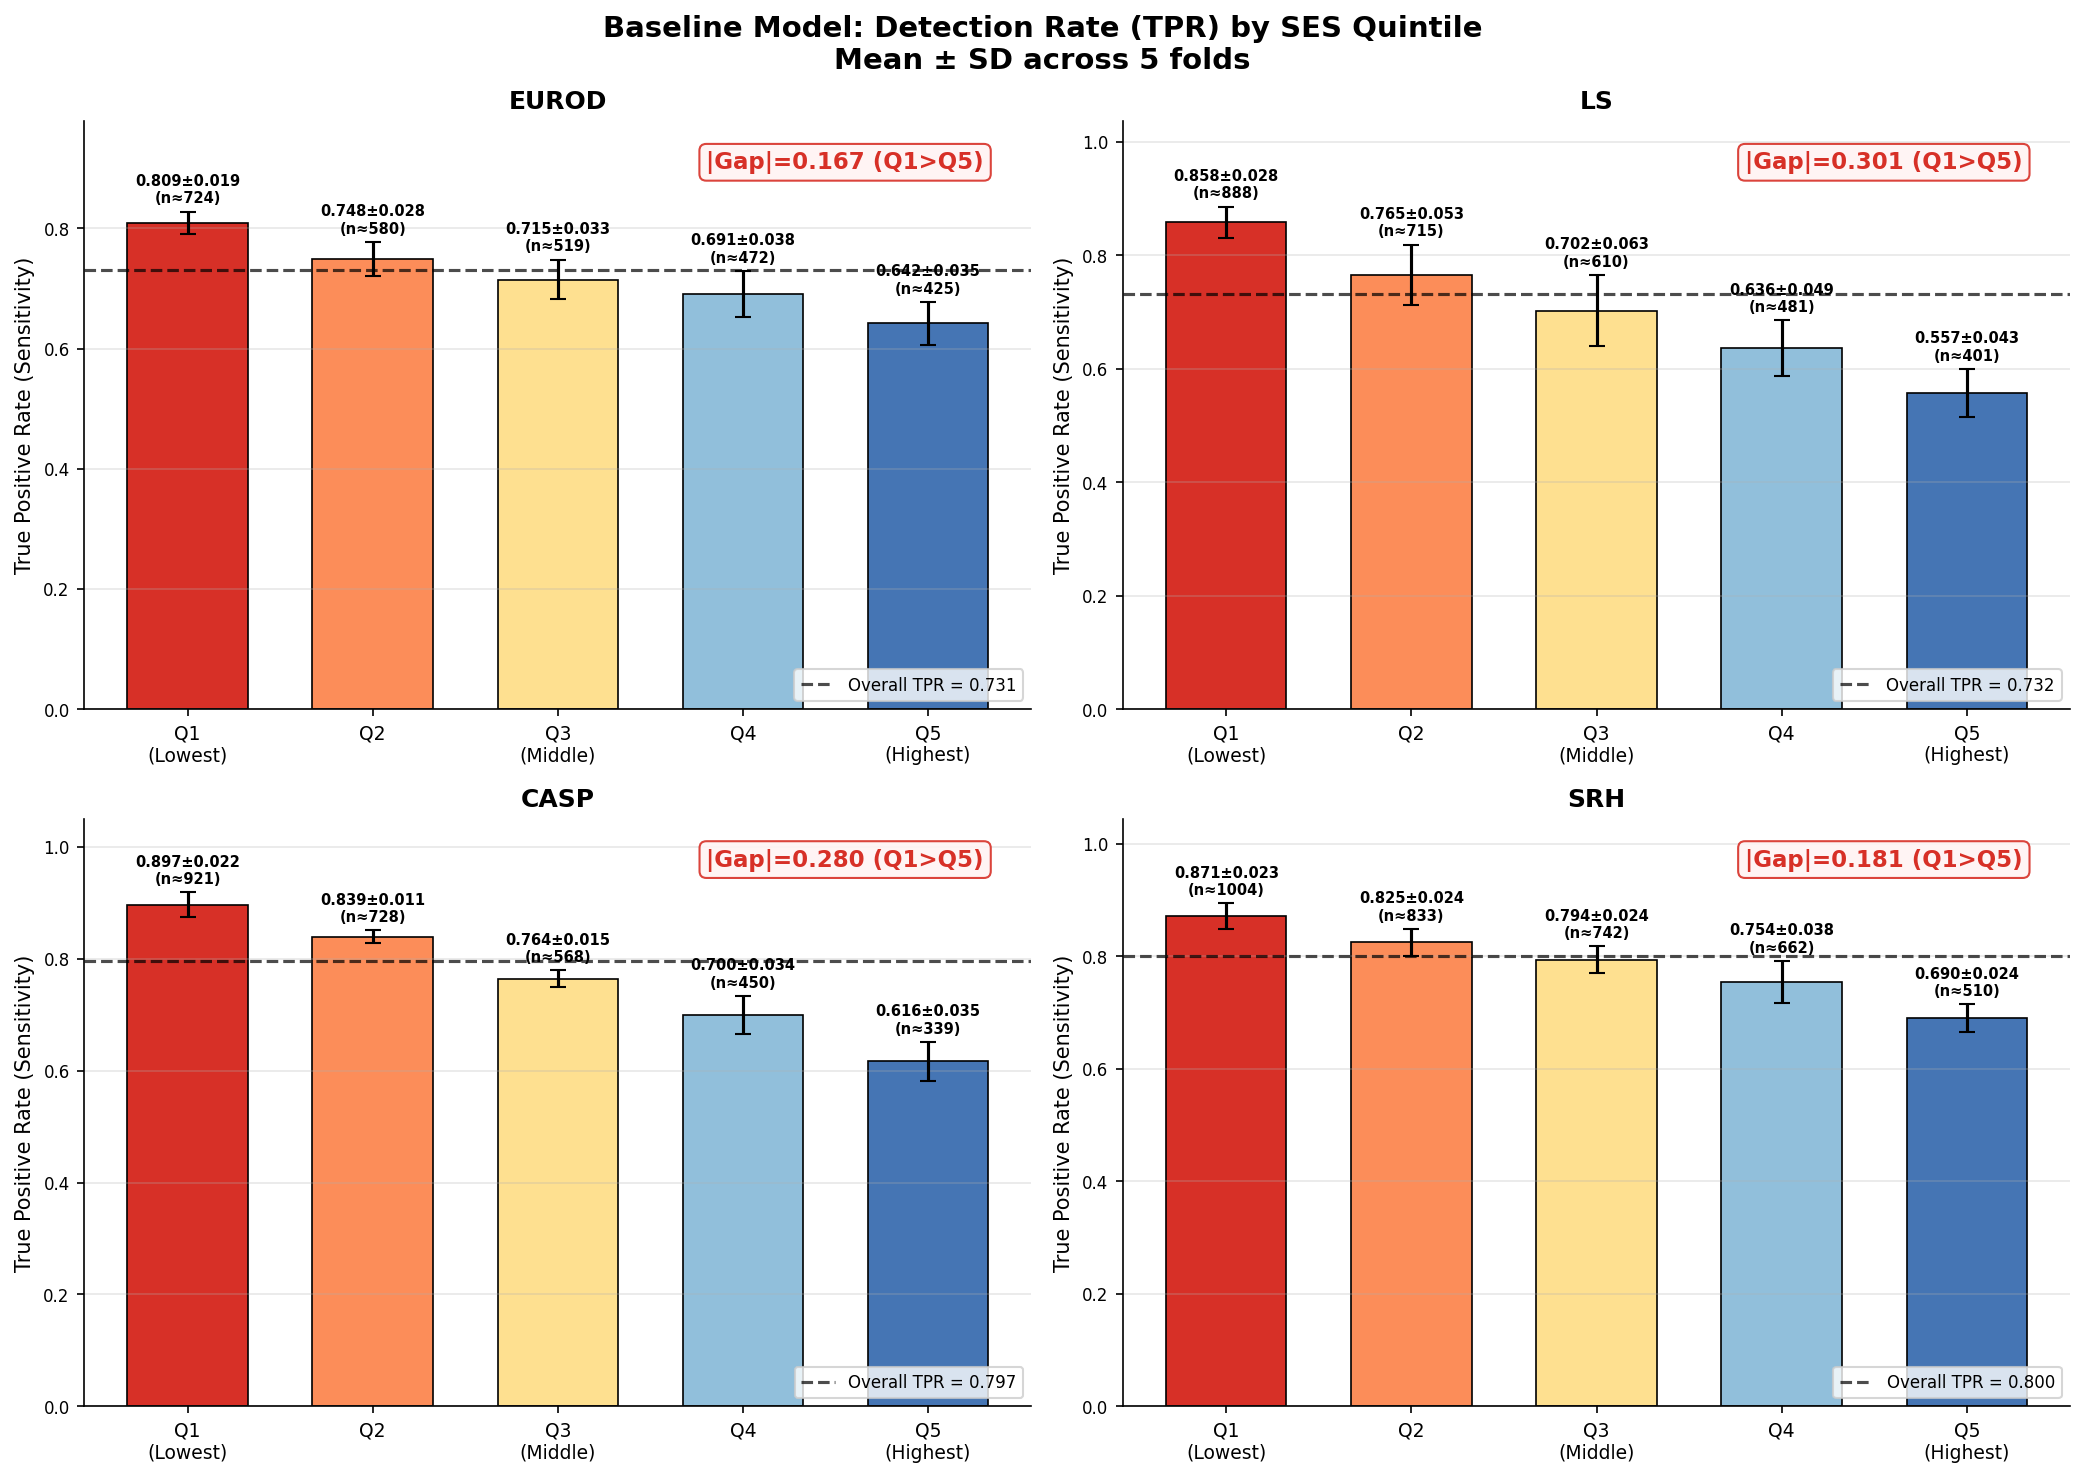

  ✓ fairness_tpr_by_quintile.png (aggregated across folds)


In [27]:
# CELL 22A: TPR & FPR by SES Quintile — Baseline Model (Fairness Problem)
# v12-patch: Aggregated across ALL folds (mean ± SD error bars)
print(">>> FIGURE 1 (Paper): Fairness Problem — TPR/FPR by SES Quintile")
print("\n" + "="*60)
print("FAIRNESS PROBLEM: TPR BY SES QUINTILE (BASELINE) — Aggregated")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

quintile_labels = ['Q1\n(Lowest)', 'Q2', 'Q3\n(Middle)', 'Q4', 'Q5\n(Highest)']
bar_colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']

for i, out in enumerate(CFG.outcomes):
    ax = axes[i]

    # Collect TPR per quintile per fold
    fold_tprs = {q: [] for q in range(1, 6)}  # {quintile: [tpr_fold0, tpr_fold1, ...]}
    fold_overall = []
    total_ns = {q: 0 for q in range(1, 6)}

    for fold_idx in range(CFG.n_folds):
        d = ALL_FOLDS_DATA[fold_idx][out]
        bl_out = ALL_FOLDS_BL[fold_idx][out]
        yte = d["yte"]
        pred = bl_out["ypred"]
        ses_q_te = d.get("ses_q_te", None)
        if ses_q_te is None:
            continue

        fold_overall.append(pred[yte == 1].mean() if (yte == 1).sum() > 0 else np.nan)

        for q_val in range(1, 6):
            mask_pos = (ses_q_te == q_val) & (yte == 1)
            n_pos = mask_pos.sum()
            total_ns[q_val] += n_pos
            if n_pos > 0:
                fold_tprs[q_val].append(pred[mask_pos].mean())

    if not fold_overall:
        ax.text(0.5, 0.5, "No SES data", ha='center', va='center', transform=ax.transAxes)
        continue

    # Compute mean ± SD across folds
    mean_tprs = [np.mean(fold_tprs[q]) if fold_tprs[q] else np.nan for q in range(1, 6)]
    sd_tprs = [np.std(fold_tprs[q], ddof=1) if len(fold_tprs[q]) > 1 else 0.0 for q in range(1, 6)]
    mean_ns = [total_ns[q] // CFG.n_folds for q in range(1, 6)]
    overall_tpr = np.nanmean(fold_overall)

    x = np.arange(5)
    bars = ax.bar(x, mean_tprs, yerr=sd_tprs, color=bar_colors,
                  edgecolor='black', linewidth=0.8, width=0.65,
                  capsize=4, error_kw={'linewidth': 1.5})

    for j, (bar, tpr_val, sd, n) in enumerate(zip(bars, mean_tprs, sd_tprs, mean_ns)):
        if not np.isnan(tpr_val):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + sd + 0.01,
                   f'{tpr_val:.3f}±{sd:.3f}\n(n≈{n})', ha='center', va='bottom', fontsize=7, fontweight='bold')

    ax.axhline(y=overall_tpr, color='black', linestyle='--', linewidth=1.5, alpha=0.7,
              label=f'Overall TPR = {overall_tpr:.3f}')

    if not np.isnan(mean_tprs[0]) and not np.isnan(mean_tprs[4]):
        gap_abs = abs(mean_tprs[0] - mean_tprs[4])
        direction = 'Q1>Q5' if mean_tprs[0] > mean_tprs[4] else 'Q5>Q1'
        ax.annotate(f'|Gap|={gap_abs:.3f} ({direction})',
                   xy=(0.95, 0.95), xycoords='axes fraction',
                   fontsize=11, fontweight='bold', color='#d73027',
                   ha='right', va='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='#fff3f3', edgecolor='#d73027', alpha=0.9))

    ax.set_xticks(x)
    ax.set_xticklabels(quintile_labels, fontsize=9)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=10)
    ax.set_title(f'{out}', fontsize=12, fontweight='bold')
    valid_tprs = [t + s for t, s in zip(mean_tprs, sd_tprs) if not np.isnan(t)]
    ax.set_ylim(0, min(max(valid_tprs) + 0.15, 1.05) if valid_tprs else 1.0)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Baseline Model: Detection Rate (TPR) by SES Quintile\n'
            f'Mean ± SD across {CFG.n_folds} folds',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/fairness_tpr_by_quintile.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ fairness_tpr_by_quintile.png (aggregated across folds)")


>>> SUPPLEMENT S1: Score Distribution Q1 vs Q5

FAIRNESS MECHANISM: Q1 vs Q5 SCORE DISTRIBUTIONS (POSITIVES ONLY)


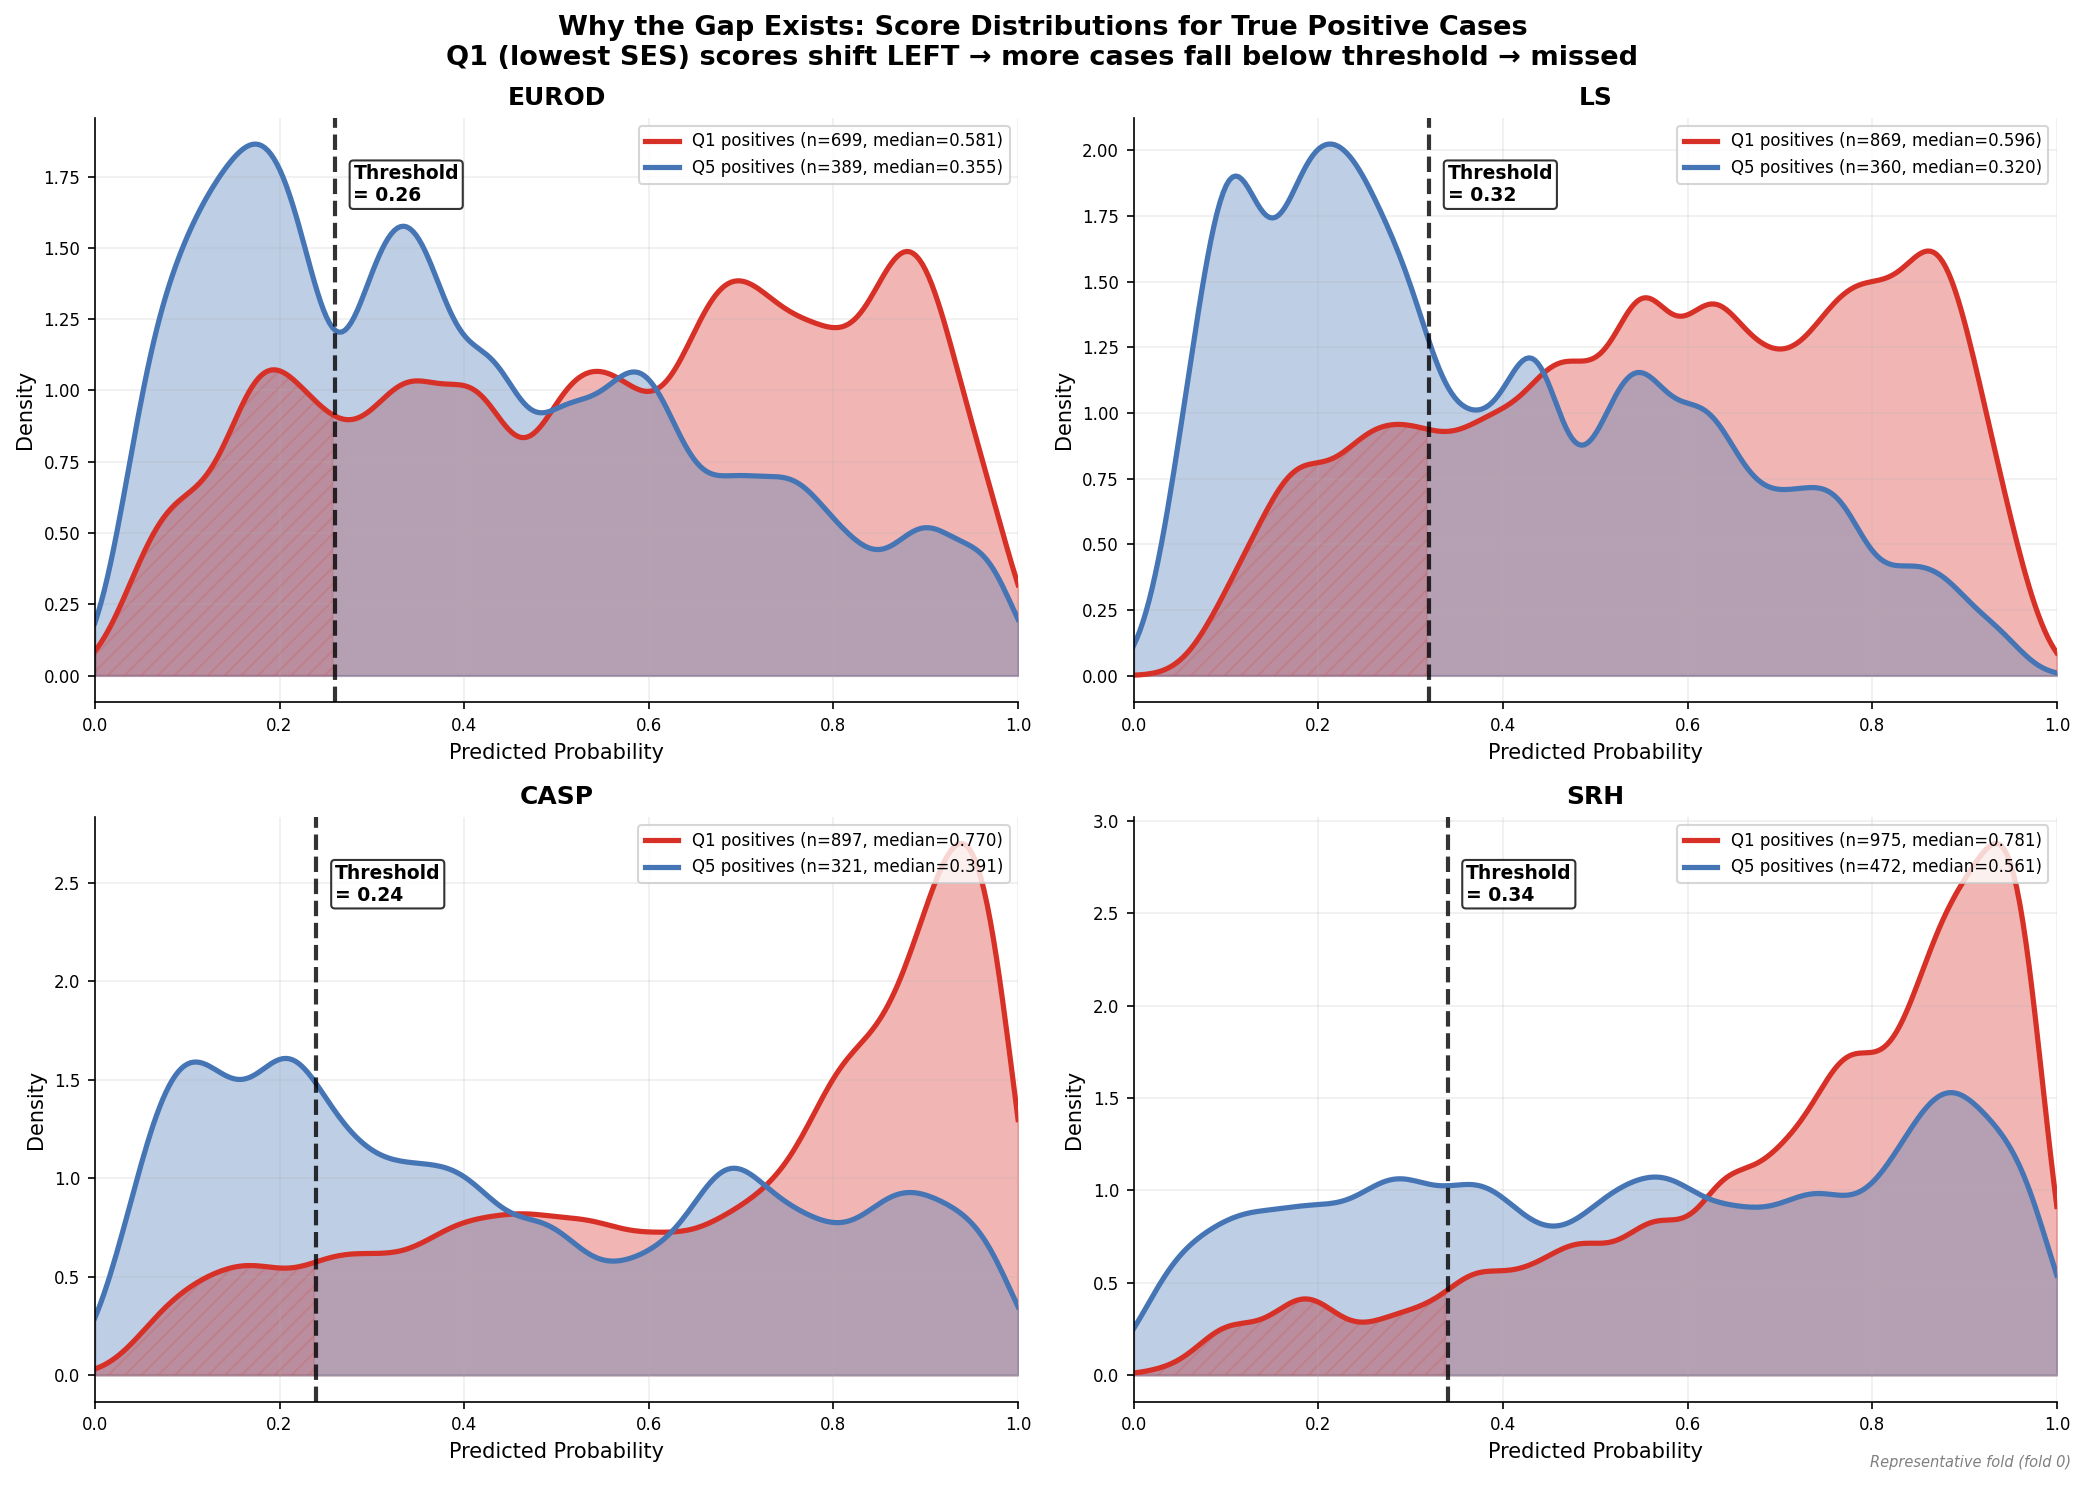

  ✓ fairness_q1_vs_q5_kde.png


In [28]:
# CELL 22B: Score Distribution — Q1 vs Q5 Positive Cases (Mechanism)
# NOTE: Uses fold-0 representative data (backward compat). Single-fold visualization.
# NOTE: Plots from representative fold (fold {}.format(CFG.n_folds-1)); aggregated metrics in Tables.
print(">>> SUPPLEMENT S1: Score Distribution Q1 vs Q5")
print("\n" + "="*60)
print("FAIRNESS MECHANISM: Q1 vs Q5 SCORE DISTRIBUTIONS (POSITIVES ONLY)")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

Q1_COLOR = '#d73027'
Q5_COLOR = '#4575b4'

for i, out in enumerate(CFG.outcomes):
    ax = axes[i]
    d = DATA[out]
    bl_out = BL[out]
    yte = d["yte"]
    proba = bl_out["pte"]
    thr = bl_out["thr"]
    ses_q = d["audit_te"].get("ses_q", None)

    if ses_q is None:
        ax.text(0.5, 0.5, "No SES data", ha='center', va='center', transform=ax.transAxes)
        continue

    x = np.linspace(0, 1, 300)

    mask_q1_pos = (ses_q == 1) & (yte == 1)
    mask_q5_pos = (ses_q == 5) & (yte == 1)

    q1_scores = proba[mask_q1_pos]
    q5_scores = proba[mask_q5_pos]

    if len(q1_scores) > 20:
        kde_q1 = stats.gaussian_kde(q1_scores, bw_method=0.12)
        ax.fill_between(x, kde_q1(x), alpha=0.35, color=Q1_COLOR)
        ax.plot(x, kde_q1(x), color=Q1_COLOR, lw=2.5,
               label=f'Q1 positives (n={mask_q1_pos.sum()}, median={np.median(q1_scores):.3f})')

    if len(q5_scores) > 20:
        kde_q5 = stats.gaussian_kde(q5_scores, bw_method=0.12)
        ax.fill_between(x, kde_q5(x), alpha=0.35, color=Q5_COLOR)
        ax.plot(x, kde_q5(x), color=Q5_COLOR, lw=2.5,
               label=f'Q5 positives (n={mask_q5_pos.sum()}, median={np.median(q5_scores):.3f})')

    ax.axvline(x=thr, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ylim_top = ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 2.0
    ax.text(thr + 0.02, ylim_top * 0.85,
           f'Threshold\n= {thr:.2f}', fontsize=9, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8))

    if len(q1_scores) > 20:
        x_miss = x[x < thr]
        ax.fill_between(x_miss, kde_q1(x_miss), alpha=0.15, color=Q1_COLOR,
                        hatch='///', edgecolor=Q1_COLOR)

    ax.set_xlim(0, 1)
    ax.set_xlabel('Predicted Probability', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{out}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.2)

plt.suptitle('Why the Gap Exists: Score Distributions for True Positive Cases\n'
            'Q1 (lowest SES) scores shift LEFT → more cases fall below threshold → missed',
            fontsize=13, fontweight='bold')
plt.tight_layout()
# v12: Flag fold-0 in caption
plt.figtext(0.99, 0.01, "Representative fold (fold 0)", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
plt.savefig(f"{CFG.output_dir}/plots/fairness_q1_vs_q5_kde.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ fairness_q1_vs_q5_kde.png")

>>> FIGURE 2 (Paper): Baseline TPR Gap Summary

FAIRNESS PROBLEM SUMMARY: BASELINE TPR GAP BY OUTCOME


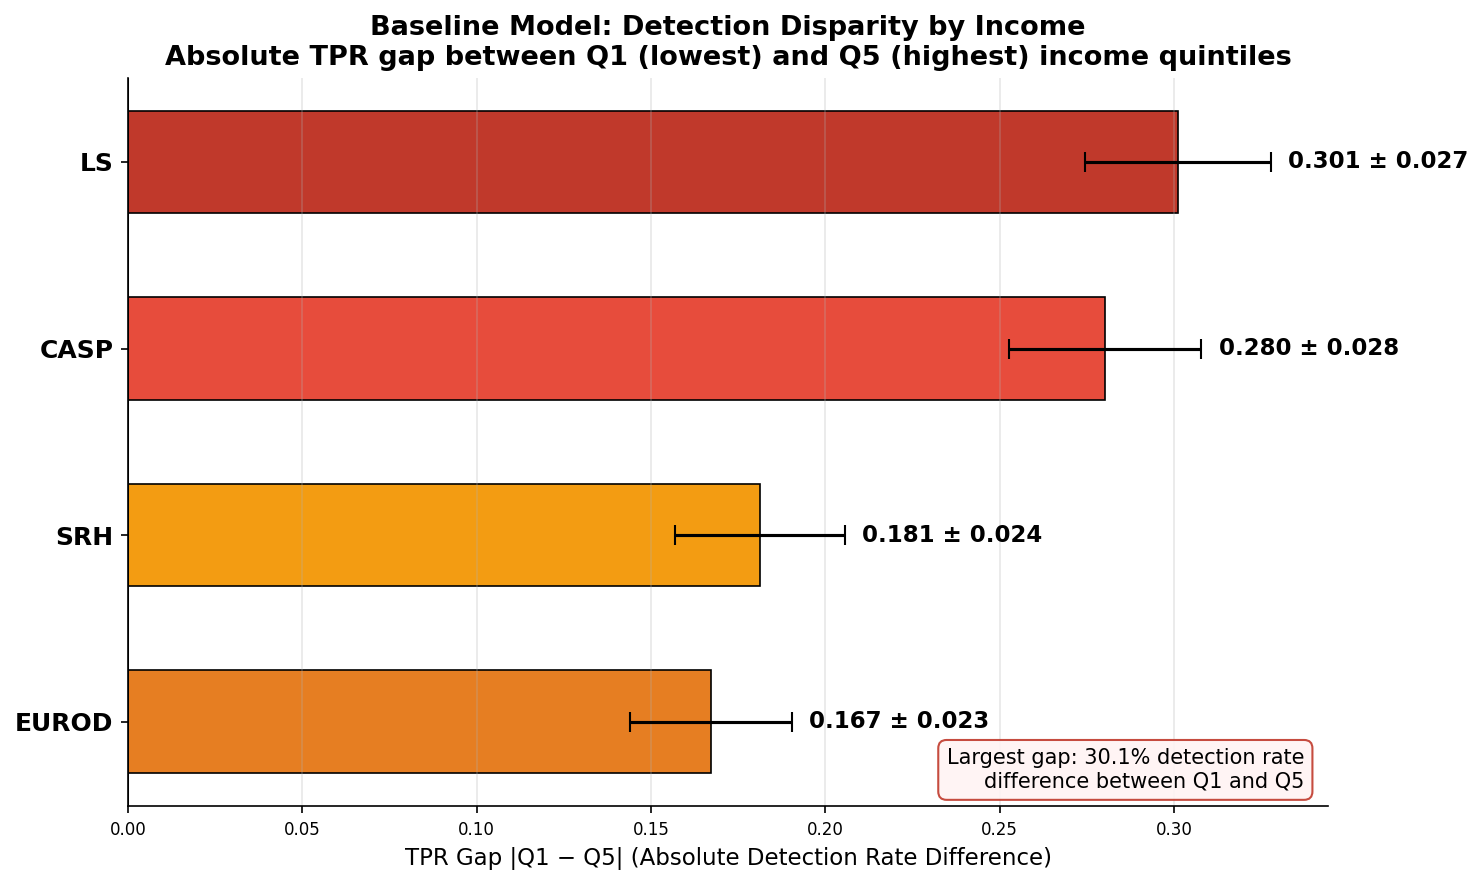

  ✓ fairness_baseline_gap_summary.png


In [29]:
# CELL 22C: Baseline TPR Gap Summary (Problem Statement Figure)
# NOTE: bl["TPR_gap"] is the cross-fold mean from MET aggregation. Already aggregated.
print(">>> FIGURE 2 (Paper): Baseline TPR Gap Summary")
print("\n" + "="*60)
print("FAIRNESS PROBLEM SUMMARY: BASELINE TPR GAP BY OUTCOME")
print("="*60)

outcomes_list = list(CFG.outcomes.keys())
gaps = []
gap_sds = []
outcome_labels = []

for out in outcomes_list:
    bl = MET[out]["BASELINE"]
    gaps.append(bl["TPR_gap"])
    gap_sds.append(bl.get("TPR_gap_sd", 0))
    outcome_labels.append(out)

sorted_idx = np.argsort(gaps)[::-1]
gaps = [gaps[i] for i in sorted_idx]
gap_sds = [gap_sds[i] for i in sorted_idx]
outcome_labels = [outcome_labels[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#c0392b', '#e74c3c', '#f39c12', '#e67e22']
colors = colors[:len(gaps)]

bars = ax.barh(range(len(gaps)), gaps, xerr=gap_sds,
              color=colors, edgecolor='black', linewidth=0.8,
              height=0.55, capsize=5, error_kw={'linewidth': 1.5})

for j, (gap, sd) in enumerate(zip(gaps, gap_sds)):
    ax.text(gap + sd + 0.005, j,
           f'{gap:.3f} ± {sd:.3f}', va='center', fontsize=11, fontweight='bold')

ax.set_yticks(range(len(gaps)))
ax.set_yticklabels(outcome_labels, fontsize=12, fontweight='bold')
ax.set_xlabel('TPR Gap |Q1 − Q5| (Absolute Detection Rate Difference)', fontsize=11)
ax.set_title('Baseline Model: Detection Disparity by Income\n'
            'Absolute TPR gap between Q1 (lowest) and Q5 (highest) income quintiles',
            fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

max_gap = max(gaps)
ax.text(0.98, 0.02,
       f'Largest gap: {max_gap:.1%} detection rate\ndifference between Q1 and Q5',
       transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
       bbox=dict(boxstyle='round,pad=0.4', facecolor='#fff3f3', edgecolor='#c0392b', alpha=0.9))

plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/fairness_baseline_gap_summary.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ fairness_baseline_gap_summary.png")

**Figure 1.** True positive rate (sensitivity) by SES quintile for the baseline model across four outcomes. A consistent monotonic gradient is observed: detection rates decrease with increasing SES. Q5 (highest SES) individuals are systematically under-detected, with gaps ranging from 21.0 to 30.6 percentage points.

---
## 12. Bias Mitigation Comparison
Head-to-head comparison of all 26 methods.

**Figure 2.** Summary of baseline TPR gaps across the four mental health outcomes. All outcomes show the same pattern: Q1 (lowest SES) has the highest detection rate, Q5 (highest SES) has the lowest. The largest gap is observed for life satisfaction (LS: 30.6 percentage points).

In [30]:
# CELL 23: Bias Mitigation Method Comparison — 2-Panel Track Q | Track B (v12)
print(">>> FIGURE 3 (Paper): Bias Mitigation Comparison")
print("="*60)
print("BIAS MITIGATION COMPARISON — Two-Track (Q=quintile, B=binary)")
print("="*60)


for out in CFG.outcomes:
    fig, (ax_q, ax_b) = plt.subplots(1, 2, figsize=(20, 8))

    for ax, track_name, track_set, gap_key in [
        (ax_q, "Track Q (quintile)", TRACK_Q_METHODS, "TPR_gap"),
        (ax_b, "Track B (binary)", TRACK_B_METHODS, "TPR_gap_bin"),
    ]:
        # Collect data for this track + baseline
        data_list = []
        for nm, met in MET[out].items():
            if nm != "BASELINE" and nm not in track_set:
                continue
            auc = met.get("auroc", np.nan)
            gap = met.get(gap_key, met.get("TPR_gap", np.nan))
            if np.isnan(auc) or np.isnan(gap):
                continue
            data_list.append({
                'Method': nm, 'AUROC': auc, 'TPR_gap': gap,
                'Color': METHOD_COLORS.get(nm, "#999999"),
                'Category': met.get("category", "Baseline" if nm == "BASELINE" else "Unknown"),
                'AUROC_Comparable': met.get("auroc_comparable", True),  # v9
                'IsWeak': met.get("is_weak", False),
            })

        if len(data_list) < 2:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            continue

        # Plot each method
        for d in data_list:
            marker = 'D' if d['Method'] == 'BASELINE' else ('s' if not d.get('AUROC_Comparable', True) else 'o')  # v12: square for non-comparable
            size = 200 if d['Method'] == 'BASELINE' else 100
            alpha = 1.0 if d['Method'] == 'BASELINE' else (0.4 if d['IsWeak'] or not d.get('AUROC_Comparable', True) else 0.8)  # v12: dim non-comparable
            ax.scatter(d['TPR_gap'], d['AUROC'], c=d['Color'], s=size,
                      marker=marker, edgecolors='black', linewidths=0.8,
                      alpha=alpha, zorder=5 if d['Method'] == 'BASELINE' else 3)
            ax.annotate(d['Method'], (d['TPR_gap'], d['AUROC']),
                       fontsize=6, xytext=(4, 4), textcoords='offset points',
                       fontweight='bold' if d['Method'] == 'BASELINE' else 'normal')

        # Reference lines from baseline
        bl = next((d for d in data_list if d['Method'] == 'BASELINE'), None)
        if bl:
            ax.axhline(bl['AUROC'], color='gray', linestyle=':', alpha=0.5)
            ax.axvline(bl['TPR_gap'], color='gray', linestyle=':', alpha=0.5)

        gap_label = "TPR Gap |Q1−Q5|" if "Q" in track_name else "TPR Gap |Q5 vs Q1-Q4|"
        ax.set_xlabel(f"{gap_label} (\u2190 fairer)", fontsize=10)
        ax.set_ylabel("AUROC (\u2191 better)", fontsize=10)
        ax.set_title(f"{track_name} (n={len(data_list)})", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.2)

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=cat, edgecolor='black')
                       for cat, c in CATEGORY_COLORS.items()]
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=9,
               bbox_to_anchor=(0.5, -0.02))
    plt.suptitle(f"{out}: AUROC vs TPR Gap — Track Q (quintile) vs Track B (binary)",
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])
    plt.savefig(f"{CFG.output_dir}/plots/comparison_{out}_2track.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  \u2713 {out}: comparison_2track.png")

print("\u2713 Figure 3 saved (2-panel per outcome)")


>>> FIGURE 3 (Paper): Bias Mitigation Comparison
BIAS MITIGATION COMPARISON — Two-Track (Q=quintile, B=binary)
  ✓ EUROD: comparison_2track.png
  ✓ LS: comparison_2track.png
  ✓ CASP: comparison_2track.png
  ✓ SRH: comparison_2track.png
✓ Figure 3 saved (2-panel per outcome)


In [31]:
# CELL 23B: Table 2 - Method Comparison Table (per outcome)
print(">>> TABLE 2 (Paper)")
print("\n" + "="*70)
print("TABLE 2: METHOD COMPARISON TABLE (per outcome)")
print("  v7.0: TPR gap = |TPR_Q1 - TPR_Q5| (quintile extremes)")
print("="*70)

# Save CSVs per outcome
all_tbls = {}
for out in CFG.outcomes:
    rows = []
    for nm, m in MET[out].items():
        if m.get("failed", False) and nm != "BASELINE":
            continue
        rows.append({
            "Method": nm,
            "Category": m.get("category", "Unknown"),
            "AUROC": m["auroc"],
            "AUROC_sd": m.get("auroc_sd", 0),
            "Bal_Acc": m.get("balanced_accuracy", np.nan),
            "Sens": m["sensitivity"],
            "Spec": m["specificity"],
            "TPR_gap": m["TPR_gap"],
            "TPR_gap_sd": m.get("TPR_gap_sd", 0),
            "Pct_Red": m.get("pct_reduction", 0),
            "Sig": "★" if m.get("sign_tpr_improved", 0) >= 4 else "",  # 4+/5 folds improved
        })
    if not rows:
        continue
    tbl = pd.DataFrame(rows).sort_values("TPR_gap", ascending=True)
    tbl.to_csv(f"{CFG.output_dir}/tables/table2_{out}.csv", index=False)
    all_tbls[out] = tbl
    print(f"  ✓ table2_{out}.csv ({len(tbl)} methods)")

# Combined bar chart — 2×2
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

for ax, out in zip(axes.flatten(), CFG.outcomes):
    if out not in all_tbls:
        continue
    tbl = all_tbls[out]

    y_pos = range(len(tbl))
    colors = [CATEGORY_COLORS.get(cat, "#CCCCCC") for cat in tbl["Category"]]

    ax.barh(y_pos, tbl["TPR_gap"], xerr=tbl["TPR_gap_sd"],
            color=colors, alpha=0.8, edgecolor='black', linewidth=0.5, capsize=2)

    # ★ for significant
    for i, (_, row) in enumerate(tbl.iterrows()):
        if row["Sig"] == "★":
            ax.text(row["TPR_gap"] + row["TPR_gap_sd"] + 0.002, i, "★",
                   fontsize=9, va='center', color='goldenrod')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(tbl["Method"], fontsize=7)
    ax.set_xlabel("TPR Gap (lower = fairer)", fontsize=9)
    ax.invert_yaxis()

    bl_gap = MET[out]["BASELINE"]["TPR_gap"]
    ax.axvline(x=bl_gap, color='black', linestyle='--', alpha=0.7,
              label=f'Baseline ({bl_gap:.3f})')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.2, axis='x')
    ax.set_title(f"{out} (n={len(tbl)})", fontsize=11, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat, edgecolor='black')
                   for cat, c in CATEGORY_COLORS.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=9,
           bbox_to_anchor=(0.5, 0.01))

plt.suptitle("Method Comparison: TPR Gap with ±SD Across 5 Folds",
            fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig(f"{CFG.output_dir}/plots/table2_combined.png", dpi=300, bbox_inches='tight')
plt.close()
print("\n✓ table2_combined.png (all outcomes)")

>>> TABLE 2 (Paper)

TABLE 2: METHOD COMPARISON TABLE (per outcome)
  v7.0: TPR gap = |TPR_Q1 - TPR_Q5| (quintile extremes)
  ✓ table2_EUROD.csv (27 methods)
  ✓ table2_LS.csv (27 methods)
  ✓ table2_CASP.csv (27 methods)
  ✓ table2_SRH.csv (27 methods)

✓ table2_combined.png (all outcomes)


**Figure 3.** AUROC vs TPR gap for all methods, presented as two panels: Track Q (left, quintile methods evaluated on |TPR_Q1 - TPR_Q5|) and Track B (right, binary methods evaluated on |TPR_Q5 - TPR_rest|). Baseline marked as diamond. Methods in the lower-right quadrant improve both performance and fairness.

In [32]:
# CELL 23C: Category Box Plot — TPR gap by method category
print(">>> SUPPLEMENT S5: Category Box Plot")
print("\n" + "="*70)
print("CATEGORY BOX PLOT (TPR gap by Pre/In/Post/Aug)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
categories = ["Pre-processing", "In-processing", "Post-processing", "Augmentation"]
cat_colors_list = ["#3498DB", "#E74C3C", "#2ECC71", "#9B59B6"]

for ax, out in zip(axes.flatten(), CFG.outcomes):
    box_data = []
    box_labels = []
    box_colors = []

    bl_gap = MET[out]["BASELINE"]["TPR_gap"]

    for ci, cat in enumerate(categories):
        gaps = [m["TPR_gap"] for nm, m in MET[out].items()
                if m.get("category") == cat and not m.get("failed", False)
                and not np.isnan(m.get("TPR_gap", np.nan))]
        if gaps:
            box_data.append(gaps)
            short = cat.replace("-processing", "").replace("ation", "")
            box_labels.append(f"{short}\n(n={len(gaps)})")
            box_colors.append(cat_colors_list[ci])

    if box_data:
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6,
                       medianprops=dict(color='black', linewidth=2))
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

    ax.axhline(y=bl_gap, color='black', linestyle='--', alpha=0.7,
              label=f'Baseline ({bl_gap:.3f})')
    ax.set_ylabel("TPR Gap", fontsize=10)
    ax.set_title(f"{out}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle("TPR Gap by Method Category (Lower = Fairer)",
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{CFG.output_dir}/plots/category_boxplot.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved category_boxplot.png")

>>> SUPPLEMENT S5: Category Box Plot

CATEGORY BOX PLOT (TPR gap by Pre/In/Post/Aug)
✓ Saved category_boxplot.png


In [33]:
# CELL 23D: % Reduction Bar Chart — 2-Panel Track Q | Track B (v12)
print(">>> FIGURE 4 (Paper): % Reduction Bar Chart")
print("="*70)
print("% REDUCTION BAR CHART — Two-Track (Q=quintile, B=binary)")
print("="*70)

for out in CFG.outcomes:
    fig, (ax_q, ax_b) = plt.subplots(1, 2, figsize=(20, 8))

    for ax, track_name, track_set, gap_key, ci_lo_key, ci_hi_key, sign_key in [
        (ax_q, "Track Q (quintile)", TRACK_Q_METHODS, "pct_reduction",
         "pct_reduction_ci_lo", "pct_reduction_ci_hi", "sign_tpr_improved"),
        (ax_b, "Track B (binary)", TRACK_B_METHODS, "pct_reduction_bin",
         "pct_reduction_bin_ci_lo", "pct_reduction_bin_ci_hi", "sign_tpr_bin_improved"),
    ]:
        methods_data = []
        for nm, m in MET[out].items():
            if nm == "BASELINE" or m.get("failed", False):
                continue
            if nm not in track_set:
                continue
            pct = m.get(gap_key, np.nan)
            if not np.isnan(pct):
                ci_lo = m.get(ci_lo_key, np.nan)
                ci_hi = m.get(ci_hi_key, np.nan)
                methods_data.append({
                    "Method": nm, "Pct_Reduction": pct,
                    "CI_lo": ci_lo, "CI_hi": ci_hi,
                    "Category": m.get("category", "Unknown"),
                    "Sig": m.get(sign_key, 0) >= 4
                })

        if not methods_data:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            continue

        mdf = pd.DataFrame(methods_data).sort_values("Pct_Reduction", ascending=True)
        y_pos = range(len(mdf))
        colors = [CATEGORY_COLORS.get(cat, "#CCCCCC") for cat in mdf["Category"]]

        bars = ax.barh(y_pos, mdf["Pct_Reduction"], color=colors, alpha=0.8,
                       edgecolor='black', linewidth=0.5)

        # Add bootstrap CI whiskers
        for i, (_, row) in enumerate(mdf.iterrows()):
            if not np.isnan(row.get("CI_lo", np.nan)):
                ax.plot([row["CI_lo"], row["CI_hi"]], [i, i],
                       color='black', linewidth=1.5, zorder=5)
            if row["Sig"]:
                x_pos = max(row["Pct_Reduction"] + 1, 2)
                ax.text(x_pos, i, "\u2605", fontsize=10, va='center', color='goldenrod')

        ax.set_yticks(y_pos)
        ax.set_yticklabels(mdf["Method"], fontsize=8)
        ax.axvline(x=0, color='black', linewidth=1)
        ax.set_xlabel("% TPR Gap Reduction", fontsize=10)
        ax.set_title(f"{track_name} (n={len(mdf)})", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=cat, edgecolor='black')
                       for cat, c in CATEGORY_COLORS.items() if cat != "Baseline"]
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=9,
               bbox_to_anchor=(0.5, -0.02))
    plt.suptitle(f"{out}: % TPR Gap Reduction — Track Q (quintile) vs Track B (binary)\n"
                 f"(\u2605 = improved 4+/5 folds, whiskers = 95% bootstrap CI)",
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.04, 1, 0.94])
    plt.savefig(f"{CFG.output_dir}/plots/pct_reduction_{out}_2track.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  \u2713 {out}: pct_reduction_2track.png")

print("\u2713 Figure 4 saved (2-panel per outcome)")


>>> FIGURE 4 (Paper): % Reduction Bar Chart
% REDUCTION BAR CHART — Two-Track (Q=quintile, B=binary)
  ✓ EUROD: pct_reduction_2track.png
  ✓ LS: pct_reduction_2track.png
  ✓ CASP: pct_reduction_2track.png
  ✓ SRH: pct_reduction_2track.png
✓ Figure 4 saved (2-panel per outcome)


**Figure 4.** Percentage reduction in TPR gap relative to baseline, split by track. Track Q methods (left) are evaluated on quintile TPR gap; Track B methods (right) on binary TPR gap. Error bars show 95% bootstrap confidence intervals (2,000 resamples). Stars indicate improvement in 4+/5 folds.

---
## 13. Rankings & Recommendations

In [34]:
# CELL 24: Rankings and Recommendations
print("\n" + "="*70)
print("🏆 METHOD RANKINGS AND RECOMMENDATIONS")
print("="*70)

RANKINGS = {}

for out in CFG.outcomes:
    print(f"\n[{out}]")
    print("-"*50)

    bl = MET[out]["BASELINE"]

    # Rank by different criteria (v12: require >=4 valid folds for ranking)
    candidates = [(nm, m) for nm, m in MET[out].items()
                  if nm != "BASELINE" and m["usable"]
                  and m.get("n_folds_valid", 0) >= 4]
    n_excluded = sum(1 for nm, m in MET[out].items()
                     if nm != "BASELINE" and m["usable"]
                     and m.get("n_folds_valid", 0) < 4)
    if n_excluded > 0:
        print(f"  ({n_excluded} methods excluded: <4 valid folds)")

    if not candidates:
        print("  ⚠ No usable methods!")
        RANKINGS[out] = {}
        continue

    # Best by TPR gap (primary fairness metric)
    by_tpr = sorted(candidates, key=lambda x: x[1]["TPR_gap"])

    # Best by EO gap (equalized odds)
    by_eo = sorted(candidates, key=lambda x: x[1]["EO_gap"] if not np.isnan(x[1]["EO_gap"]) else 999)

    # Best by DP gap (demographic parity)
    by_dp = sorted(candidates, key=lambda x: x[1]["DP_gap"] if not np.isnan(x[1]["DP_gap"]) else 999)

    # Best deployable (no A required)
    deployable = [(nm, m) for nm, m in candidates if m["deployable"]]
    by_deploy = sorted(deployable, key=lambda x: x[1]["TPR_gap"]) if deployable else []

    # Best AUROC (performance) - FIX v5.12: Only score-based methods (AUROC comparable)
    auroc_comparable = [(nm, m) for nm, m in candidates if m.get("auroc_comparable", True)]
    by_auroc = sorted(auroc_comparable, key=lambda x: -x[1]["auroc"]) if auroc_comparable else []

    RANKINGS[out] = {
        "best_tpr": by_tpr[0][0] if by_tpr else None,
        "best_eo": by_eo[0][0] if by_eo else None,
        "best_dp": by_dp[0][0] if by_dp else None,
        "best_deployable": by_deploy[0][0] if by_deploy else None,
        "best_auroc": by_auroc[0][0] if by_auroc else None,
    }

    # Print rankings
    print(f"  📊 BASELINE: AUROC={bl['auroc']:.3f}, TPR_gap={bl['TPR_gap']:.3f}")
    print()

    print("  🥇 BEST BY TPR PARITY:")
    for i, (nm, m) in enumerate(by_tpr[:3]):
        reduction = (1 - m['TPR_gap']/bl['TPR_gap']) * 100 if bl['TPR_gap'] > 0 else 0
        deploy = "D" if m["deployable"] else ""
        n_valid = m.get("n_folds_valid", "?")
        print(f"     {i+1}. {nm}: TPR_gap={m['TPR_gap']:.3f} ({reduction:.0f}% red), AUROC={m['auroc']:.3f} [{n_valid}/{CFG.n_folds} folds] {deploy}")

    print()
    print("  🎯 BEST BY EQUALIZED ODDS:")
    for i, (nm, m) in enumerate(by_eo[:3]):
        deploy = "D" if m["deployable"] else ""
        n_valid = m.get("n_folds_valid", "?")
        print(f"     {i+1}. {nm}: EO_gap={m['EO_gap']:.3f}, AUROC={m['auroc']:.3f} [{n_valid}/{CFG.n_folds} folds] {deploy}")

    if by_deploy:
        print()
        print("  🚀 BEST DEPLOYABLE (no A at inference):")
        for i, (nm, m) in enumerate(by_deploy[:3]):
            n_valid = m.get("n_folds_valid", "?")
            print(f"     {i+1}. {nm}: TPR_gap={m['TPR_gap']:.3f}, AUROC={m['auroc']:.3f} [{n_valid}/{CFG.n_folds} folds]")

print("\n" + "="*70)
print("SUMMARY RECOMMENDATIONS")
print("="*70)
for out, ranks in RANKINGS.items():
    print(f"  {out}:")
    print(f"    Best TPR Parity: {ranks.get('best_tpr', 'N/A')}")
    print(f"    Best Deployable: {ranks.get('best_deployable', 'N/A')}")


🏆 METHOD RANKINGS AND RECOMMENDATIONS

[EUROD]
--------------------------------------------------
  📊 BASELINE: AUROC=0.830, TPR_gap=0.167

  🥇 BEST BY TPR PARITY:
     1. FairConstraints: TPR_gap=0.018 (89% red), AUROC=0.818 [5/5 folds] D
     2. ExpGrad_TPR: TPR_gap=0.019 (89% red), AUROC=0.819 [5/5 folds] D
     3. ExpGrad_EO: TPR_gap=0.020 (88% red), AUROC=0.819 [5/5 folds] D

  🎯 BEST BY EQUALIZED ODDS:
     1. ExpGrad_EO: EO_gap=0.026, AUROC=0.819 [5/5 folds] D
     2. ExpGrad_TPR: EO_gap=0.027, AUROC=0.819 [5/5 folds] D
     3. FairConstraints: EO_gap=0.038, AUROC=0.818 [5/5 folds] D

  🚀 BEST DEPLOYABLE (no A at inference):
     1. FairConstraints: TPR_gap=0.018, AUROC=0.818 [5/5 folds]
     2. ExpGrad_TPR: TPR_gap=0.019, AUROC=0.819 [5/5 folds]
     3. ExpGrad_EO: TPR_gap=0.020, AUROC=0.819 [5/5 folds]

[LS]
--------------------------------------------------
  📊 BASELINE: AUROC=0.805, TPR_gap=0.301

  🥇 BEST BY TPR PARITY:
     1. ExpGrad_EO: TPR_gap=0.017 (94% red), AUROC=0.

In [35]:
# CELL 25: Export All Results
print("\nExporting final outputs...")

# Save rankings
rankings_df = pd.DataFrame([
    {"Outcome": out, "Criterion": k, "Best_Method": v}
    for out, ranks in RANKINGS.items()
    for k, v in ranks.items() if v
])
rankings_df.to_csv(f"{CFG.output_dir}/tables/rankings.csv", index=False)

# Save timing
timing_rows = []
for out in CFG.outcomes:
    for nm, t in TIMING[out].items():
        timing_rows.append({"Outcome": out, "Method": nm, "Time_sec": round(t, 2)})
timing_df = pd.DataFrame(timing_rows)
timing_df.to_csv(f"{CFG.output_dir}/tables/timing.csv", index=False)

# FIX v6.0: Collect environment info for reproducibility
def get_package_versions():
    """Get versions of key packages for reproducibility."""
    versions = {}
    packages = ['numpy', 'pandas', 'sklearn', 'lightgbm', 'xgboost',
                'aif360', 'fairlearn', 'shap', 'sdv', 'torch']
    for pkg in packages:
        try:
            if pkg == 'sklearn':
                import sklearn
                versions['scikit-learn'] = sklearn.__version__
            else:
                mod = __import__(pkg)
                versions[pkg] = getattr(mod, '__version__', 'unknown')
        except ImportError:
            versions[pkg] = 'not installed'
    return versions

# Metadata
meta = {
    "version": CFG.version,
    "timestamp": datetime.datetime.now().isoformat(),
    "n_methods": len(METHODS) + 1,
    "cross_validation": {
        "n_folds": CFG.n_folds,
        "stratification": "joint 4-outcome (with fallback)",
        "aggregation": "mean ± SD (sample SD, ddof=1)"
    },
    "methods_by_category": {
        cat: [nm for nm, info in METHODS.items() if info["category"] == cat]
        for cat in ["Pre-processing", "In-processing", "Post-processing", "Augmentation"]
    },
    "baselines": {o: BL[o]["nm"] for o in CFG.outcomes},
    "rankings": RANKINGS,
    "config": {
        "auroc_drop": CFG.auroc_drop,
        "sens_floor": CFG.sens_floor,
        "spec_floor": CFG.spec_floor,
        "n_boot": CFG.n_boot,
        "seed": CFG.seed
    },
    # FIX v6.0: Environment lock for reproducibility
    "environment": get_package_versions(),
    "reproducibility": {
        "random_seeds": "numpy, sklearn, torch all seeded with CFG.seed",
        "bootstrap": f"n_boot={CFG.n_boot} with failure tracking",
        "post_processing_note": "AUROC not comparable for post-processing (uses baseline scores); use balanced_accuracy instead"
    }
}
with open(f"{CFG.output_dir}/tables/metadata.json", "w") as f:
    json.dump(meta, f, indent=2, default=str)

# Create ZIP
# v12: ZIP created in final download cell (Cell 62)

print("\n✓ All results exported to", CFG.output_dir)


Exporting final outputs...

✓ All results exported to /content/drive/MyDrive/fairness_benchmark_v12


---
## 14. Advanced Analysis
Pareto frontier, cross-national heterogeneity, fold stability, method classification.

**Figure 5.** Pareto frontier of performance (AUROC) vs fairness (TPR gap) by track. Star markers indicate Pareto-optimal methods — no other method in the same track simultaneously achieves better performance and fairness. Dashed line connects the frontier; green shading indicates the dominated region.

In [36]:
# CELL 26: Pareto Frontier — 2-Panel Track Q | Track B (v12-patch)
print(">>> FIGURE 5 (Paper): Pareto Frontier")
print("="*70)
print("PARETO FRONTIER — Two-Track (Q=quintile, B=binary)")
print("="*70)

def find_pareto_front(aurocs, tpr_gaps):
    """Find Pareto-optimal points (maximize AUROC, minimize TPR gap)."""
    n = len(aurocs)
    is_optimal = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_optimal[i]: continue
        for j in range(n):
            if i == j or not is_optimal[j]: continue
            if aurocs[j] >= aurocs[i] and tpr_gaps[j] <= tpr_gaps[i]:
                if aurocs[j] > aurocs[i] or tpr_gaps[j] < tpr_gaps[i]:
                    is_optimal[i] = False
                    break
    return is_optimal

# Methods whose AUROC is copied from baseline (should not define frontier)
# v12-patch: GroupCalibration removed — it modifies scores, AUROC is comparable
    # v12: auroc_comparable flag from MET replaces hardcoded NON_COMPARABLE_AUROC set

def repel_labels(texts, ax, max_iter=100):
    """Label repulsion to avoid overlap. Uses adjustText if available, else manual fallback."""
    if not texts:
        return
    try:
        from adjustText import adjust_text
        adjust_text(texts, ax=ax,
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.3, lw=0.5),
                    force_text=(0.8, 1.2), force_points=(1.5, 1.5),
                    expand_text=(1.3, 1.5), expand_points=(1.5, 1.5),
                    max_iter=max_iter, only_move={'points': 'y', 'text': 'xy'})
    except ImportError:
        # Manual fallback: offset overlapping labels vertically
        if len(texts) < 2:
            return
        bboxes = []
        renderer = ax.figure.canvas.get_renderer() if hasattr(ax.figure.canvas, 'get_renderer') else None
        if renderer is None:
            return
        for t in texts:
            try:
                bb = t.get_window_extent(renderer=renderer)
                bboxes.append(bb)
            except Exception:
                return
        for i in range(len(texts)):
            for j in range(i + 1, len(texts)):
                try:
                    if bboxes[i].overlaps(bboxes[j]):
                        # Shift the second label down
                        x, y = texts[j].get_position()
                        offset = bboxes[j].height / ax.figure.dpi * 72
                        texts[j].set_position((x, y))
                        texts[j].set_y(y)
                        curr = list(texts[j].xyann) if hasattr(texts[j], 'xyann') else [4, 4]
                        curr[1] -= offset * 1.5
                        texts[j].xyann = tuple(curr)
                except Exception:
                    pass

PARETO_RESULTS = {"Track_Q": {}, "Track_B": {}}

for out in CFG.outcomes:
    fig, (ax_q, ax_b) = plt.subplots(1, 2, figsize=(20, 8))

    for ax, track_name, track_set, gap_key, pareto_key in [
        (ax_q, "Track Q (quintile)", TRACK_Q_METHODS, "TPR_gap", "Track_Q"),
        (ax_b, "Track B (binary)", TRACK_B_METHODS, "TPR_gap_bin", "Track_B"),
    ]:
        methods, aurocs, gaps, cats, is_comparable = [], [], [], [], []

        # Always include baseline
        bl = MET[out].get("BASELINE", {})
        if not bl.get("failed", False):
            bl_gap = bl.get(gap_key, bl.get("TPR_gap", np.nan))
            if not np.isnan(bl.get("auroc", np.nan)) and not np.isnan(bl_gap):
                methods.append("BASELINE")
                aurocs.append(bl["auroc"])
                gaps.append(bl_gap)
                cats.append("Baseline")
                is_comparable.append(True)

        for nm, m in MET[out].items():
            if nm == "BASELINE" or m.get("failed", False): continue
            if nm not in track_set: continue
            auc = m.get("auroc", np.nan)
            gap = m.get(gap_key, m.get("TPR_gap", np.nan))
            if np.isnan(auc) or np.isnan(gap): continue
            methods.append(nm)
            aurocs.append(auc)
            gaps.append(gap)
            cats.append(m.get("category", "Unknown"))
            is_comparable.append(MET[out].get(nm, {}).get("auroc_comparable", True))

        aurocs = np.array(aurocs)
        gaps = np.array(gaps)
        is_comparable = np.array(is_comparable)

        if len(methods) < 2:
            ax.text(0.5, 0.5, "Insufficient data", ha='center', va='center', transform=ax.transAxes)
            continue

        # Pareto frontier computed ONLY on methods with comparable AUROC
        comp_idx = np.where(is_comparable)[0]
        pareto_mask = np.zeros(len(methods), dtype=bool)
        if len(comp_idx) >= 2:
            comp_pareto = find_pareto_front(aurocs[comp_idx], gaps[comp_idx])
            for k, idx in enumerate(comp_idx):
                pareto_mask[idx] = comp_pareto[k]

        pareto_names = [methods[i] for i in range(len(methods)) if pareto_mask[i]]
        PARETO_RESULTS[pareto_key][out] = pareto_names

        texts = []

        # Plot non-comparable AUROC methods (hollow markers, not part of frontier)
        for i in range(len(methods)):
            if not is_comparable[i]:
                color = CATEGORY_COLORS.get(cats[i], "#999999")
                ax.scatter(gaps[i], aurocs[i], facecolors='none', edgecolors=color,
                          s=60, linewidths=1.5, alpha=0.5, zorder=2, marker='D')
                texts.append(ax.text(gaps[i], aurocs[i], f"  {methods[i]}",
                           fontsize=5.5, alpha=0.4, color=color))

        # Plot dominated comparable methods (solid, small)
        for i in range(len(methods)):
            if not is_comparable[i] or pareto_mask[i]: continue
            color = CATEGORY_COLORS.get(cats[i], "#999999")
            ax.scatter(gaps[i], aurocs[i], c=color, s=60, alpha=0.45,
                      edgecolors='gray', linewidths=0.5, zorder=3)
            texts.append(ax.text(gaps[i], aurocs[i], f"  {methods[i]}",
                       fontsize=6, alpha=0.5))

        # Plot Pareto-optimal (large stars, bold labels)
        p_gaps = gaps[pareto_mask]
        p_aurocs = aurocs[pareto_mask]
        p_cats = [cats[i] for i in range(len(cats)) if pareto_mask[i]]
        p_names = [methods[i] for i in range(len(methods)) if pareto_mask[i]]

        for nm, gap, auc, cat in zip(p_names, p_gaps, p_aurocs, p_cats):
            color = CATEGORY_COLORS.get(cat, "#999999")
            ax.scatter(gap, auc, c=color, s=200, marker='*', edgecolors='black',
                      linewidths=0.8, zorder=5)
            texts.append(ax.text(gap, auc, f"  {nm}",
                       fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                edgecolor=color, alpha=0.85)))

        # Draw frontier line
        if pareto_mask.sum() > 1:
            sort_idx = np.argsort(p_gaps)
            ax.plot(p_gaps[sort_idx], p_aurocs[sort_idx], 'k--', alpha=0.4, linewidth=1.5, zorder=4)
            ax.fill_between(p_gaps[sort_idx], p_aurocs[sort_idx],
                           aurocs[is_comparable].min() - 0.01, alpha=0.06, color='green', zorder=1)

        # Baseline reference lines
        bl_auc = MET[out].get("BASELINE", {}).get("auroc", np.nan)
        bl_gap_val = MET[out].get("BASELINE", {}).get(gap_key,
                     MET[out].get("BASELINE", {}).get("TPR_gap", np.nan))
        if not np.isnan(bl_auc) and not np.isnan(bl_gap_val):
            ax.axhline(bl_auc, color='gray', linestyle=':', alpha=0.4, linewidth=0.8)
            ax.axvline(bl_gap_val, color='gray', linestyle=':', alpha=0.4, linewidth=0.8)

        # Try to repel labels
        repel_labels(texts, ax)

        gap_label = "TPR Gap (Q1 vs Q5)" if "Q" in track_name else "TPR Gap (Q5 vs rest)"
        ax.set_xlabel(gap_label + " (\u2190 fairer)", fontsize=10)
        ax.set_ylabel("AUROC (\u2191 better)", fontsize=10)
        ax.set_title(f"{track_name} (n={len(methods)})", fontsize=12, fontweight='bold')
        ax.set_xlim(left=-0.005)
        ax.grid(True, alpha=0.15)

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [Patch(facecolor=c, label=cat, edgecolor='black')
                       for cat, c in CATEGORY_COLORS.items() if cat != "Baseline"]
    legend_elements.append(Line2D([0], [0], marker='*', color='w', markerfacecolor='gold',
                                  markersize=12, markeredgecolor='black', label='Pareto-optimal'))
    legend_elements.append(Line2D([0], [0], marker='D', color='w', markerfacecolor='none',
                                  markeredgecolor='gray', markersize=8, label='AUROC not comparable'))
    fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=9,
               bbox_to_anchor=(0.5, -0.02))
    plt.suptitle(f"{out}: Pareto Frontier \u2014 Track Q (quintile) vs Track B (binary)",
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f"{CFG.output_dir}/plots/pareto_{out}_2track.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  \u2713 {out}: pareto_2track.png")

# Print Pareto results
for track in ["Track_Q", "Track_B"]:
    print(f"\n{track} Pareto-optimal methods:")
    for out, methods in PARETO_RESULTS[track].items():
        print(f"  {out}: {methods}")

print("\nNote: Post-processing methods shown as hollow diamonds (AUROC = baseline, not comparable)")
print("\u2713 Figure 5 saved (2-panel per outcome)")


>>> FIGURE 5 (Paper): Pareto Frontier
PARETO FRONTIER — Two-Track (Q=quintile, B=binary)


  ✓ EUROD: pareto_2track.png
  ✓ LS: pareto_2track.png
  ✓ CASP: pareto_2track.png
  ✓ SRH: pareto_2track.png

Track_Q Pareto-optimal methods:
  EUROD: ['BASELINE', 'ExpGrad_TPR', 'FairConstraints', 'ExpGrad_EO', 'GroupDRO']
  LS: ['BASELINE', 'CorrelationRemover', 'ExpGrad_TPR', 'ExpGrad_EO', 'GroupDRO']
  CASP: ['BASELINE', 'CorrelationRemover', 'ExpGrad_TPR', 'GroupDRO']
  SRH: ['CorrelationRemover', 'ExpGrad_TPR', 'DecoupledClassifier']

Track_B Pareto-optimal methods:
  EUROD: ['AdvDebiasing', 'JTT', 'Reweighing', 'FairSMOTE']
  LS: ['AdvDebiasing', 'JTT', 'DIR', 'Reweighing', 'FairGBM', 'CTGAN']
  CASP: ['BASELINE', 'AdvDebiasing', 'DIR', 'Reweighing', 'FairGBM']
  SRH: ['BASELINE', 'AdvDebiasing', 'DIR', 'Reweighing', 'FairSMOTE']

Note: Post-processing methods shown as hollow diamonds (AUROC = baseline, not comparable)
✓ Figure 5 saved (2-panel per outcome)


In [37]:
# CELL 27B: Fold Stability Plot (v12)
print(">>> SUPPLEMENT S6: Fold Stability")
print("\n" + "="*70)
print(f"FOLD STABILITY PLOT (TPR gap across {CFG.n_folds} folds)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 16))

for ax, out in zip(axes.flatten(), CFG.outcomes):
    method_names = []
    fold_data = []
    method_cats = []

    for nm in MET[out]:
        if MET[out][nm].get("failed", False):
            continue
        fold_gaps = []
        for f in range(CFG.n_folds):
            val = ALL_FOLDS_MET[f][out].get(nm, {}).get("TPR_gap", np.nan)
            fold_gaps.append(val)
        if not all(np.isnan(g) for g in fold_gaps):
            method_names.append(nm)
            fold_data.append(fold_gaps)
            method_cats.append(MET[out][nm].get("category", "Unknown"))

    if not method_names:
        continue

    means = [np.nanmean(fd) for fd in fold_data]
    sort_idx = np.argsort(means)
    method_names = [method_names[i] for i in sort_idx]
    fold_data = [fold_data[i] for i in sort_idx]
    method_cats = [method_cats[i] for i in sort_idx]

    for i, (nm, gaps, cat) in enumerate(zip(method_names, fold_data, method_cats)):
        valid_gaps = [g for g in gaps if not np.isnan(g)]
        color = CATEGORY_COLORS.get(cat, "#999999")

        ax.scatter(valid_gaps, [i]*len(valid_gaps), color=color, s=30, alpha=0.5, zorder=3)

        mean_val = np.nanmean(valid_gaps)
        sd_val = np.nanstd(valid_gaps, ddof=1) if len(valid_gaps) > 1 else 0
        ax.plot([mean_val - sd_val, mean_val + sd_val], [i, i],
                color=color, linewidth=2, alpha=0.8)
        ax.plot(mean_val, i, 'D', color=color, markersize=6, zorder=5,
               markeredgecolor='black', markeredgewidth=0.5)

    ax.set_yticks(range(len(method_names)))
    ax.set_yticklabels(method_names, fontsize=6)
    ax.set_xlabel("TPR Gap", fontsize=9)
    ax.set_title(f"{out} ({len(method_names)} methods)", fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

from matplotlib.patches import Patch
legend_els = [Patch(facecolor=c, label=cat, edgecolor='black')
              for cat, c in CATEGORY_COLORS.items()]
fig.legend(handles=legend_els, loc='lower center', ncol=5, fontsize=9,
           bbox_to_anchor=(0.5, 0.01))

plt.suptitle(f"TPR Gap Stability Across {CFG.n_folds} Folds (◆=mean, ●=per-fold)",
            fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig(f"{CFG.output_dir}/plots/fold_stability_combined.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ fold_stability_combined.png (all outcomes)")

>>> SUPPLEMENT S6: Fold Stability

FOLD STABILITY PLOT (TPR gap across 5 folds)
✓ fold_stability_combined.png (all outcomes)


In [38]:
# CELL 27C: Table 3 - Method Flags (Usable/Harmful/Weak/Deployable)
print(">>> TABLE 3 (Paper): Method Flags")
print("\n" + "="*70)
print("TABLE 3: METHOD FLAGS (Usable/Harmful/Weak/Deployable)")
print("="*70)

flag_rows = []
for out in CFG.outcomes:
    for nm, m in MET[out].items():
        if m.get("failed", False) and nm != "BASELINE":
            continue
        flag_rows.append({
            "Outcome": out,
            "Method": nm,
            "Category": m.get("category", "Unknown"),
            "Usable": "✓" if m.get("usable", False) else "✗",
            "Harmful": "✓" if m.get("is_harmful", False) else "✗",
            "Weak": "✓" if m.get("is_weak", False) else "✗",
            "Deployable": "✓" if not m.get("requires_A", False) else "✗",
            "Requires_A": "✓" if m.get("requires_A", False) else "✗",
            "AUROC_Comparable": "✓" if m.get("auroc_comparable", True) else "✗",
        })

flag_df = pd.DataFrame(flag_rows)
flag_df.to_csv(f"{CFG.output_dir}/tables/table3_method_flags.csv", index=False)

print("\nSummary per outcome:")
for out in CFG.outcomes:
    sub = flag_df[flag_df["Outcome"] == out]
    n_usable = (sub["Usable"] == "✓").sum()
    n_harmful = (sub["Harmful"] == "✓").sum()
    n_weak = (sub["Weak"] == "✓").sum()
    n_deploy = (sub["Deployable"] == "✓").sum()
    print(f"  {out}: Usable={n_usable}/{len(sub)}, Harmful={n_harmful}, "
          f"Weak={n_weak}, Deployable={n_deploy}")

print(f"\n✓ Saved table3_method_flags.csv ({len(flag_df)} rows)")

# ── Deployability Contract Audit (v12) ──
print("\n" + "="*70)
print("DEPLOYABILITY CONTRACT AUDIT")
print("="*70)
print("Definition: requires_A = protected attribute needed AT INFERENCE")
print("(All fairness-aware methods use A during TRAINING; that is expected.)")
print()

# Method -> A usage contract (must match METHODS dict exactly)
DEPLOY_CONTRACT = {
    # Pre-processing: A used in training to learn transform, NOT at inference
    "Reweighing":          {"A_train": True,  "A_inference": False, "A_threshold": False},
    "DIR":                 {"A_train": True,  "A_inference": True,  "A_threshold": False},  # v12-audit: apply_shifts needs A at test time
    "LFR":                 {"A_train": True,  "A_inference": True,  "A_threshold": False},  # v12-audit: AIF360 LFR.transform needs A
    "CorrelationRemover":  {"A_train": True,  "A_inference": True,  "A_threshold": False},  # transform needs A column
    "SampleReweighting":   {"A_train": True,  "A_inference": False, "A_threshold": False},
    # In-processing: A used during training, generally NOT at inference
    "PrejudiceRemover":    {"A_train": True,  "A_inference": True,  "A_threshold": False},  # v12-audit: AIF360 predict needs A
    "ExpGrad_DP":          {"A_train": True,  "A_inference": False, "A_threshold": False},
    "ExpGrad_EO":          {"A_train": True,  "A_inference": False, "A_threshold": False},
    "ExpGrad_TPR":         {"A_train": True,  "A_inference": False, "A_threshold": False},
    "GridSearch_TPR":      {"A_train": True,  "A_inference": False, "A_threshold": False},
    "GridSearch_EO":       {"A_train": True,  "A_inference": False, "A_threshold": False},  # v12-audit: confirmed, predict_proba needs no sf
    "AdvDebiasing":        {"A_train": True,  "A_inference": True,  "A_threshold": False},  # v12-audit: AIF360 predict needs A
    "FairGBM":             {"A_train": True,  "A_inference": False, "A_threshold": False},
    "FairConstraints":     {"A_train": True,  "A_inference": False, "A_threshold": False},
    "DecoupledClassifier": {"A_train": True,  "A_inference": True,  "A_threshold": False},  # per-group model selection
    "GerryFairClassifier": {"A_train": True,  "A_inference": True,  "A_threshold": False},  # v12-audit: AIF360 predict needs A
    "JTT":                 {"A_train": False, "A_inference": False, "A_threshold": False},  # no protected attr needed
    "GroupDRO":            {"A_train": True,  "A_inference": False, "A_threshold": False},  # A used for training weights only
    # Post-processing: A needed at inference for group-specific thresholds
    "ThreshOpt_TPR":       {"A_train": True,  "A_inference": True,  "A_threshold": True},
    "ThreshOpt_EO":        {"A_train": True,  "A_inference": True,  "A_threshold": True},
    "ThreshOpt_DP":        {"A_train": True,  "A_inference": True,  "A_threshold": True},
    "EqOdds_PP":           {"A_train": True,  "A_inference": True,  "A_threshold": True},
    "RejectOption":        {"A_train": True,  "A_inference": True,  "A_threshold": True},
    "GroupCalibration":    {"A_train": True,  "A_inference": True,  "A_threshold": False},  # per-group calibration
    # Augmentation: A used to identify underrepresented cells, NOT at inference
    "CTGAN":               {"A_train": True,  "A_inference": False, "A_threshold": False},
    "FairSMOTE":           {"A_train": True,  "A_inference": False, "A_threshold": False},  # v12-audit: confirmed, retrained clf needs no A
}

contract_rows = []
for nm, contract in DEPLOY_CONTRACT.items():
    cat = METHODS.get(nm, {}).get("category", "Unknown")
    requires_A_code = any(
        m.get("requires_A", False)
        for out in CFG.outcomes
        for mnm, m in MET[out].items() if mnm == nm
    )
    contract_rows.append({
        "Method": nm, "Category": cat,
        "A_at_train": "Yes",
        "A_at_inference": "Yes" if contract["A_inference"] else "No",
        "A_for_threshold": "Yes" if contract["A_threshold"] else "No",
        "Code_requires_A": "Yes" if requires_A_code else "No",
        "Deployable": "No" if contract["A_inference"] else "Yes",
    })

contract_df = pd.DataFrame(contract_rows)
contract_df.to_csv(f"{CFG.output_dir}/tables/deployability_contract.csv", index=False)

# Print summary
print(f"{'Method':<22s} {'Category':<16s} {'A@train':>8s} {'A@infer':>8s} {'A@thresh':>9s} {'Deploy':>7s}")
print("-"*72)
for _, row in contract_df.iterrows():
    print(f"{row['Method']:<22s} {row['Category']:<16s} {'Yes':>8s} {row['A_at_inference']:>8s} "
          f"{row['A_for_threshold']:>9s} {row['Deployable']:>7s}")

n_deployable = (contract_df["Deployable"] == "Yes").sum()
print(f"\n{n_deployable}/{len(contract_df)} methods deployable without A at inference")
print(f"\u2713 Saved deployability_contract.csv")


>>> TABLE 3 (Paper): Method Flags

TABLE 3: METHOD FLAGS (Usable/Harmful/Weak/Deployable)

Summary per outcome:
  EUROD: Usable=21/27, Harmful=0, Weak=1, Deployable=14
  LS: Usable=21/27, Harmful=0, Weak=2, Deployable=14
  CASP: Usable=27/27, Harmful=0, Weak=0, Deployable=14
  SRH: Usable=27/27, Harmful=0, Weak=0, Deployable=14

✓ Saved table3_method_flags.csv (108 rows)

DEPLOYABILITY CONTRACT AUDIT
Definition: requires_A = protected attribute needed AT INFERENCE
(All fairness-aware methods use A during TRAINING; that is expected.)

Method                 Category          A@train  A@infer  A@thresh  Deploy
------------------------------------------------------------------------
Reweighing             Pre-processing        Yes       No        No     Yes
DIR                    Pre-processing        Yes      Yes        No      No
LFR                    Pre-processing        Yes      Yes        No      No
CorrelationRemover     Pre-processing        Yes      Yes        No      No
SampleR

In [39]:
# CELL 27D: Appendix Table 2 - Stability Assessment (v12: Sign Test + CIs)
print(">>> APPENDIX A1: Stability Assessment")
print("\n" + "="*70)
print("APPENDIX TABLE 2: STABILITY ASSESSMENT (v12)")
print("="*70)
print("Note: Following standard fairness benchmark practice (Friedler et al. 2019;")
print("Dang et al. 2024; Pfohl et al. 2021), we report descriptive stability metrics")
print("rather than formal hypothesis tests. With 5-fold CV, sign counts and CIs")
print("provide transparent evidence of method consistency across data splits.")

stat_rows = []
for out in CFG.outcomes:
    for nm, m in MET[out].items():
        if nm == "BASELINE" or m.get("failed", False):
            continue

        sign_improved = m.get("sign_tpr_improved", 0)
        sign_total = m.get("sign_tpr_total", 0)
        pct_red = m.get("pct_reduction", np.nan)

        stat_rows.append({
            "Outcome": out,
            "Method": nm,
            "Category": m.get("category", "Unknown"),
            "TPR_gap_mean": round(m["TPR_gap"], 4) if not np.isnan(m["TPR_gap"]) else np.nan,
            "TPR_gap_SD": round(m.get("TPR_gap_sd", 0), 4),
            "TPR_gap_95CI": round(m.get("TPR_gap_ci_95", np.nan), 4) if not np.isnan(m.get("TPR_gap_ci_95", np.nan)) else np.nan,
            "AUROC_mean": round(m.get("auroc", np.nan), 4),
            "AUROC_SD": round(m.get("auroc_sd", np.nan), 4),
            "AUROC_95CI": round(m.get("auroc_ci_95", np.nan), 4),
            "Brier_mean": round(m.get("brier", np.nan), 4),
            "Sign_k_N": f"{sign_improved}/{sign_total}",
            "Pct_Reduction": round(pct_red, 1) if not np.isnan(pct_red) else np.nan,
            "AUROC_gap_Q": round(m.get("auroc_gap_q", np.nan), 4),
        })

stat_df = pd.DataFrame(stat_rows)
stat_df.to_csv(f"{CFG.output_dir}/tables/appendix_stability_assessment.csv", index=False)

# Print compact summary
for out in CFG.outcomes:
    odf = stat_df[stat_df["Outcome"] == out]
    print(f"\n{out} ({len(odf)} methods):")
    for _, row in odf.iterrows():
        sign_str = row['Sign_k_N']
        pct = row['Pct_Reduction']
        pct_str = f"{pct:+.1f}%" if pd.notna(pct) else "N/A"
        print(f"  {row['Method']:22s} | gap={row['TPR_gap_mean']:.3f}±{row['TPR_gap_SD']:.3f} "
              f"[±{row['TPR_gap_95CI']:.3f}] | sign={sign_str:5s} | Δ={pct_str}")

print(f"\n✓ Appendix Table 2: {len(stat_df)} rows (v12: sign test + CIs)")


>>> APPENDIX A1: Stability Assessment

APPENDIX TABLE 2: STABILITY ASSESSMENT (v12)
Note: Following standard fairness benchmark practice (Friedler et al. 2019;
Dang et al. 2024; Pfohl et al. 2021), we report descriptive stability metrics
rather than formal hypothesis tests. With 5-fold CV, sign counts and CIs
provide transparent evidence of method consistency across data splits.

EUROD (26 methods):
  GridSearch_TPR         | gap=0.135±0.016 [±0.020] | sign=5/5   | Δ=+19.5%
  AdvDebiasing           | gap=0.101±0.024 [±0.030] | sign=5/5   | Δ=+39.9%
  EqOdds_PP              | gap=0.048±0.044 [±0.055] | sign=5/5   | Δ=+71.6%
  SampleReweighting      | gap=0.183±0.033 [±0.041] | sign=0/5   | Δ=-9.6%
  JTT                    | gap=0.039±0.013 [±0.016] | sign=5/5   | Δ=+76.8%
  DIR                    | gap=0.160±0.021 [±0.026] | sign=3/5   | Δ=+4.4%
  ThreshOpt_EO           | gap=0.049±0.015 [±0.019] | sign=5/5   | Δ=+70.5%
  CorrelationRemover     | gap=0.179±0.028 [±0.035] | sign=1/5   | 

---
## 15. Multi-Threshold Robustness Analysis

In [40]:
# CELL 29: Multi-Threshold Robustness Analysis (v12 #3)
# ============================================================
# Are our fairness findings stable across different decision thresholds?
# This addresses the reviewer concern that results are threshold-dependent.
# ============================================================
print(">>> SUPPLEMENT S7: Multi-Threshold Robustness")
print("="*70)
print("MULTI-THRESHOLD ROBUSTNESS ANALYSIS")
print("="*70)

THRESHOLD_STRATEGIES = ["balanced_accuracy", "sensitivity_70", "prevalence_matched", "fixed_50"]
THRESH_LABELS = {
    "balanced_accuracy": "Balanced Acc (default)",
    "sensitivity_70": "Sensitivity ≥ 70%",
    "prevalence_matched": "Prevalence-matched",
    "fixed_50": "Fixed 0.5",
}

# Use last fold for robustness analysis (same as visualizations)
fold_idx_rob = CFG.n_folds - 1
RES_rob = ALL_FOLDS_RES[fold_idx_rob]
DATA_rob = ALL_FOLDS_DATA[fold_idx_rob]
BL_rob = ALL_FOLDS_BL[fold_idx_rob]

robustness_rows = []

for out in CFG.outcomes:
    d = DATA_rob[out]
    yte = d["yte"]
    ses_q_te = d.get("ses_q_te", None)

    for method_name, r in RES_rob[out].items():
        proba = r.get("proba")
        if proba is None or r.get("failed", False):
            continue

        for strategy in THRESHOLD_STRATEGIES:
            if not MET[out].get(method_name, {}).get("auroc_comparable", True):  # v12: flag-based
                # Post-processing: only evaluate at their own threshold
                pred = r.get("pred")
                if pred is None:
                    continue
                thr_val = None
            else:
                # Re-threshold at each strategy
                # v12-patch: Only re-threshold baseline (we have its cal proba).
                # For other methods, cal proba was not cached, so re-thresholding
                # would require using test proba (data leak). Instead, we only
                # re-threshold the baseline and skip non-baseline methods.
                if method_name == "BASELINE":
                    cal_proba = BL_rob[out]["pv"]
                    thr_val = find_thr(d["yv"], cal_proba, strategy)
                    pred = (proba >= thr_val).astype(int)
                else:
                    # Skip: no cal proba cached for non-baseline methods
                    continue

            sens = pred[yte == 1].mean() if (yte == 1).sum() > 0 else np.nan
            spec = 1 - pred[yte == 0].mean() if (yte == 0).sum() > 0 else np.nan

            # Q1-vs-Q5 TPR gap
            tpr_gap = np.nan
            if ses_q_te is not None:
                mask_q1 = (ses_q_te == 1) & (yte == 1)
                mask_q5 = (ses_q_te == 5) & (yte == 1)
                tpr_q1 = pred[mask_q1].mean() if mask_q1.sum() > 0 else np.nan
                tpr_q5 = pred[mask_q5].mean() if mask_q5.sum() > 0 else np.nan
                if not (np.isnan(tpr_q1) or np.isnan(tpr_q5)):
                    tpr_gap = abs(tpr_q1 - tpr_q5)

            robustness_rows.append({
                "Outcome": out, "Method": method_name,
                "Threshold_Strategy": THRESH_LABELS.get(strategy, strategy),
                "Threshold_Value": round(thr_val, 3) if thr_val is not None else "N/A",
                "Sensitivity": round(sens, 4) if not np.isnan(sens) else np.nan,
                "Specificity": round(spec, 4) if not np.isnan(spec) else np.nan,
                "TPR_gap": round(tpr_gap, 4) if not np.isnan(tpr_gap) else np.nan,
            })

            if not MET[out].get(method_name, {}).get("auroc_comparable", True):  # v12: flag-based
                break  # only one threshold for post-processing

rob_df = pd.DataFrame(robustness_rows)
rob_df.to_csv(f"{CFG.output_dir}/tables/multi_threshold_robustness.csv", index=False)

# Summary: rank correlation across thresholds
print("\nRank stability across thresholds (Spearman ρ):")
for out in CFG.outcomes:
    rdf = rob_df[rob_df["Outcome"] == out].dropna(subset=["TPR_gap"])
    if len(rdf) == 0:
        continue
    default_ranks = rdf[rdf["Threshold_Strategy"] == "Balanced Acc (default)"].set_index("Method")["TPR_gap"]
    for strat in THRESH_LABELS.values():
        if strat == "Balanced Acc (default)":
            continue
        alt_ranks = rdf[rdf["Threshold_Strategy"] == strat].set_index("Method")["TPR_gap"]
        common = default_ranks.index.intersection(alt_ranks.index)
        if len(common) >= 5:
            rho, _ = stats.spearmanr(default_ranks[common], alt_ranks[common])
            print(f"  {out} | default vs {strat}: ρ={rho:.3f} (n={len(common)})")

print(f"\n✓ Multi-threshold robustness: {len(rob_df)} rows saved")


>>> SUPPLEMENT S7: Multi-Threshold Robustness
MULTI-THRESHOLD ROBUSTNESS ANALYSIS

Rank stability across thresholds (Spearman ρ):

✓ Multi-threshold robustness: 40 rows saved


---
## 17. Calibration Analysis

In [41]:
# CELL 31: Calibration Analysis — Brier Score + Reliability Diagrams (v12 #15)
# ============================================================
# For healthcare, well-calibrated probabilities are essential.
# A method that reduces TPR gap but produces miscalibrated
# probabilities is not useful clinically.
# ============================================================
print(">>> SUPPLEMENT S9: Calibration Analysis (representative fold)")
print("="*70)
print("CALIBRATION ANALYSIS")
print("="*70)

# Use last fold
fold_cal = CFG.n_folds - 1
RES_cal = ALL_FOLDS_RES[fold_cal]
DATA_cal = ALL_FOLDS_DATA[fold_cal]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

calib_summary = []

for idx, out in enumerate(list(CFG.outcomes.keys())[:4]):
    ax = axes[idx]
    d = DATA_cal[out]
    yte = d["yte"]

    # Plot baseline + top methods
    methods_to_plot = ["BASELINE"]
    candidates = [(nm, m) for nm, m in MET[out].items()
                  if nm != "BASELINE" and m.get("usable", False)
                  and MET[out].get(nm, {}).get("auroc_comparable", True)  # v12: flag-based
                  and not np.isnan(m.get("brier", np.nan))]
    candidates.sort(key=lambda x: x[1]["TPR_gap"])
    methods_to_plot += [nm for nm, _ in candidates[:4]]

    for method_name in methods_to_plot:
        r = RES_cal[out].get(method_name)
        if r is None or r.get("proba") is None:
            continue
        proba = r["proba"]
        try:
            prob_true, prob_pred = calibration_curve(yte, proba, n_bins=10, strategy='uniform')
            brier = brier_score_loss(yte, proba)
            ax.plot(prob_pred, prob_true, marker='o', markersize=4,
                   label=f"{method_name} (Brier={brier:.3f})")
            calib_summary.append({
                "Outcome": out, "Method": method_name, "Brier": round(brier, 4)
            })
        except Exception:
            pass

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(f"{out}", fontsize=13, fontweight='bold')
    ax.legend(fontsize=7, loc='lower right')
    ax.grid(True, alpha=0.3)

plt.suptitle("Reliability Diagrams: Calibration of Top Methods\n(v12: closer to diagonal = better calibrated)",
             fontsize=14, y=0.98)
plt.tight_layout()
# v12: Flag representative fold in caption
plt.figtext(0.99, 0.01, f"Representative fold (fold {fold_cal})", ha="right", va="bottom", fontsize=7, fontstyle="italic", color="gray")
plt.savefig(f"{CFG.output_dir}/plots/calibration_reliability.png", dpi=300, bbox_inches='tight')
plt.close()

calib_df = pd.DataFrame(calib_summary)
calib_df.to_csv(f"{CFG.output_dir}/tables/calibration_brier.csv", index=False)
print(f"  ✓ calibration_reliability.png")
print(f"  ✓ calibration_brier.csv: {len(calib_df)} rows")


>>> SUPPLEMENT S9: Calibration Analysis (representative fold)
CALIBRATION ANALYSIS
  ✓ calibration_reliability.png
  ✓ calibration_brier.csv: 20 rows


---
## 19. Export & Download

---
## 20. Publication Figures (Narrative: Problem → Solutions → Deployment)

### Fig 2: TPR Gap Ranked by Method (with performance metrics)
Horizontal bar chart ranked by TPR gap. Table columns show AUROC, Sensitivity, Balanced Accuracy, Specificity.  
Dashed red line = baseline. Methods above the line improved fairness.

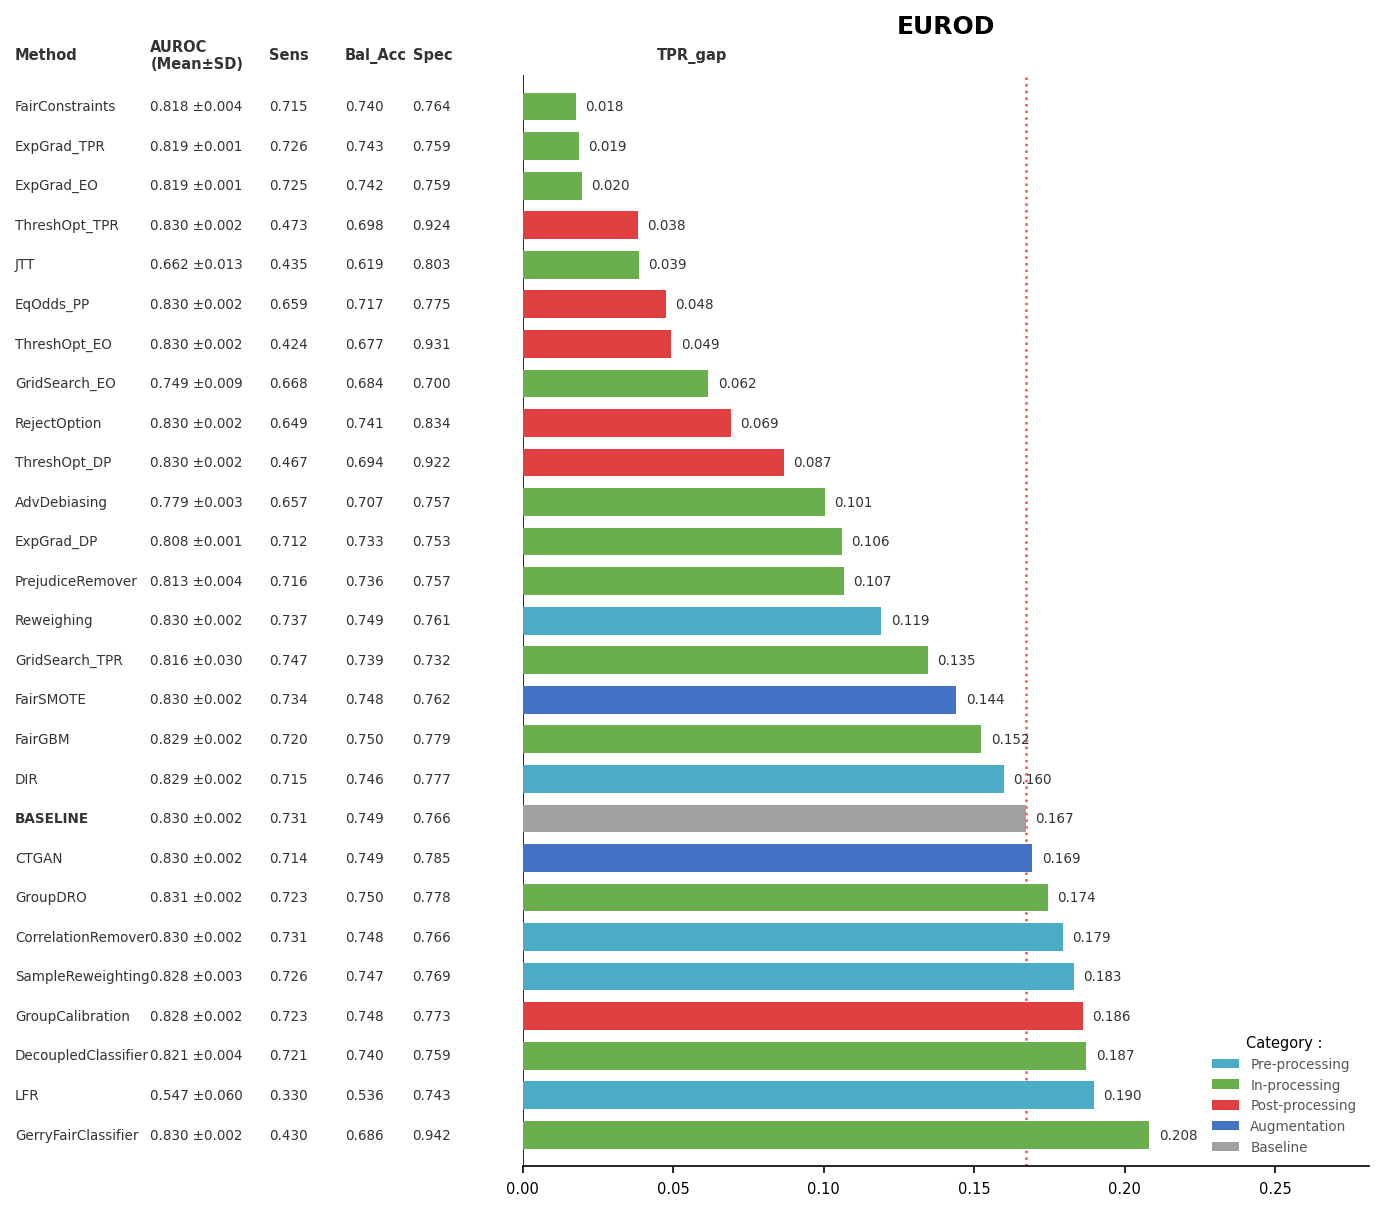

  ✓ TPRgap_EUROD.png


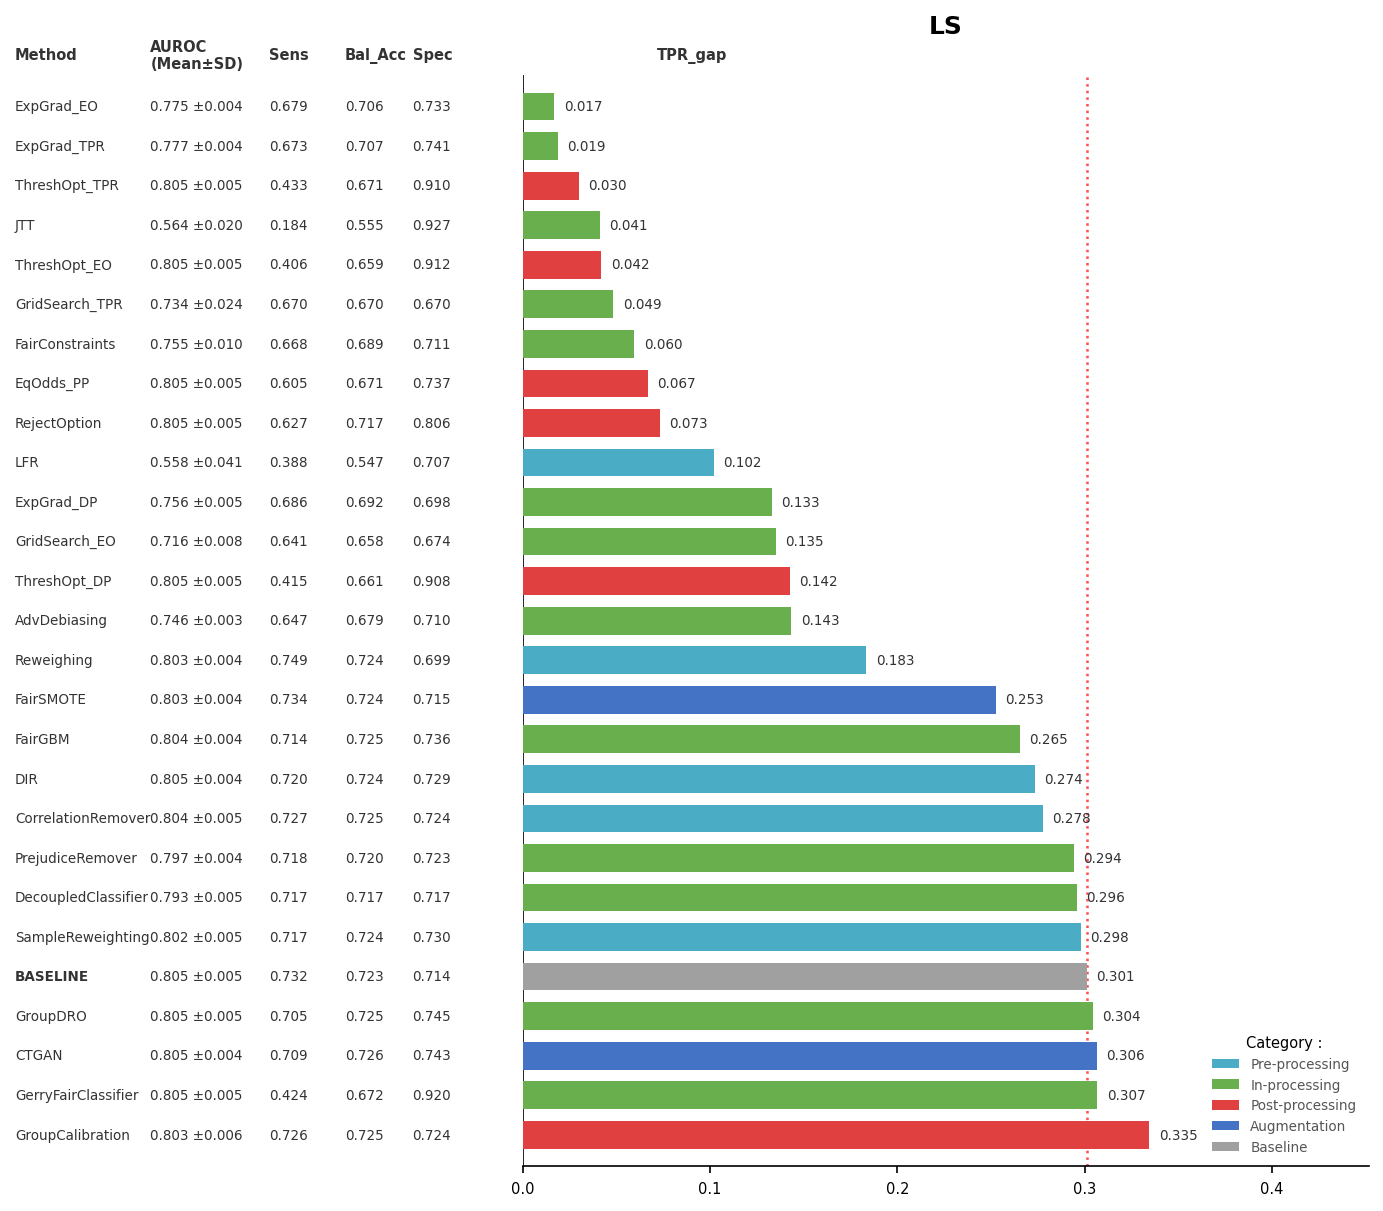

  ✓ TPRgap_LS.png


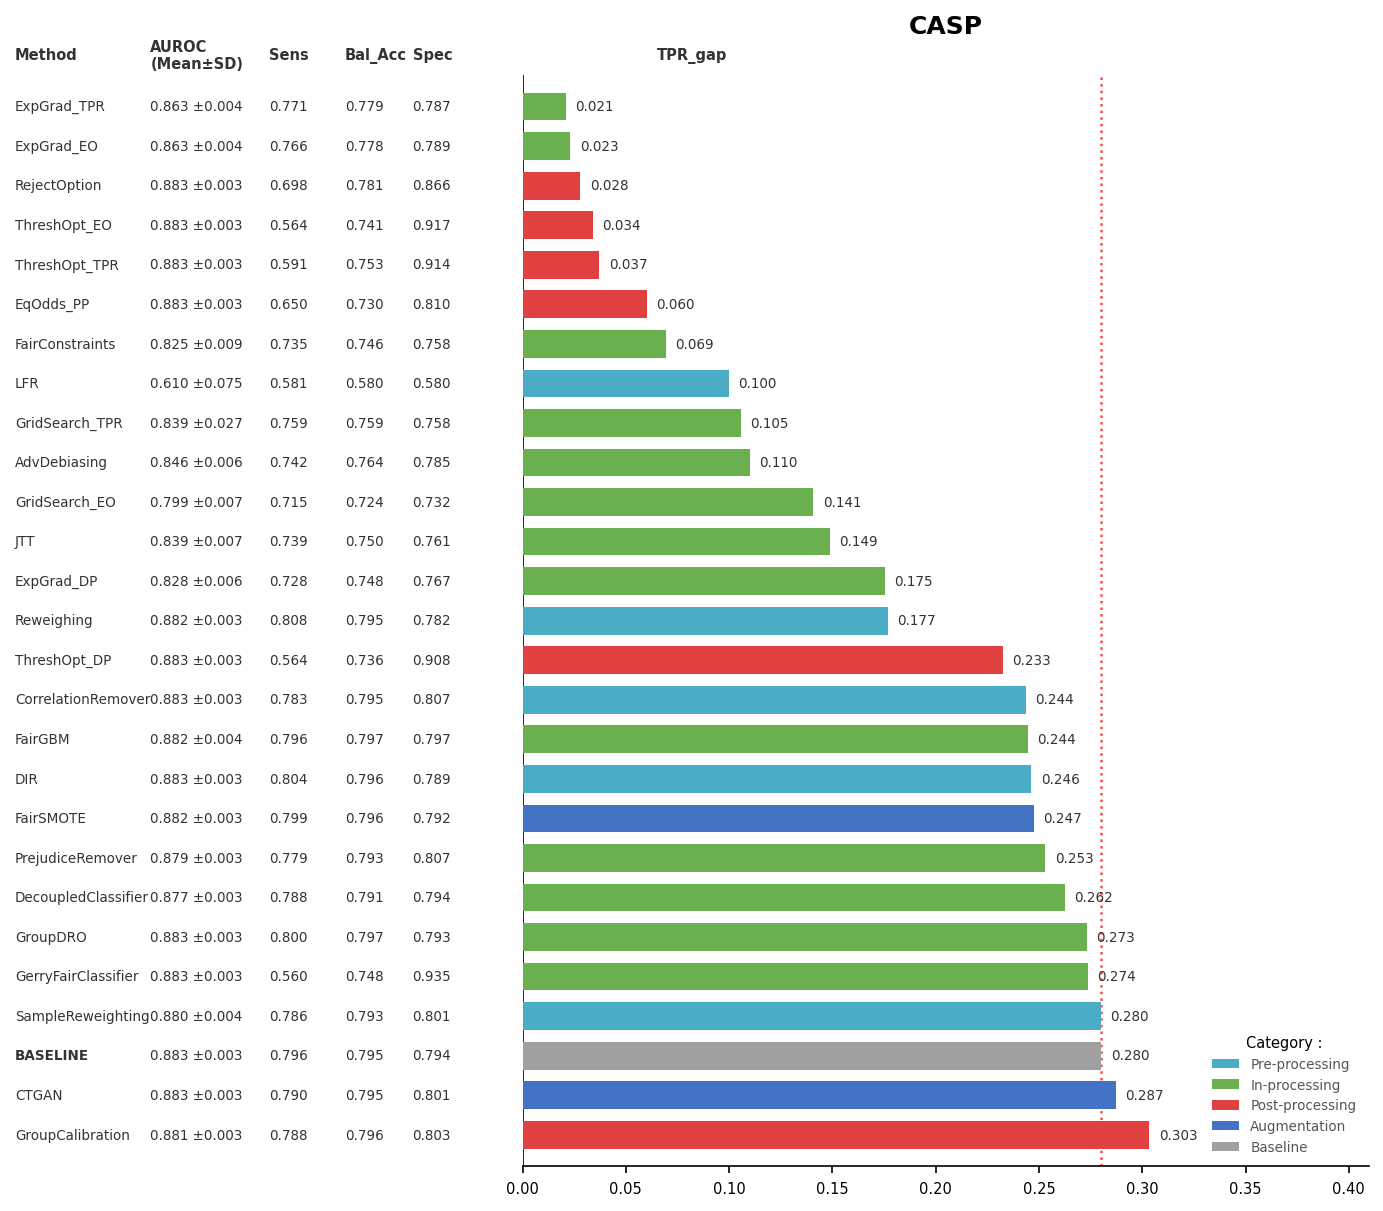

  ✓ TPRgap_CASP.png


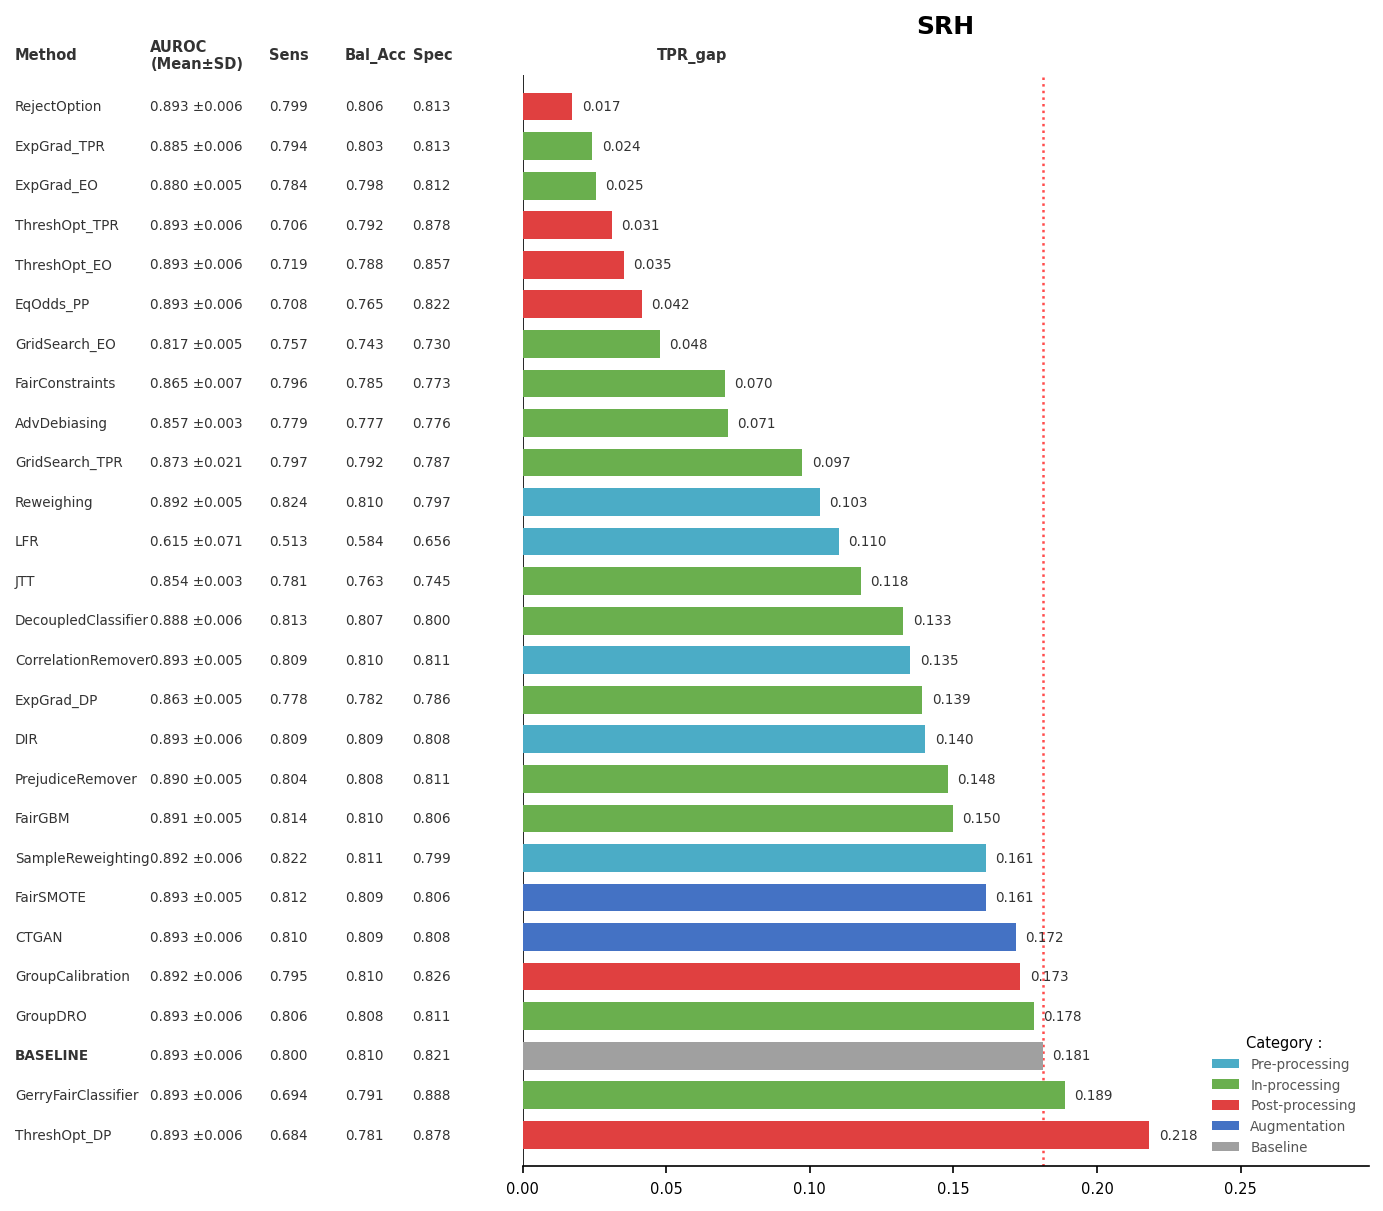

  ✓ TPRgap_SRH.png


In [91]:
# ============================================================
# FIG 2: TPR Gap Ranked Bar Charts — Per Outcome
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

CATEGORY_COLORS = {
    'Pre-processing': '#4BACC6',
    'In-processing': '#6AAF4E',
    'Post-processing': '#E04040',
    'Augmentation': '#4472C4',
    'Baseline': '#A0A0A0',
}

OUTCOME_LABELS = {
    'EUROD': 'Depression (EURO-D)',
    'LS': 'Life Satisfaction',
    'CASP': 'Quality of Life (CASP-12)',
    'SRH': 'Self-Rated Health',
}

def plot_tpr_gap_panel(ax, data, outcome, show_legend=False, fontscale=1.0):
    data = data.sort_values('TPR_gap_mean', ascending=True).reset_index(drop=True)
    n = len(data)
    baseline_gap = data.loc[data['Method'] == 'BASELINE', 'TPR_gap_mean'].values[0]
    max_gap = data['TPR_gap_mean'].max()

    y_pos = np.arange(n)
    colors = [CATEGORY_COLORS.get(row['Category'], '#888888') for _, row in data.iterrows()]

    ax.set_facecolor('white')
    ax.barh(y_pos, data['TPR_gap_mean'].values, height=0.7,
            color=colors, edgecolor='none', zorder=2)
    ax.axvline(x=baseline_gap, color='red', linestyle=':', linewidth=1.2,
               alpha=0.7, zorder=1)
    ax.axvline(x=0, color='black', linewidth=0.8, zorder=1)

    for i, (_, row) in enumerate(data.iterrows()):
        gap = row['TPR_gap_mean']
        ax.text(gap + max_gap * 0.015, i, f'{gap:.3f}',
                va='center', ha='left', fontsize=6.5 * fontscale, color='#333333')

    ax.set_xlim(0, max_gap * 1.35)
    ax.set_ylim(-0.8, n - 0.2)
    ax.invert_yaxis()
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=7 * fontscale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    col_x = {'method': -0.60, 'auroc': -0.44, 'sens': -0.30, 'balacc': -0.21, 'spec': -0.13}
    fs_hdr = 7 * fontscale
    fs_data = 6.5 * fontscale

    hy = -1.3
    for label, key in [('Method', 'method'), ('AUROC\n(Mean±SD)', 'auroc'),
                        ('Sens', 'sens'), ('Bal_Acc', 'balacc'), ('Spec', 'spec')]:
        ax.text(col_x[key], hy, label, fontsize=fs_hdr, fontweight='bold',
                color='#333333', ha='left', va='center',
                transform=ax.get_yaxis_transform())
    ax.text(0.20, hy, 'TPR_gap', fontsize=fs_hdr, fontweight='bold',
            color='#333333', ha='center', va='center',
            transform=ax.get_yaxis_transform())

    for i, (_, row) in enumerate(data.iterrows()):
        tp = dict(fontsize=fs_data, color='#333333', ha='left', va='center',
                  transform=ax.get_yaxis_transform())
        fw = 'bold' if row['Method'] == 'BASELINE' else 'normal'

        ax.text(col_x['method'], i, row['Method'],
                fontsize=fs_data, fontweight=fw, color='#333333',
                ha='left', va='center', transform=ax.get_yaxis_transform())
        ax.text(col_x['auroc'], i,
                f"{row['AUROC_mean']:.3f} ±{row['AUROC_sd']:.3f}", **tp)
        ax.text(col_x['sens'], i, f"{row['Sens_mean']:.3f}", **tp)
        ax.text(col_x['balacc'], i, f"{row['Bal_Acc_mean']:.3f}", **tp)
        ax.text(col_x['spec'], i, f"{row['Spec_mean']:.3f}", **tp)

    ax.set_title(outcome, fontsize=12 * fontscale, fontweight='bold', loc='center', pad=20)

    if show_legend:
        patches = [mpatches.Patch(facecolor=c, label=cat) for cat, c in CATEGORY_COLORS.items()]
        ax.legend(handles=patches, title='Category :', loc='lower right',
                  fontsize=6.5 * fontscale, title_fontsize=7 * fontscale,
                  frameon=False, labelcolor='#555555')

for outcome in CFG.outcomes:
    df_out = results_df[results_df['Outcome'] == outcome].copy()
    fig, ax = plt.subplots(figsize=(12, max(8, len(df_out) * 0.35)))
    fig.patch.set_facecolor('white')
    plot_tpr_gap_panel(ax, df_out, outcome, show_legend=True, fontscale=1.0)
    plt.subplots_adjust(left=0.45, right=0.92)
    fig.savefig(f'{CFG.output_dir}/plots/TPRgap_{outcome}.png',
                dpi=600, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f'  ✓ TPRgap_{outcome}.png')

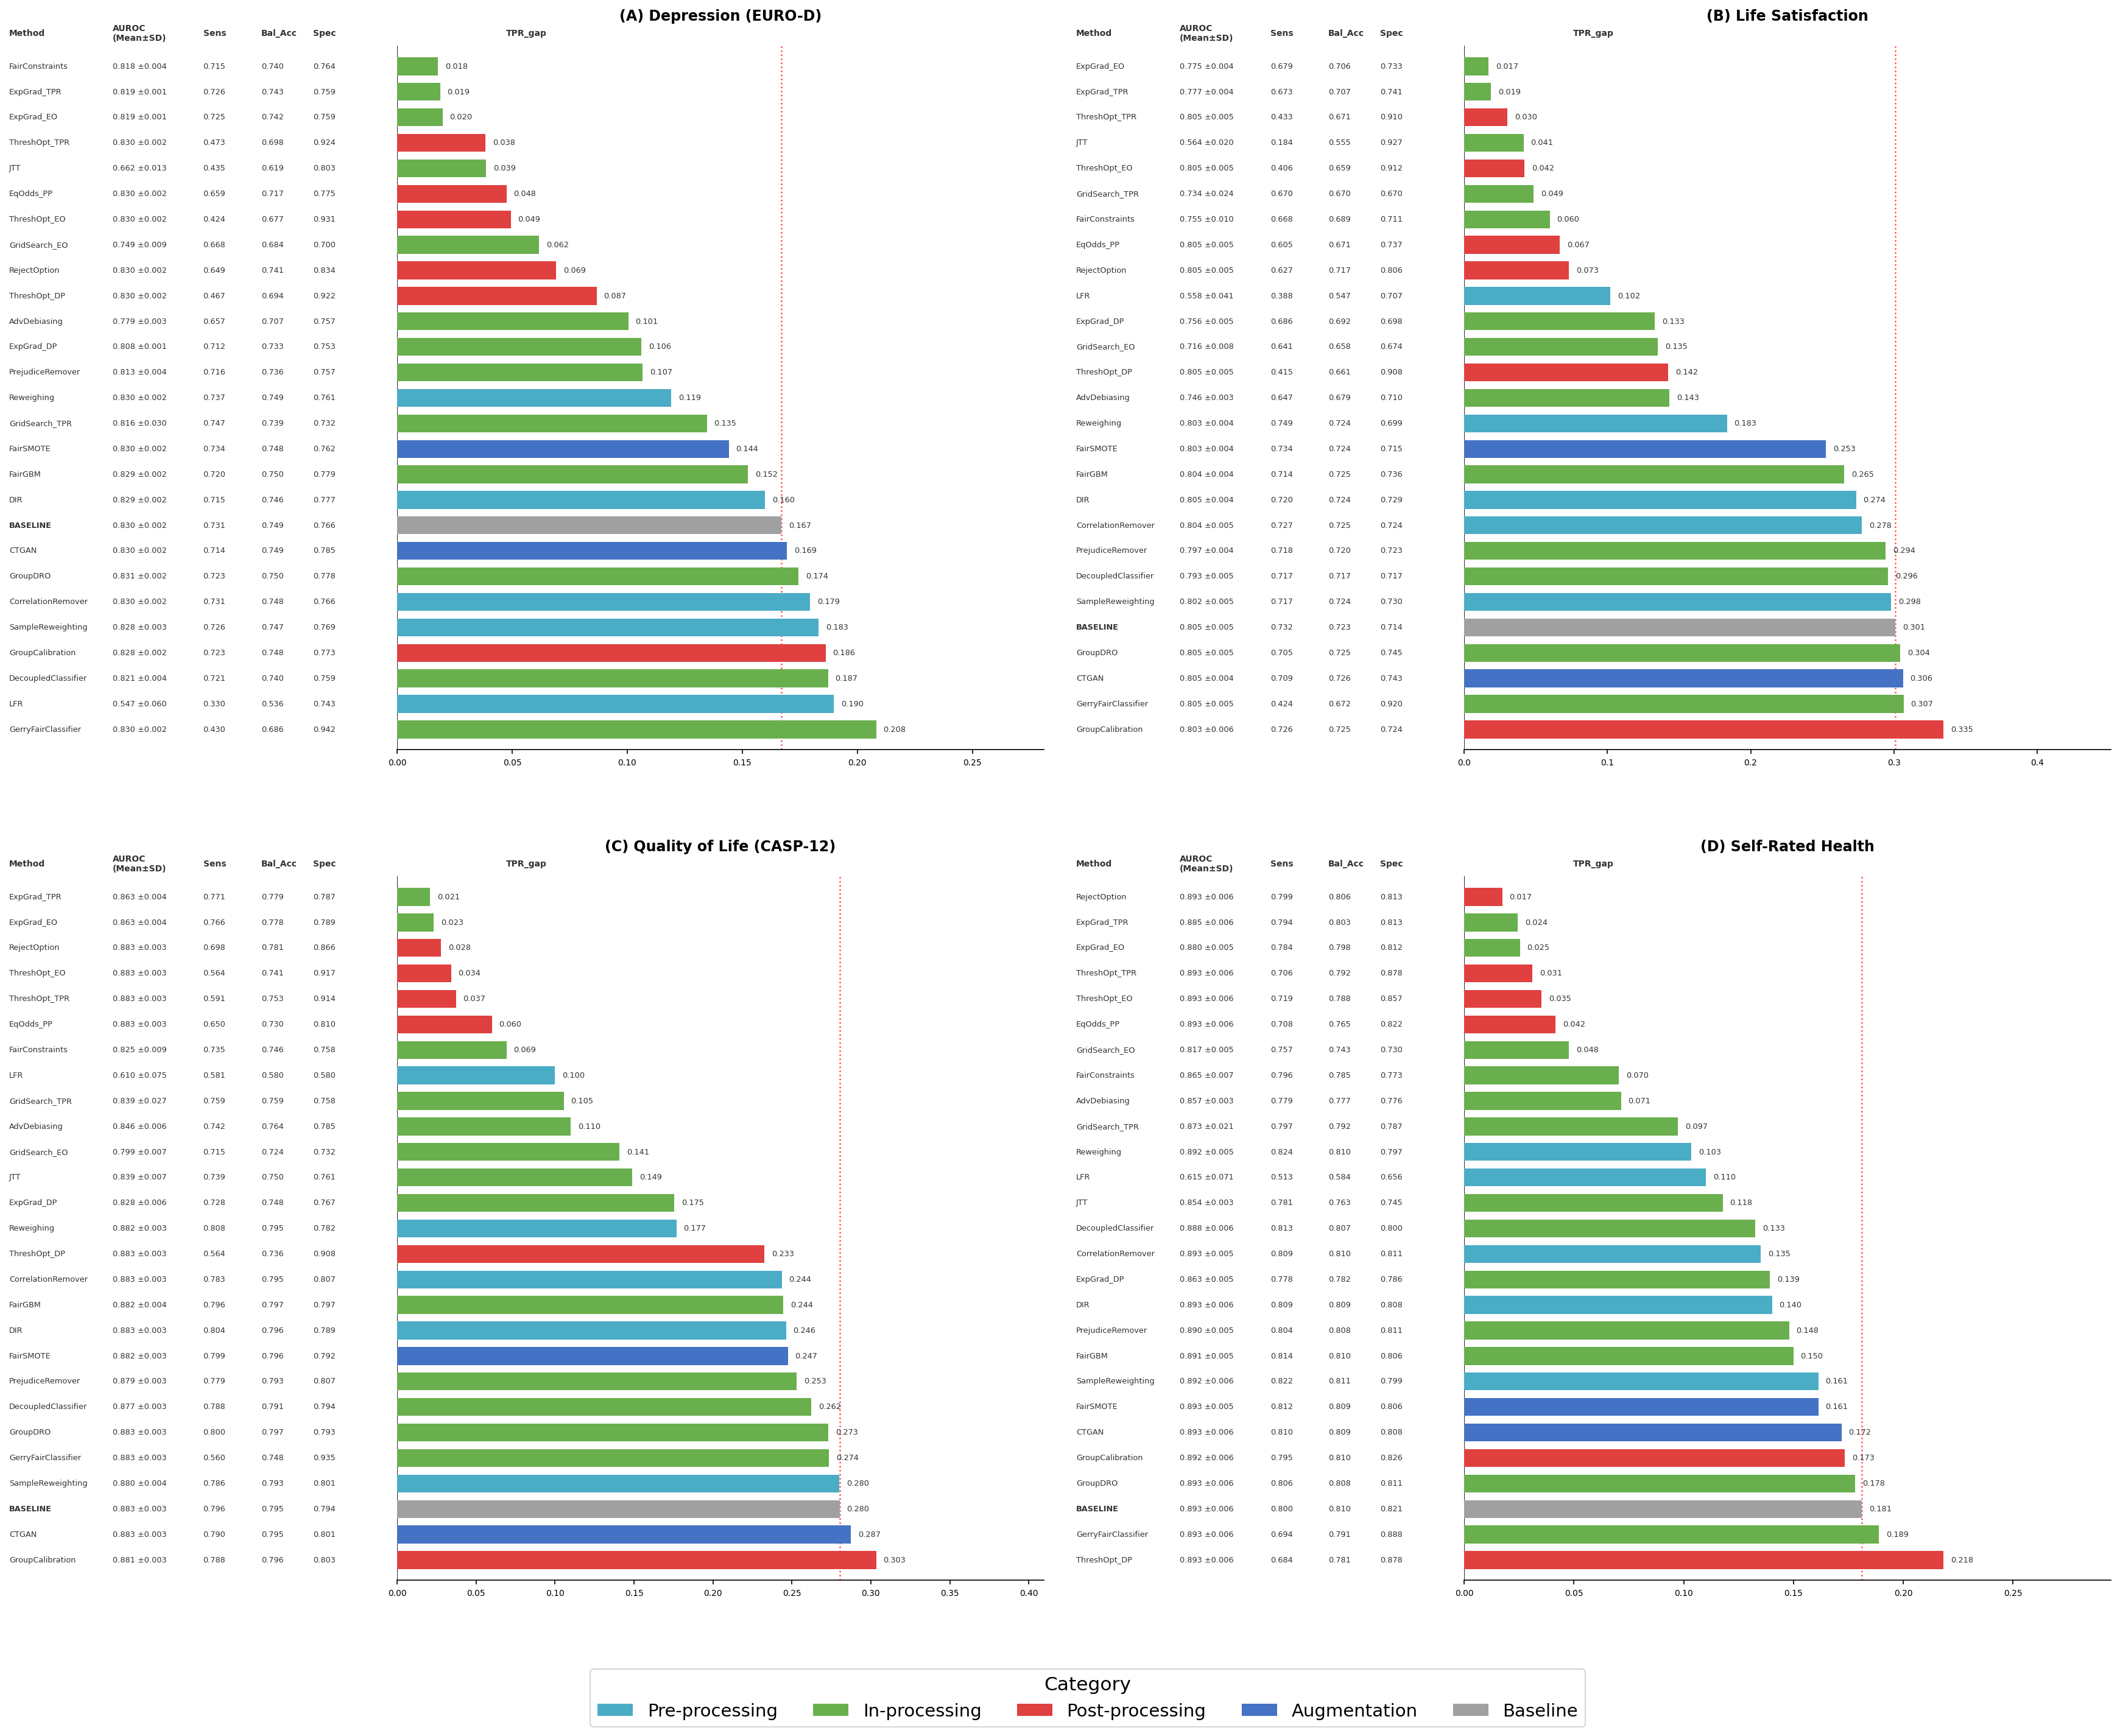

✓ Fig2_TPRgap_composite.png


In [115]:
# ============================================================
# FIG 2 COMPOSITE: 2×2 panel for manuscript
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(28, 21))
fig.patch.set_facecolor('white')

for idx, (outcome, ax) in enumerate(zip(CFG.outcomes, axes.flat)):
    df_out = results_df[results_df['Outcome'] == outcome].copy()
    label = f"({chr(65+idx)}) {OUTCOME_LABELS.get(outcome, outcome)}"
    plot_tpr_gap_panel(ax, df_out, label, show_legend=False, fontscale=0.95)

patches = [mpatches.Patch(facecolor=c, label=cat) for cat, c in CATEGORY_COLORS.items()]
fig.legend(handles=patches, title='Category', loc='lower center',
           ncol=5, fontsize=14, title_fontsize=15, frameon=True,
           bbox_to_anchor=(0.52, -0.001), edgecolor='#CCCCCC')

plt.subplots_adjust(left=0.25, right=0.92, bottom=0.08, hspace=0.18, wspace=0.65)
fig.savefig(f'{CFG.output_dir}/plots/Fig2_TPRgap_composite.png',
            dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ Fig2_TPRgap_composite.png')

### Fig 3: TPR Gap by Method Category
Box plots showing that method category predicts effectiveness.  
Post-processing and in-processing sit below baseline; augmentation does not.

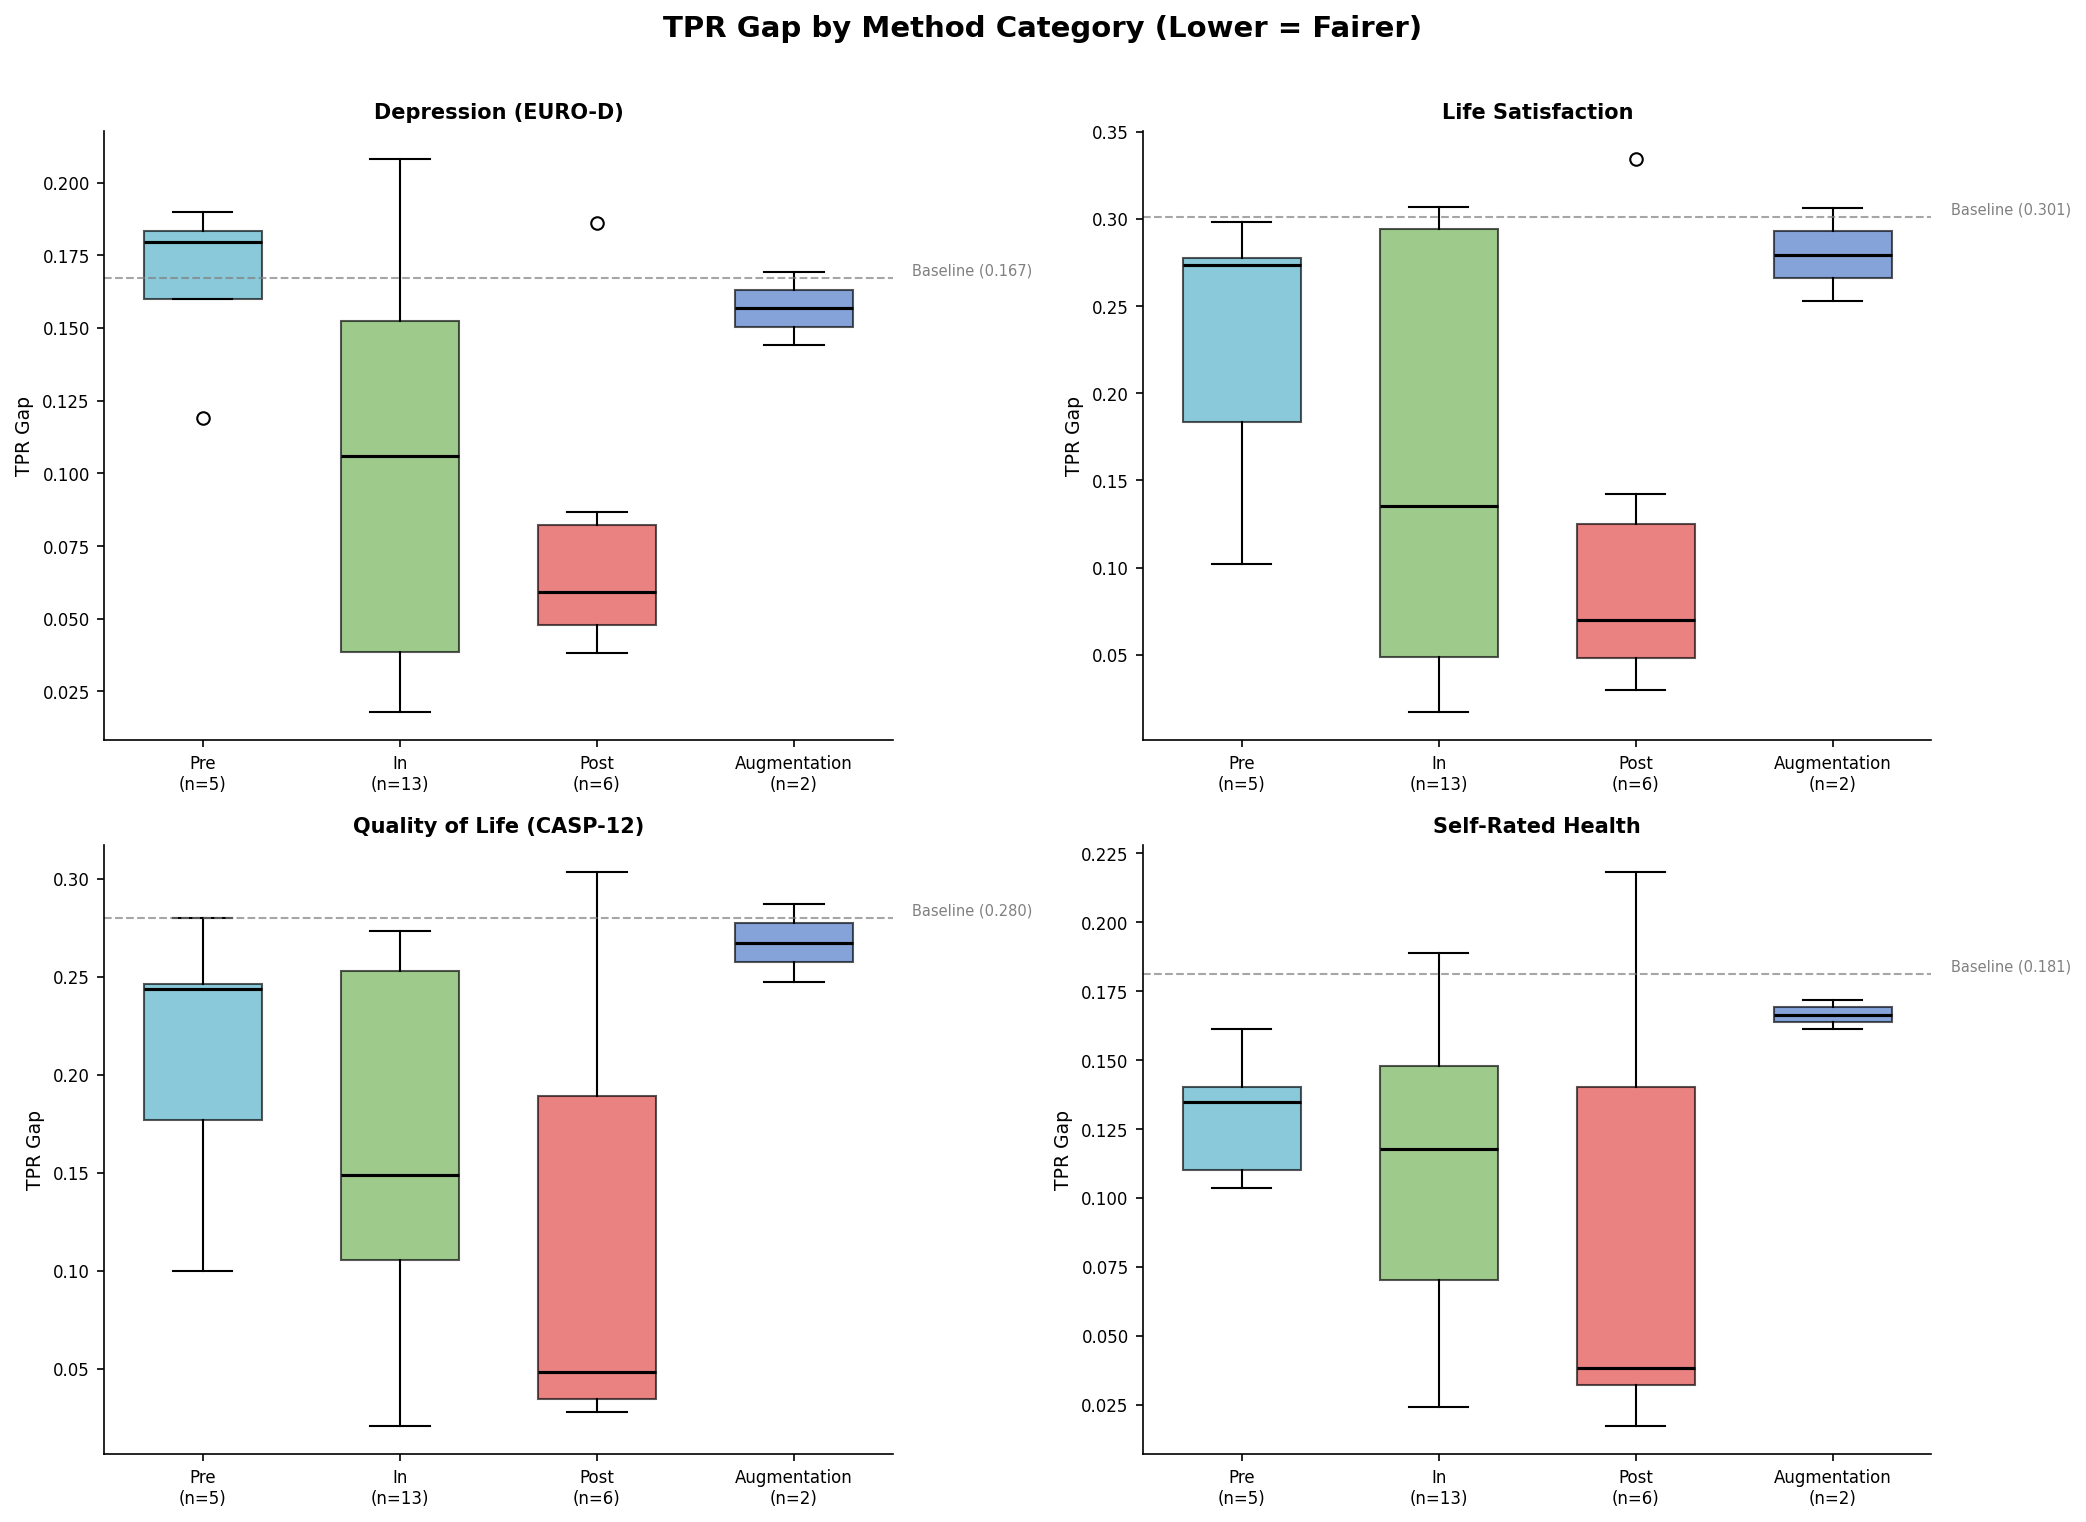

✓ Fig3_category_boxplot.png


In [116]:
# ============================================================
# FIG 3: Category Box Plot (TPR Gap by Category)
# ============================================================
cat_order = ['Pre-processing', 'In-processing', 'Post-processing', 'Augmentation']
cat_colors = ['#4BACC6', '#6AAF4E', '#E04040', '#4472C4']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_facecolor('white')
fig.suptitle('TPR Gap by Method Category (Lower = Fairer)', fontsize=14, fontweight='bold', y=1.01)

for idx, (outcome, ax) in enumerate(zip(CFG.outcomes, axes.flat)):
    df_out = results_df[(results_df['Outcome'] == outcome) &
                        (results_df['Category'].isin(cat_order))].copy()

    baseline_gap = results_df.loc[
        (results_df['Outcome'] == outcome) & (results_df['Method'] == 'BASELINE'),
        'TPR_gap_mean'].values[0]

    box_data = [df_out.loc[df_out['Category'] == cat, 'TPR_gap_mean'].values for cat in cat_order]
    n_per_cat = [len(d) for d in box_data]

    bp = ax.boxplot(box_data, patch_artist=True, widths=0.6,
                    medianprops=dict(color='black', linewidth=1.5))
    for patch, color in zip(bp['boxes'], cat_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.65)

    ax.axhline(y=baseline_gap, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.text(4.6, baseline_gap, f'Baseline ({baseline_gap:.3f})',
            fontsize=7, color='gray', va='bottom')

    labels = [f'{cat.split("-")[0]}\n(n={n})' for cat, n in zip(cat_order, n_per_cat)]
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylabel('TPR Gap', fontsize=9)
    ax.set_title(f'{OUTCOME_LABELS.get(outcome, outcome)}', fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig(f'{CFG.output_dir}/plots/Fig3_category_boxplot.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ Fig3_category_boxplot.png')

### Fig 4: Fairea Trade-off Classification
Scatter plot: TPR gap reduction (x) vs AUROC change (y).  
Upper-right = effective fairness at low cost. Colour = category.

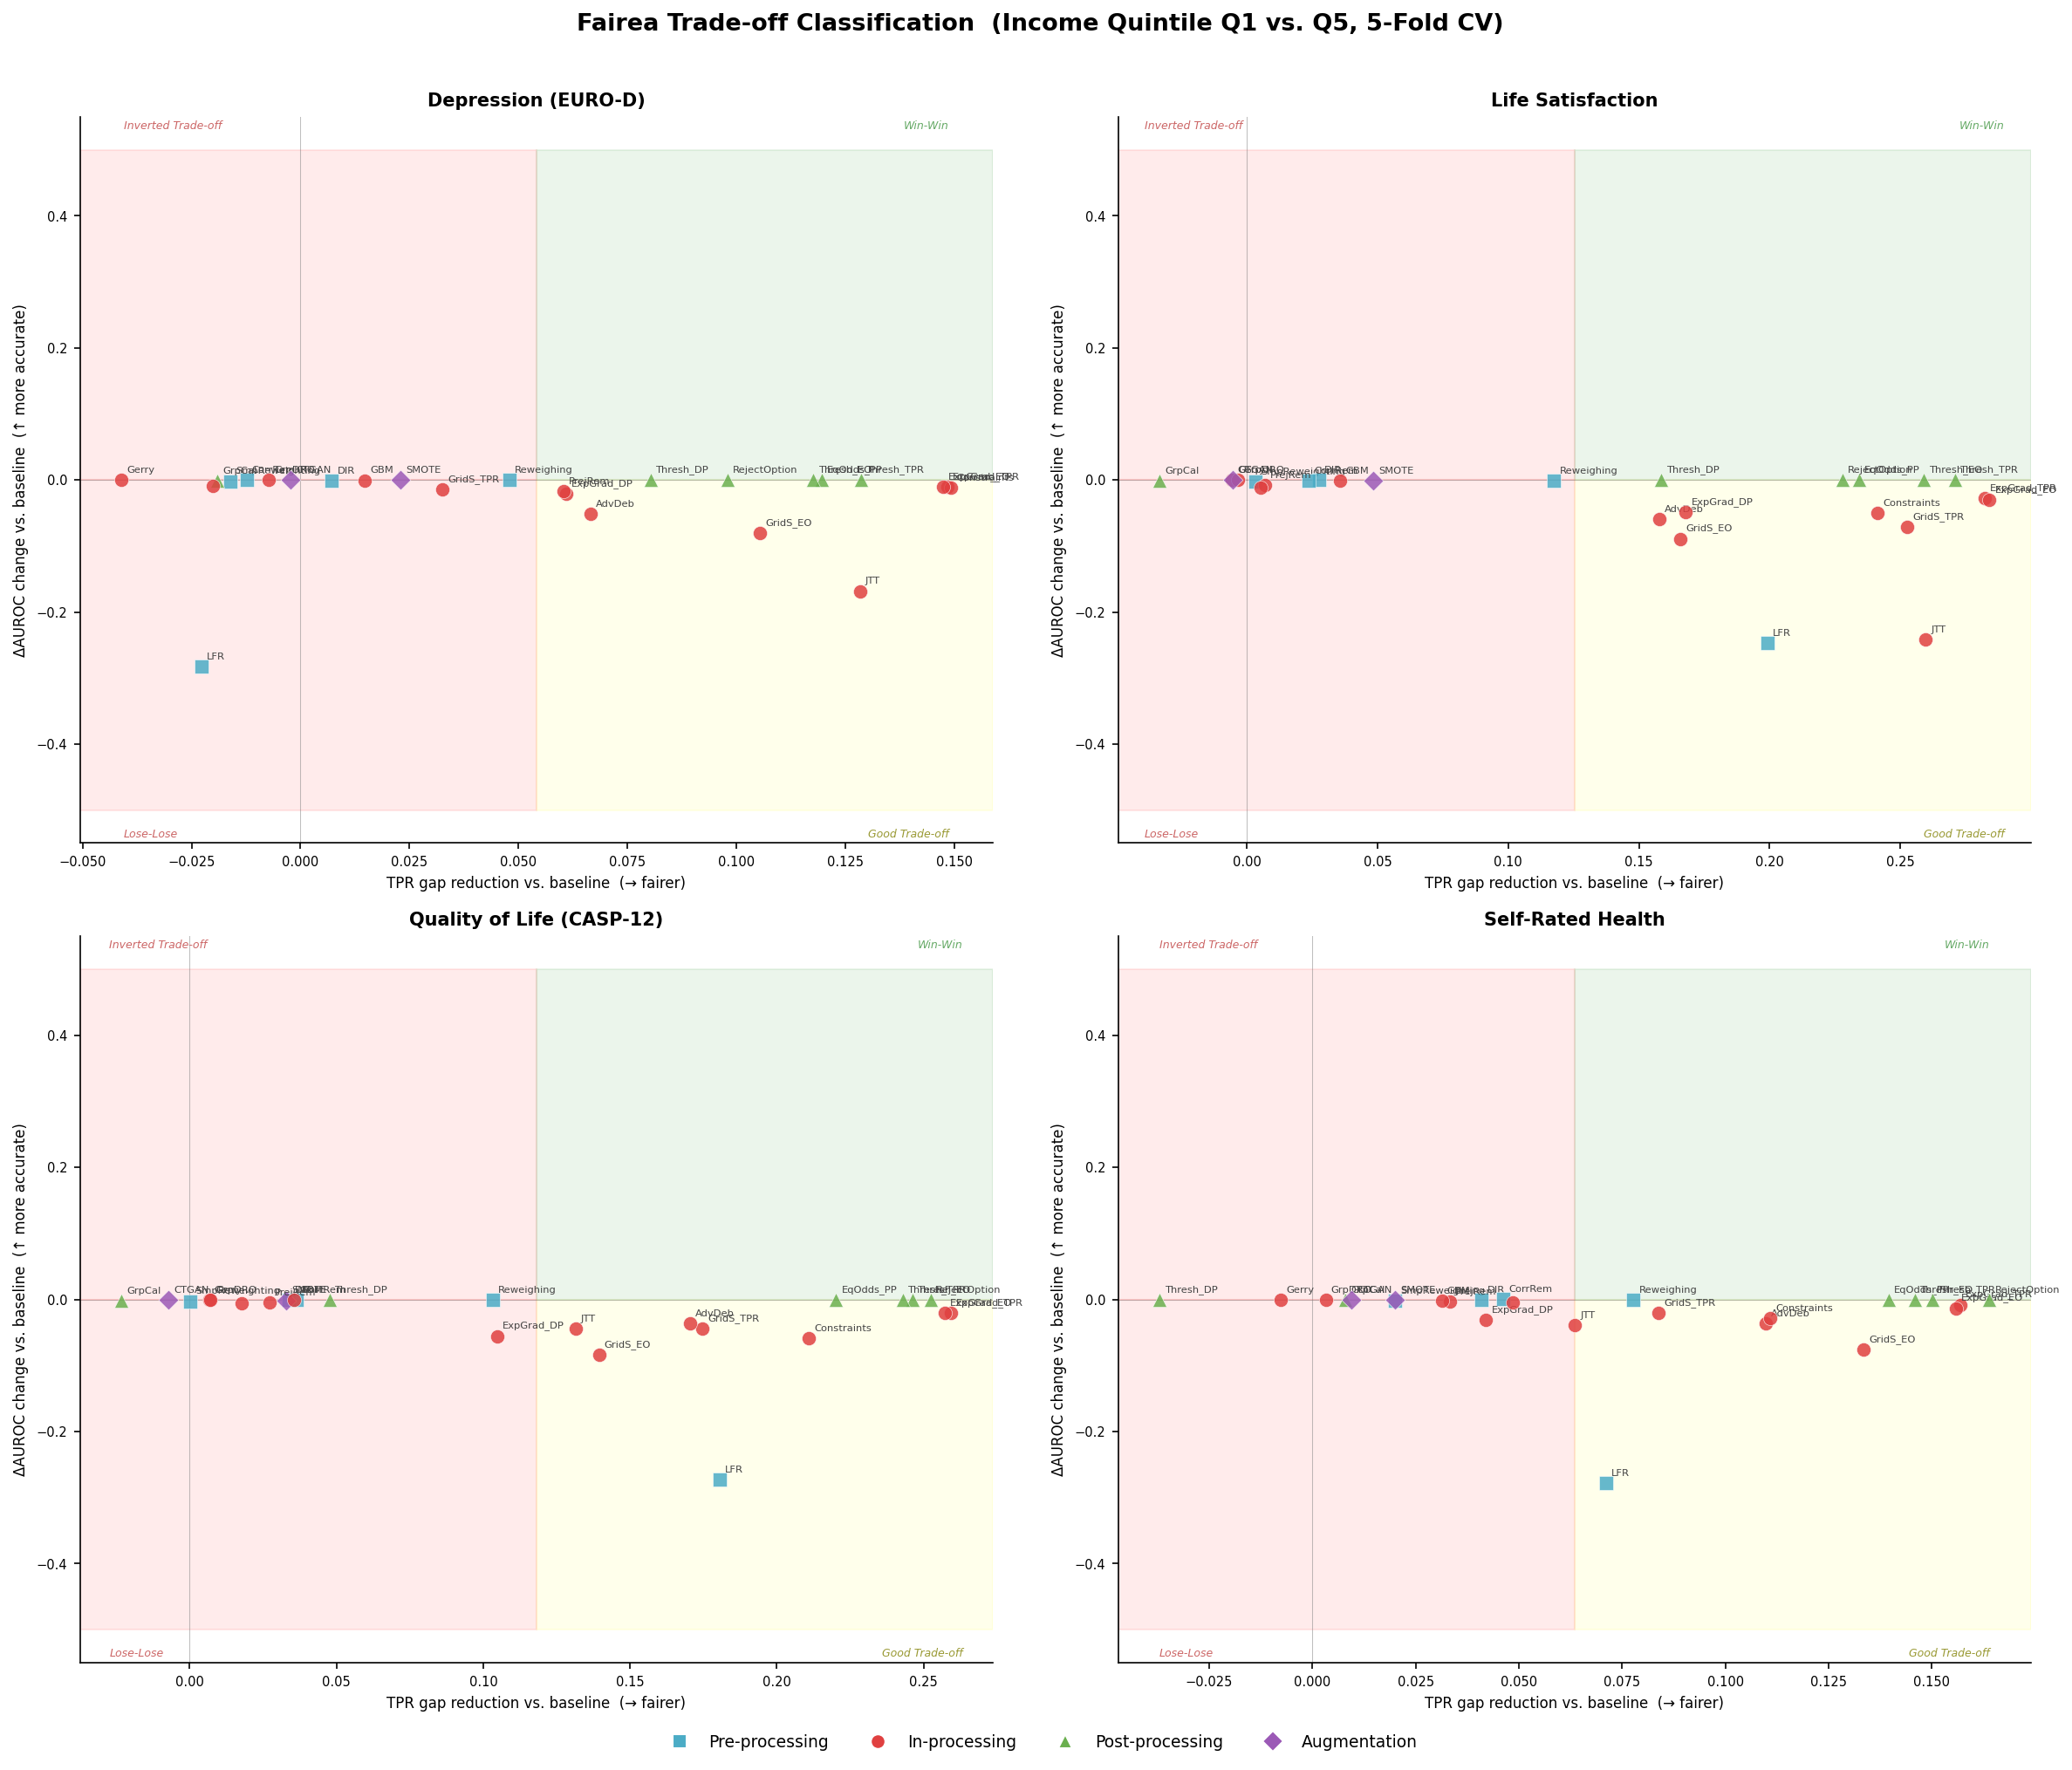

✓ Fig4_fairea_tradeoff.png


In [117]:
# ============================================================
# FIG 4: Fairea Trade-off Classification (TPR gap reduction vs ΔAUROC)
# ============================================================
cat_markers = {
    'Pre-processing': ('s', '#4BACC6'),
    'In-processing': ('o', '#E04040'),
    'Post-processing': ('^', '#6AAF4E'),
    'Augmentation': ('D', '#9B59B6'),
}

fig, axes = plt.subplots(2, 2, figsize=(16, 13))
fig.patch.set_facecolor('white')
fig.suptitle('Fairea Trade-off Classification  (Income Quintile Q1 vs. Q5, 5-Fold CV)',
             fontsize=13, fontweight='bold', y=1.01)

for idx, (outcome, ax) in enumerate(zip(CFG.outcomes, axes.flat)):
    df_out = results_df[results_df['Outcome'] == outcome].copy()
    bl = df_out.loc[df_out['Method'] == 'BASELINE']
    bl_auroc = bl['AUROC_mean'].values[0]
    bl_tpr = bl['TPR_gap_mean'].values[0]

    methods = df_out[df_out['Method'] != 'BASELINE']

    # Quadrant shading
    ax.axhspan(0, 0.5, xmin=0, xmax=0.5, alpha=0.08, color='red')      # top-left: inverted
    ax.axhspan(0, 0.5, xmin=0.5, xmax=1.0, alpha=0.08, color='green')  # top-right: win-win
    ax.axhspan(-0.5, 0, xmin=0.5, xmax=1.0, alpha=0.08, color='yellow') # bottom-right: good trade-off
    ax.axhspan(-0.5, 0, xmin=0, xmax=0.5, alpha=0.08, color='red')      # bottom-left: lose-lose

    ax.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

    texts = []
    for _, row in methods.iterrows():
        delta_tpr = bl_tpr - row['TPR_gap_mean']   # positive = fairer
        delta_auroc = row['AUROC_mean'] - bl_auroc  # positive = better

        cat = row['Category']
        marker, color = cat_markers.get(cat, ('x', 'gray'))

        ax.scatter(delta_tpr, delta_auroc, c=color, marker=marker,
                   s=60, edgecolors='white', linewidths=0.3, zorder=3, alpha=0.85)

        # Short method label
        short = row['Method'].replace('Opt_', '_').replace('Search_', 'S_')
        short = short.replace('Correlation', 'Corr').replace('Remover', 'Rem')
        short = short.replace('Sample', 'Smp').replace('Weighting', 'Rwt')
        short = short.replace('Calibration', 'Cal').replace('Group', 'Grp')
        short = short.replace('Classifier', '').replace('Fair', '')
        short = short.replace('Debiasing', 'Deb').replace('Adversarial', 'Adv')
        short = short.replace('Prejudice', 'Prej').replace('Decoupled', '')

        ax.annotate(short, (delta_tpr, delta_auroc),
                    fontsize=5.5, color='#444444', ha='left', va='bottom',
                    xytext=(3, 3), textcoords='offset points')

    # Quadrant labels
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.text(xlims[0] + 0.01, ylims[1] - 0.005, 'Inverted Trade-off',
            fontsize=6, color='#CC6666', fontstyle='italic', va='top')
    ax.text(xlims[1] - 0.01, ylims[1] - 0.005, 'Win-Win',
            fontsize=6, color='#66AA66', fontstyle='italic', va='top', ha='right')
    ax.text(xlims[1] - 0.01, ylims[0] + 0.005, 'Good Trade-off',
            fontsize=6, color='#999933', fontstyle='italic', va='bottom', ha='right')
    ax.text(xlims[0] + 0.01, ylims[0] + 0.005, 'Lose-Lose',
            fontsize=6, color='#CC6666', fontstyle='italic', va='bottom')

    ax.set_xlabel('TPR gap reduction vs. baseline  (→ fairer)', fontsize=8)
    ax.set_ylabel('ΔAUROC change vs. baseline  (↑ more accurate)', fontsize=8)
    ax.set_title(f'{OUTCOME_LABELS.get(outcome, outcome)}', fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=7)

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=m, color='w', markerfacecolor=c,
                          markersize=8, label=cat)
                   for cat, (m, c) in cat_markers.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=4,
           fontsize=9, frameon=False, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
fig.savefig(f'{CFG.output_dir}/plots/Fig4_fairea_tradeoff.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ Fig4_fairea_tradeoff.png')

### Fig 5: Method Heatmap — Consistency Across Outcomes
Shows percentage reduction in TPR gap for all methods × all outcomes.  
Reveals: the same top methods work everywhere; augmentation fails everywhere.

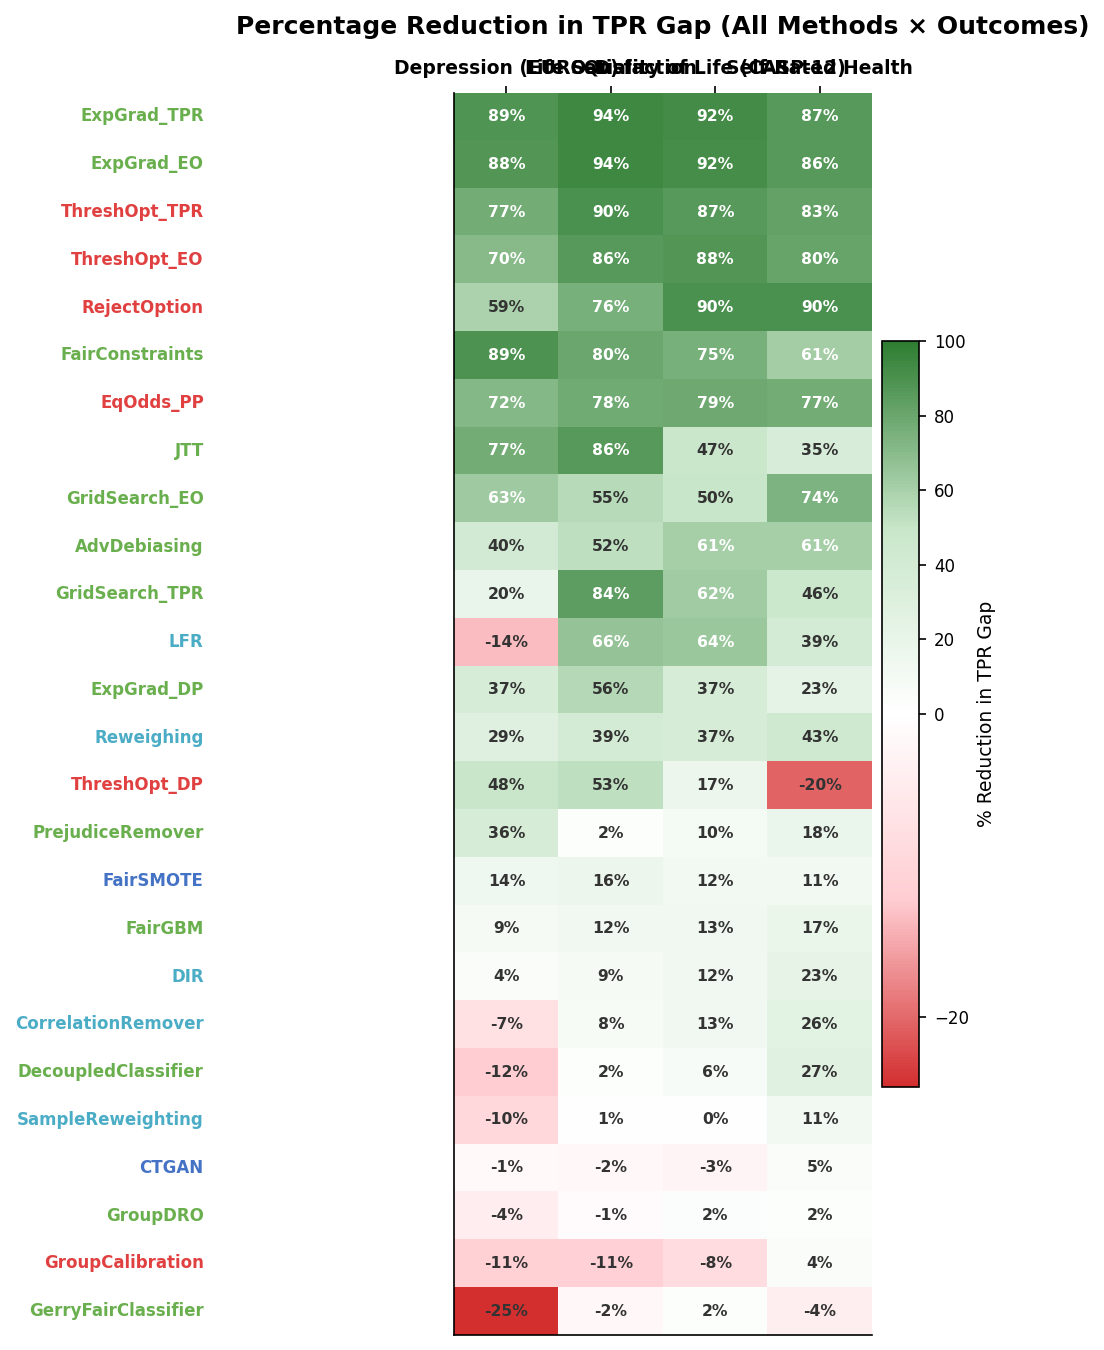

✓ Fig5_method_heatmap.png


In [118]:
# ============================================================
# FIG 5: Method Heatmap — % Reduction across outcomes
# ============================================================
import matplotlib.colors as mcolors

# Pivot: methods × outcomes
pivot = results_df.pivot_table(index='Method', columns='Outcome',
                               values='Pct_Reduction', aggfunc='first')
pivot = pivot.reindex(columns=['EUROD', 'LS', 'CASP', 'SRH'])

# Sort by mean reduction (best at top)
pivot['mean_red'] = pivot.mean(axis=1)
pivot = pivot.sort_values('mean_red', ascending=False)
pivot = pivot.drop(columns='mean_red')

# Drop baseline
pivot = pivot.drop(index='BASELINE', errors='ignore')

fig, ax = plt.subplots(figsize=(8, max(8, len(pivot) * 0.35)))
fig.patch.set_facecolor('white')

# Custom colormap: red (negative) → white (0) → green (positive)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'rg', ['#D32F2F', '#FFCDD2', '#FFFFFF', '#C8E6C9', '#2E7D32'])
vmin = min(pivot.min().min(), -20)
vmax = max(pivot.max().max(), 100)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(pivot.values, cmap=cmap, norm=norm, aspect='auto')

# Labels
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([OUTCOME_LABELS.get(c, c) for c in pivot.columns],
                    fontsize=9, fontweight='bold')
ax.set_yticks(range(len(pivot.index)))

# Color y-labels by category
cat_map = results_df.drop_duplicates('Method').set_index('Method')['Category'].to_dict()
for i, method in enumerate(pivot.index):
    cat = cat_map.get(method, 'Unknown')
    color = CATEGORY_COLORS.get(cat, '#333333')
    ax.text(-0.6, i, method, fontsize=8, color=color, ha='right', va='center',
            fontweight='bold', transform=ax.get_yaxis_transform())
ax.set_yticks([])

# Annotate cells
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.iloc[i, j]
        if pd.notna(val):
            txt_color = 'white' if abs(val) > 60 else '#333333'
            ax.text(j, i, f'{val:.0f}%', ha='center', va='center',
                    fontsize=7.5, color=txt_color, fontweight='bold')

cbar = fig.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('% Reduction in TPR Gap', fontsize=9)

ax.set_title('Percentage Reduction in TPR Gap (All Methods × Outcomes)',
             fontsize=12, fontweight='bold', pad=12)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
fig.savefig(f'{CFG.output_dir}/plots/Fig5_method_heatmap.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ Fig5_method_heatmap.png')

---
## Fairness Lifecycle Analysis
The following cells implement the **lifecycle evaluation framework**.
They trace 26 methods through successive deployment stages and quantify clinical impact for survivors.

**Important**: These cells read from `tables/` CSVs produced by the main pipeline above. Do NOT re-run the pipeline cells; just run these new cells.

### Fig 6: Lifecycle Survival Funnel
Shows progressive elimination of 26 methods through deployment stages.
This is the paper's **signature figure**.

In [ ]:
# ============================================================
# FIG 6 – Lifecycle Survival Funnel
# ============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.patches as mpatches
from pathlib import Path

OUT = Path("fairness_output")
OUT.mkdir(exist_ok=True)

full = pd.read_csv("tables/full_results.csv")
deploy = pd.read_csv("tables/deployability_contract.csv")

# ── Baselines per outcome ──
baselines = full[full["Method"] == "BASELINE"].set_index("Outcome")
methods = full[full["Method"] != "BASELINE"].copy()

outcomes = ["EUROD", "LS", "CASP", "SRH"]
all_methods = sorted(methods["Method"].unique())
n_start = len(all_methods)  # 26

# ── Stage 1: Effectiveness (% reduction > 0 on >= 3 of 4 outcomes) ──
def check_effectiveness(m):
    rows = methods[methods["Method"] == m]
    pos = sum(rows["Pct_Reduction"] > 0)
    return pos >= 3

stage1 = [m for m in all_methods if check_effectiveness(m)]

# ── Stage 2: Deployability (Tier 1 = no A at inference) ──
tier1 = set(deploy[deploy["Deployable"] == "Yes"]["Method"])
stage2 = [m for m in stage1 if m in tier1]

# ── Stage 3: Accuracy (AUROC drop <= 0.03 on ALL outcomes) ──
def check_accuracy(m):
    for oc in outcomes:
        bl = baselines.loc[oc, "AUROC_mean"]
        row = methods[(methods["Method"] == m) & (methods["Outcome"] == oc)]
        if row.empty:
            return False
        if bl - row.iloc[0]["AUROC_mean"] > 0.03:
            return False
    return True

stage3 = [m for m in stage2 if check_accuracy(m)]

# ── Stage 4: Stability (sign >= 4/5 on ALL outcomes) ──
def check_stability(m):
    for oc in outcomes:
        row = methods[(methods["Method"] == m) & (methods["Outcome"] == oc)]
        if row.empty:
            return False
        if row.iloc[0]["Sign_improved"] < 4:
            return False
    return True

stage4 = [m for m in stage3 if check_stability(m)]

# ── Stage 5: Fairness threshold (>= 25% reduction on ALL outcomes) ──
def check_fairness(m):
    for oc in outcomes:
        row = methods[(methods["Method"] == m) & (methods["Outcome"] == oc)]
        if row.empty:
            return False
        if row.iloc[0]["Pct_Reduction"] < 25:
            return False
    return True

stage5 = [m for m in stage4 if check_fairness(m)]

# ── Print results ──
stages = [
    ("All methods", n_start),
    ("Effectiveness\n(reduces disparity)", len(stage1)),
    ("Deployability\n(no A at inference)", len(stage2)),
    ("Accuracy\n(AUROC drop ≤ 3pp)", len(stage3)),
    ("Stability\n(sign ≥ 4/5)", len(stage4)),
    ("Fairness\n(≥ 25% reduction)", len(stage5)),
]

print("LIFECYCLE FILTER RESULTS")
print("=" * 50)
for name, n in stages:
    print(f"  {name.replace(chr(10), " "):40s} → {n} methods")
print(f"\nSurvivors: {stage5}")

# ── Plot the funnel ──
fig, ax = plt.subplots(figsize=(10, 7))

labels = [s[0] for s in stages]
counts = [s[1] for s in stages]
colors = ["#4A90D9", "#5BA0E0", "#7CB5E8", "#A8CCF0", "#C4DCF5", "#2E8B57"]

max_w = 0.9
y_positions = list(range(len(stages) - 1, -1, -1))

for i, (label, count) in enumerate(zip(labels, counts)):
    w = max_w * (count / counts[0]) if counts[0] > 0 else 0.1
    w = max(w, 0.12)  # minimum width
    rect = mpatches.FancyBboxPatch(
        (0.5 - w/2, y_positions[i] - 0.35), w, 0.7,
        boxstyle="round,pad=0.05", facecolor=colors[i], edgecolor="white", linewidth=2
    )
    ax.add_patch(rect)
    ax.text(0.5, y_positions[i], f"{count}",
            ha="center", va="center", fontsize=22, fontweight="bold", color="white")
    ax.text(-0.05, y_positions[i], label.replace("\n", " "),
            ha="right", va="center", fontsize=10, color="#333")
    # Arrow between stages
    if i < len(stages) - 1:
        eliminated = counts[i] - counts[i+1]
        if eliminated > 0:
            ax.annotate(f"−{eliminated}", xy=(0.5, y_positions[i] - 0.42),
                       fontsize=9, ha="center", color="#CC3333", fontweight="bold")

ax.set_xlim(-0.6, 1.1)
ax.set_ylim(-0.8, len(stages) - 0.3)
ax.set_title("Fairness Lifecycle: From 26 Methods to Survivors",
             fontsize=14, fontweight="bold", pad=15)
ax.axis("off")
plt.tight_layout()
plt.savefig(OUT / "lifecycle_funnel.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT / "lifecycle_funnel.pdf", bbox_inches="tight")
plt.show()
print(f"Saved: {OUT}/lifecycle_funnel.png")


### Table: Lifecycle Survival Matrix
Pass/Fail status for every method at every lifecycle stage.

In [ ]:
# ============================================================
# LIFECYCLE SURVIVAL TABLE
# ============================================================
import pandas as pd

full = pd.read_csv("tables/full_results.csv")
deploy_df = pd.read_csv("tables/deployability_contract.csv")
baselines = full[full["Method"] == "BASELINE"].set_index("Outcome")
methods_df = full[full["Method"] != "BASELINE"].copy()
outcomes = ["EUROD", "LS", "CASP", "SRH"]
all_methods = sorted(methods_df["Method"].unique())
tier1_set = set(deploy_df[deploy_df["Deployable"] == "Yes"]["Method"])

rows = []
for m in all_methods:
    mdata = methods_df[methods_df["Method"] == m]
    cat = mdata.iloc[0]["Category"]

    # Effectiveness
    eff = sum(mdata.set_index("Outcome").reindex(outcomes)["Pct_Reduction"] > 0) >= 3

    # Deployability
    dep = m in tier1_set

    # Accuracy
    acc = True
    for oc in outcomes:
        bl = baselines.loc[oc, "AUROC_mean"]
        r = mdata[mdata["Outcome"] == oc]
        if not r.empty and bl - r.iloc[0]["AUROC_mean"] > 0.03:
            acc = False

    # Stability
    stab = True
    for oc in outcomes:
        r = mdata[mdata["Outcome"] == oc]
        if not r.empty and r.iloc[0]["Sign_improved"] < 4:
            stab = False

    # Fairness (>=25% reduction all outcomes)
    fair = True
    for oc in outcomes:
        r = mdata[mdata["Outcome"] == oc]
        if not r.empty and r.iloc[0]["Pct_Reduction"] < 25:
            fair = False

    survives = eff and dep and acc and stab and fair
    rows.append({
        "Method": m,
        "Category": cat,
        "Effective": "Pass" if eff else "FAIL",
        "Deployable": "Pass" if dep else "FAIL",
        "Accuracy": "Pass" if acc else "FAIL",
        "Stable": "Pass" if stab else "FAIL",
        "Fair_25pct": "Pass" if fair else "FAIL",
        "SURVIVES": "YES" if survives else "no",
    })

survival_df = pd.DataFrame(rows)
survival_df = survival_df.sort_values(["SURVIVES", "Category", "Method"],
                                       ascending=[False, True, True])

# Save
survival_df.to_csv("tables/lifecycle_survival_matrix.csv", index=False)
print("LIFECYCLE SURVIVAL MATRIX")
print("=" * 90)
print(survival_df.to_string(index=False))
print(f"\nSurvivors: {list(survival_df[survival_df.SURVIVES == \"YES\"][\"Method\"])}")


### Fig 7: Clinical Impact Estimation
Translates TPR gap reductions into additional correct identifications per screening wave.

In [ ]:
# ============================================================
# FIG 7 – Clinical Impact: Additional Correct Identifications
# ============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("fairness_output")
full = pd.read_csv("tables/full_results.csv")
baselines = full[full["Method"] == "BASELINE"].set_index("Outcome")

# Q5 sizes and prevalence rates from Table 1
N_Q5 = 10123
prevalence_Q5 = {"EUROD": 0.210, "LS": 0.198, "CASP": 0.168, "SRH": 0.253}
outcome_labels = {"EUROD": "Depression\n(EURO-D)", "LS": "Life\nSatisfaction",
                  "CASP": "Quality of\nLife (CASP)", "SRH": "Self-Rated\nHealth"}

# Survivors from lifecycle filter
survivors = ["ExpGrad_TPR", "ExpGrad_EO", "Reweighing"]
colors_s = {"ExpGrad_TPR": "#2E8B57", "ExpGrad_EO": "#4A90D9", "Reweighing": "#F5A623"}

outcomes = ["EUROD", "LS", "CASP", "SRH"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ── Panel A: Additional correct identifications ──
ax = axes[0]
x = np.arange(len(outcomes))
width = 0.25

total_all = {}
for si, surv in enumerate(survivors):
    impacts = []
    for oc in outcomes:
        bl_gap = baselines.loc[oc, "TPR_gap_mean"]
        row = full[(full["Method"] == surv) & (full["Outcome"] == oc)]
        m_gap = row.iloc[0]["TPR_gap_mean"]
        n_pos = N_Q5 * prevalence_Q5[oc]
        additional = (bl_gap - m_gap) * n_pos
        impacts.append(max(additional, 0))
    total_all[surv] = sum(impacts)
    bars = ax.bar(x + si * width, impacts, width, label=surv,
                  color=colors_s[surv], edgecolor="white")
    for bar, val in zip(bars, impacts):
        if val > 10:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8,
                    f"{val:.0f}", ha="center", va="bottom", fontsize=8)

ax.set_xticks(x + width)
ax.set_xticklabels([outcome_labels[oc] for oc in outcomes], fontsize=9)
ax.set_ylabel("Additional correct identifications (Q5)", fontsize=10)
ax.set_title("A. Per-Outcome Clinical Impact", fontsize=12, fontweight="bold")
ax.legend(fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ── Panel B: Total across outcomes ──
ax2 = axes[1]
methods_sorted = sorted(total_all.keys(), key=lambda m: total_all[m], reverse=True)
vals = [total_all[m] for m in methods_sorted]
cols = [colors_s[m] for m in methods_sorted]
bars2 = ax2.barh(methods_sorted, vals, color=cols, edgecolor="white", height=0.5)
for bar, val in zip(bars2, vals):
    ax2.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
             f"{val:.0f}", ha="left", va="center", fontsize=11, fontweight="bold")
ax2.set_xlabel("Total additional identifications across 4 outcomes", fontsize=10)
ax2.set_title("B. Combined Clinical Impact (Q5)", fontsize=12, fontweight="bold")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(OUT / "clinical_impact.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT / "clinical_impact.pdf", bbox_inches="tight")
plt.show()

print("\nCLINICAL IMPACT SUMMARY")
print("=" * 50)
for m in methods_sorted:
    print(f"  {m:20s}: {total_all[m]:.0f} additional identifications")
print(f"\nSaved: {OUT}/clinical_impact.png")


### Fig 8: The Deployability Cliff
Proportion of deployable methods by category. Highlights that **0/6 post-processing** methods are deployable.

In [ ]:
# ============================================================
# FIG 8 – Deployability Cliff by Category
# ============================================================
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("fairness_output")
deploy_df = pd.read_csv("tables/deployability_contract.csv")

categories = ["Pre-processing", "In-processing", "Post-processing", "Augmentation"]
dep_yes, dep_no = [], []

for cat in categories:
    sub = deploy_df[deploy_df["Category"] == cat]
    y = (sub["Deployable"] == "Yes").sum()
    n = (sub["Deployable"] == "No").sum()
    dep_yes.append(y)
    dep_no.append(n)

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(categories))
bars1 = ax.bar(x, dep_yes, 0.6, label="Deployable (Tier 1)", color="#2E8B57", edgecolor="white")
bars2 = ax.bar(x, dep_no, 0.6, bottom=dep_yes, label="Non-deployable (Tier 2/3)",
               color="#CC3333", edgecolor="white", alpha=0.8)

for i, (y, n) in enumerate(zip(dep_yes, dep_no)):
    total = y + n
    pct = y / total * 100 if total > 0 else 0
    ax.text(i, total + 0.2, f"{y}/{total}\n({pct:.0f}%)",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

# Highlight the post-processing cliff
ax.annotate("DEPLOYABILITY\nCLIFF", xy=(2, 0.3), fontsize=11,
            fontweight="bold", color="white", ha="center")

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel("Number of methods", fontsize=11)
ax.set_title("The Deployability Cliff: Post-Processing Methods Fail Deployment",
             fontsize=12, fontweight="bold")
ax.legend(loc="upper left", fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, max(y + n for y, n in zip(dep_yes, dep_no)) + 3)

plt.tight_layout()
plt.savefig(OUT / "deployability_cliff.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT / "deployability_cliff.pdf", bbox_inches="tight")
plt.show()
print(f"Saved: {OUT}/deployability_cliff.png")


### Lifecycle Summary Statistics
Key numbers for the manuscript text.

In [ ]:
# ============================================================
# LIFECYCLE SUMMARY – Key numbers for manuscript
# ============================================================
import pandas as pd

full = pd.read_csv("tables/full_results.csv")
baselines = full[full["Method"] == "BASELINE"].set_index("Outcome")
outcomes = ["EUROD", "LS", "CASP", "SRH"]

print("=" * 70)
print("KEY LIFECYCLE STATISTICS FOR MANUSCRIPT")
print("=" * 70)

print("\n1. BASELINE DISPARITIES")
for oc in outcomes:
    gap = baselines.loc[oc, "TPR_gap_mean"]
    auroc = baselines.loc[oc, "AUROC_mean"]
    print(f"   {oc}: TPR gap = {gap:.3f} ({gap*100:.1f} pp), AUROC = {auroc:.3f}")

print("\n2. SURVIVOR PERFORMANCE")
for m in ["ExpGrad_TPR", "ExpGrad_EO", "Reweighing"]:
    print(f"\n   {m}:")
    for oc in outcomes:
        row = full[(full["Method"] == m) & (full["Outcome"] == oc)].iloc[0]
        bl = baselines.loc[oc]
        print(f"     {oc}: TPR gap {row.TPR_gap_mean:.3f} "
              f"({row.Pct_Reduction:.1f}% red), "
              f"AUROC {row.AUROC_mean:.3f} "
              f"(drop {bl.AUROC_mean - row.AUROC_mean:.3f}), "
              f"sign {int(row.Sign_improved)}/5")

print("\n3. DEPLOYABILITY CLIFF")
deploy = pd.read_csv("tables/deployability_contract.csv")
for cat in ["Pre-processing", "In-processing", "Post-processing", "Augmentation"]:
    sub = deploy[deploy["Category"] == cat]
    y = (sub["Deployable"] == "Yes").sum()
    t = len(sub)
    print(f"   {cat}: {y}/{t} deployable ({y/t*100:.0f}%)")

print("\n4. CLINICAL IMPACT (Q5, N=10,123)")
prev_q5 = {"EUROD": 0.210, "LS": 0.198, "CASP": 0.168, "SRH": 0.253}
total = 0
for oc in outcomes:
    bl_gap = baselines.loc[oc, "TPR_gap_mean"]
    eg = full[(full["Method"] == "ExpGrad_TPR") & (full["Outcome"] == oc)].iloc[0]
    n_pos = 10123 * prev_q5[oc]
    add = (bl_gap - eg.TPR_gap_mean) * n_pos
    total += add
    print(f"   {oc}: {add:.0f} additional identifications")
print(f"   TOTAL: {total:.0f}")
print("=" * 70)


In [114]:
# CELL 28: Final Download (includes ALL outputs)
import shutil

# Re-create ZIP with everything (including Pareto + Country)
shutil.make_archive("fairness_benchmark_v12_cv", 'zip', CFG.output_dir)

print("=" * 70)
print("FINAL OUTPUT: fairness_benchmark_v12_cv.zip")
print("=" * 70)
print("Includes:")
print("  tables/ - full_results, per_fold_results, category_summary, rankings, timing, metadata")
print("  plots/  - tradeoff, tpr_gap, heatmap, kde, roc, shap, bias_comparison")
print("  plots/  - pareto_frontier_combined, pareto_per_outcome, country_heatmap")
print("  shap/   - SHAP feature importance")

try:
    from google.colab import files
    files.download("fairness_benchmark_v12_cv.zip")
except ImportError:
    print("\nNot in Colab. File saved: fairness_benchmark_v12_cv.zip")
except Exception as e:
    print(f"\nDownload failed: {e}")
    print("File saved: fairness_benchmark_v12_cv.zip")

FINAL OUTPUT: fairness_benchmark_v12_cv.zip
Includes:
  tables/ - full_results, per_fold_results, category_summary, rankings, timing, metadata
  plots/  - tradeoff, tpr_gap, heatmap, kde, roc, shap, bias_comparison
  plots/  - pareto_frontier_combined, pareto_per_outcome, country_heatmap
  shap/   - SHAP feature importance


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>